<a href="https://colab.research.google.com/github/thamizhannal/eva5/blob/master/S8_Assignment_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### RESNET18 Implementation

In [1]:
# Import pytorch packages
import torch
import torchvision
import torchvision.transforms as transforms

##### Install jedi modular library from pip
# Ref: https://test.pypi.org/project/eva5-jedi/0.0.2/

pip install -i https://test.pypi.org/simple/ eva5-jedi==0.0.1


In [2]:
pip install -i https://test.pypi.org/simple/ eva5-jedi==0.0.3

Looking in indexes: https://test.pypi.org/simple/


In [3]:

from com.tsai.jedi.batchnorm  import BatchNorm
from com.tsai.jedi.batchnorm  import GhostBatchNorm
from com.tsai.jedi.model import Net
from com.tsai.jedi.model import model_summary
from com.tsai.jedi.Engine_train_test import train
from com.tsai.jedi.Engine_train_test import test
from com.tsai.jedi.dataloader import train_loader, test_loader
from com.tsai.jedi import config

# Load ResNet18 Model
from com.tsai.jedi.models import ResNet18

Extracting ../data/cifar-10-python.tar.gz to ../data
torch.Size([1, 10])


### Import ResNet18 from Library


In [4]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#best_acc = 0  # best test accuracy
#start_epoch = 0  # start from epoch 0 or last checkpoint epoch
net = ResNet18()


In [5]:
print(model_summary(net, config.input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [6]:
from __future__ import print_function
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from __future__ import print_function
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

test_loss_ = []
train_loss = 0

criterion = nn.CrossEntropyLoss()


def train(model, device, train_loader, optimizer, epoch, l1_regularization=[1, 0.001]):
    model.train()
    train_correct = 0
    train_loss = 0
    type = l1_regularization[0]
    l = l1_regularization[1]
    pbar = tqdm(train_loader, leave=False, position=0)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        output = model(data)
        optimizer.zero_grad()

        if type == 1:
            l1_regularization = 0
            for param in model.parameters():
                l1_regularization += torch.sum(abs(param))
            train_loss = F.nll_loss(output, target) + l * l1_regularization
        elif type == 2:
            print("SoftMax!")
            train_loss = criterion(output, target)
        else:
            #print("!l1 loss")
            train_loss = F.nll_loss(output, target)

        train_loss.backward()
        optimizer.step()
        train_loss += train_loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        pbar.set_description(desc=f'loss={train_loss.item()} batch_id={batch_idx}')

    print('Epoch: {:.0f},LR: {}.\nTrain set: train Average loss: {:.4f}, train_Accuracy: {}/{} ({:.4f}%)\n'.format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target)
            # Thamizh
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += test_loss.item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 100. * correct / len(test_loader.dataset), test_loss

In [7]:
accu = []
loss_test = []


#model_ = Net(BN_flag=1).to(config.device)
optimizer = optim.SGD(net.parameters(), lr=0.016, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.92)

valid_acc = []
loss_test_ = []
l1_regularization = [2, 0]
for epoch in range(1, 31):
    train(net, config.device, train_loader, optimizer, epoch, l1_regularization)
    scheduler.step()
    valid_a, valid_l = test(net, config.device, test_loader)
    # Appending to loss and accuracy lists
    valid_acc.append(valid_a)
    loss_test_.append(valid_l)

accu.append(valid_acc)
loss_test.append(loss_test_)

import pickle
with open("resnet18_model_params.pickle","wb") as f:
    pickle.dump(accu, f)
    pickle.dump(loss_test, f)





  0%|          | 0/196 [00:00<?, ?it/s]

SoftMax!


loss=4.72341251373291 batch_id=0:   1%|          | 1/196 [00:00<02:09,  1.51it/s]

SoftMax!


loss=4.568438529968262 batch_id=1:   1%|          | 2/196 [00:00<01:46,  1.82it/s]

SoftMax!


loss=4.53087043762207 batch_id=2:   2%|▏         | 3/196 [00:01<01:30,  2.13it/s]

SoftMax!


loss=4.521674156188965 batch_id=3:   2%|▏         | 4/196 [00:01<01:19,  2.42it/s]

SoftMax!


loss=4.326419830322266 batch_id=4:   3%|▎         | 5/196 [00:01<01:12,  2.64it/s]

SoftMax!


loss=4.289081573486328 batch_id=5:   3%|▎         | 6/196 [00:02<01:06,  2.85it/s]

SoftMax!


loss=4.297130584716797 batch_id=6:   4%|▎         | 7/196 [00:02<01:02,  3.02it/s]

SoftMax!


loss=4.296419143676758 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.15it/s]

SoftMax!


loss=4.0192155838012695 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.25it/s]

SoftMax!


loss=4.244759559631348 batch_id=9:   5%|▌         | 10/196 [00:03<00:56,  3.31it/s]

SoftMax!


loss=3.879703998565674 batch_id=10:   6%|▌         | 11/196 [00:03<00:55,  3.36it/s]

SoftMax!


loss=3.6976675987243652 batch_id=11:   6%|▌         | 12/196 [00:03<00:54,  3.39it/s]

SoftMax!


loss=3.790781021118164 batch_id=12:   7%|▋         | 13/196 [00:04<00:53,  3.42it/s]

SoftMax!


loss=3.8066890239715576 batch_id=13:   7%|▋         | 14/196 [00:04<00:52,  3.44it/s]

SoftMax!


loss=3.4961094856262207 batch_id=14:   8%|▊         | 15/196 [00:04<00:52,  3.45it/s]

SoftMax!


loss=3.7644670009613037 batch_id=15:   8%|▊         | 16/196 [00:04<00:52,  3.45it/s]

SoftMax!


loss=3.6919689178466797 batch_id=16:   9%|▊         | 17/196 [00:05<00:51,  3.45it/s]

SoftMax!


loss=3.5550684928894043 batch_id=17:   9%|▉         | 18/196 [00:05<00:51,  3.47it/s]

SoftMax!


loss=3.925448417663574 batch_id=18:  10%|▉         | 19/196 [00:05<00:50,  3.48it/s]

SoftMax!


loss=3.4724836349487305 batch_id=19:  10%|█         | 20/196 [00:06<00:50,  3.48it/s]

SoftMax!


loss=3.863459348678589 batch_id=20:  11%|█         | 21/196 [00:06<00:50,  3.49it/s]

SoftMax!


loss=3.6789183616638184 batch_id=21:  11%|█         | 22/196 [00:06<00:49,  3.49it/s]

SoftMax!


loss=3.5790791511535645 batch_id=22:  12%|█▏        | 23/196 [00:06<00:49,  3.49it/s]

SoftMax!


loss=3.6592066287994385 batch_id=23:  12%|█▏        | 24/196 [00:07<00:49,  3.48it/s]

SoftMax!


loss=3.7348275184631348 batch_id=24:  13%|█▎        | 25/196 [00:07<00:49,  3.49it/s]

SoftMax!


loss=3.4528543949127197 batch_id=25:  13%|█▎        | 26/196 [00:07<00:48,  3.49it/s]

SoftMax!


loss=3.779419422149658 batch_id=26:  14%|█▍        | 27/196 [00:08<00:48,  3.49it/s]

SoftMax!


loss=3.144658327102661 batch_id=27:  14%|█▍        | 28/196 [00:08<00:48,  3.49it/s]

SoftMax!


loss=3.5772547721862793 batch_id=28:  15%|█▍        | 29/196 [00:08<00:47,  3.49it/s]

SoftMax!


loss=3.5803449153900146 batch_id=29:  15%|█▌        | 30/196 [00:08<00:47,  3.47it/s]

SoftMax!


loss=3.6456456184387207 batch_id=30:  16%|█▌        | 31/196 [00:09<00:47,  3.47it/s]

SoftMax!


loss=3.6662557125091553 batch_id=31:  16%|█▋        | 32/196 [00:09<00:47,  3.49it/s]

SoftMax!


loss=3.2848963737487793 batch_id=32:  17%|█▋        | 33/196 [00:09<00:46,  3.47it/s]

SoftMax!


loss=3.5657570362091064 batch_id=33:  17%|█▋        | 34/196 [00:10<00:47,  3.45it/s]

SoftMax!


loss=3.4223151206970215 batch_id=34:  18%|█▊        | 35/196 [00:10<00:46,  3.44it/s]

SoftMax!


loss=3.4387497901916504 batch_id=35:  18%|█▊        | 36/196 [00:10<00:46,  3.45it/s]

SoftMax!


loss=3.1730704307556152 batch_id=36:  19%|█▉        | 37/196 [00:11<00:46,  3.45it/s]

SoftMax!


loss=3.0702474117279053 batch_id=37:  19%|█▉        | 38/196 [00:11<00:45,  3.45it/s]

SoftMax!


loss=3.30873441696167 batch_id=38:  20%|█▉        | 39/196 [00:11<00:45,  3.46it/s]

SoftMax!


loss=3.3193256855010986 batch_id=39:  20%|██        | 40/196 [00:11<00:45,  3.44it/s]

SoftMax!


loss=3.3005895614624023 batch_id=40:  21%|██        | 41/196 [00:12<00:45,  3.43it/s]

SoftMax!


loss=3.0812816619873047 batch_id=41:  21%|██▏       | 42/196 [00:12<00:44,  3.42it/s]

SoftMax!


loss=2.9415442943573 batch_id=42:  22%|██▏       | 43/196 [00:12<00:44,  3.44it/s]

SoftMax!


loss=3.182074546813965 batch_id=43:  22%|██▏       | 44/196 [00:13<00:44,  3.44it/s]

SoftMax!


loss=3.1099565029144287 batch_id=44:  23%|██▎       | 45/196 [00:13<00:43,  3.44it/s]

SoftMax!


loss=3.461819648742676 batch_id=45:  23%|██▎       | 46/196 [00:13<00:43,  3.45it/s]

SoftMax!


loss=3.0798704624176025 batch_id=46:  24%|██▍       | 47/196 [00:13<00:43,  3.46it/s]

SoftMax!


loss=3.056882619857788 batch_id=47:  24%|██▍       | 48/196 [00:14<00:43,  3.43it/s]

SoftMax!


loss=3.0667285919189453 batch_id=48:  25%|██▌       | 49/196 [00:14<00:42,  3.42it/s]

SoftMax!


loss=3.062182664871216 batch_id=49:  26%|██▌       | 50/196 [00:14<00:42,  3.41it/s]

SoftMax!


loss=3.234025239944458 batch_id=50:  26%|██▌       | 51/196 [00:15<00:42,  3.42it/s]

SoftMax!


loss=3.144181728363037 batch_id=51:  27%|██▋       | 52/196 [00:15<00:42,  3.40it/s]

SoftMax!


loss=3.0027592182159424 batch_id=52:  27%|██▋       | 53/196 [00:15<00:41,  3.41it/s]

SoftMax!


loss=3.061868190765381 batch_id=53:  28%|██▊       | 54/196 [00:15<00:41,  3.40it/s]

SoftMax!


loss=2.9590671062469482 batch_id=54:  28%|██▊       | 55/196 [00:16<00:41,  3.41it/s]

SoftMax!


loss=2.7862932682037354 batch_id=55:  29%|██▊       | 56/196 [00:16<00:41,  3.40it/s]

SoftMax!


loss=3.314321517944336 batch_id=56:  29%|██▉       | 57/196 [00:16<00:40,  3.40it/s]

SoftMax!


loss=3.0750555992126465 batch_id=57:  30%|██▉       | 58/196 [00:17<00:40,  3.40it/s]

SoftMax!


loss=3.116319179534912 batch_id=58:  30%|███       | 59/196 [00:17<00:40,  3.39it/s]

SoftMax!


loss=3.0923471450805664 batch_id=59:  31%|███       | 60/196 [00:17<00:40,  3.39it/s]

SoftMax!


loss=3.2385969161987305 batch_id=60:  31%|███       | 61/196 [00:18<00:39,  3.38it/s]

SoftMax!


loss=3.2298924922943115 batch_id=61:  32%|███▏      | 62/196 [00:18<00:39,  3.38it/s]

SoftMax!


loss=3.2977869510650635 batch_id=62:  32%|███▏      | 63/196 [00:18<00:39,  3.39it/s]

SoftMax!


loss=3.185997724533081 batch_id=63:  33%|███▎      | 64/196 [00:18<00:38,  3.40it/s]

SoftMax!


loss=2.981198787689209 batch_id=64:  33%|███▎      | 65/196 [00:19<00:38,  3.39it/s]

SoftMax!


loss=2.8773133754730225 batch_id=65:  34%|███▎      | 66/196 [00:19<00:38,  3.37it/s]

SoftMax!


loss=3.218966484069824 batch_id=66:  34%|███▍      | 67/196 [00:19<00:38,  3.38it/s]

SoftMax!


loss=3.037097692489624 batch_id=67:  35%|███▍      | 68/196 [00:20<00:37,  3.39it/s]

SoftMax!


loss=3.166987657546997 batch_id=68:  35%|███▌      | 69/196 [00:20<00:37,  3.40it/s]

SoftMax!


loss=3.2753798961639404 batch_id=69:  36%|███▌      | 70/196 [00:20<00:37,  3.40it/s]

SoftMax!


loss=2.9415223598480225 batch_id=70:  36%|███▌      | 71/196 [00:20<00:36,  3.40it/s]

SoftMax!


loss=3.1536593437194824 batch_id=71:  37%|███▋      | 72/196 [00:21<00:36,  3.40it/s]

SoftMax!


loss=2.9919416904449463 batch_id=72:  37%|███▋      | 73/196 [00:21<00:36,  3.40it/s]

SoftMax!


loss=3.1440207958221436 batch_id=73:  38%|███▊      | 74/196 [00:21<00:35,  3.40it/s]

SoftMax!


loss=2.958794116973877 batch_id=74:  38%|███▊      | 75/196 [00:22<00:35,  3.40it/s]

SoftMax!


loss=3.1173717975616455 batch_id=75:  39%|███▉      | 76/196 [00:22<00:35,  3.40it/s]

SoftMax!


loss=3.2002058029174805 batch_id=76:  39%|███▉      | 77/196 [00:22<00:35,  3.38it/s]

SoftMax!


loss=2.9581942558288574 batch_id=77:  40%|███▉      | 78/196 [00:23<00:34,  3.38it/s]

SoftMax!


loss=2.8040122985839844 batch_id=78:  40%|████      | 79/196 [00:23<00:34,  3.39it/s]

SoftMax!


loss=2.792264461517334 batch_id=79:  41%|████      | 80/196 [00:23<00:34,  3.38it/s]

SoftMax!


loss=3.309525966644287 batch_id=80:  41%|████▏     | 81/196 [00:23<00:34,  3.36it/s]

SoftMax!


loss=3.203266143798828 batch_id=81:  42%|████▏     | 82/196 [00:24<00:33,  3.37it/s]

SoftMax!


loss=3.1708388328552246 batch_id=82:  42%|████▏     | 83/196 [00:24<00:33,  3.37it/s]

SoftMax!


loss=3.3253557682037354 batch_id=83:  43%|████▎     | 84/196 [00:24<00:33,  3.37it/s]

SoftMax!


loss=3.3184754848480225 batch_id=84:  43%|████▎     | 85/196 [00:25<00:32,  3.37it/s]

SoftMax!


loss=2.9665040969848633 batch_id=85:  44%|████▍     | 86/196 [00:25<00:32,  3.37it/s]

SoftMax!


loss=2.809574604034424 batch_id=86:  44%|████▍     | 87/196 [00:25<00:32,  3.36it/s]

SoftMax!


loss=2.923973560333252 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.36it/s]

SoftMax!


loss=3.0192015171051025 batch_id=88:  45%|████▌     | 89/196 [00:26<00:31,  3.37it/s]

SoftMax!


loss=2.9959840774536133 batch_id=89:  46%|████▌     | 90/196 [00:26<00:31,  3.35it/s]

SoftMax!


loss=2.755033016204834 batch_id=90:  46%|████▋     | 91/196 [00:26<00:31,  3.31it/s]

SoftMax!


loss=3.040471076965332 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=3.039438486099243 batch_id=92:  47%|████▋     | 93/196 [00:27<00:30,  3.32it/s]

SoftMax!


loss=3.177809715270996 batch_id=93:  48%|████▊     | 94/196 [00:27<00:30,  3.30it/s]

SoftMax!


loss=3.177525043487549 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.30it/s]

SoftMax!


loss=2.8654277324676514 batch_id=95:  49%|████▉     | 96/196 [00:28<00:30,  3.31it/s]

SoftMax!


loss=2.708163022994995 batch_id=96:  49%|████▉     | 97/196 [00:28<00:29,  3.32it/s]

SoftMax!


loss=2.8884737491607666 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.33it/s]

SoftMax!


loss=3.091214179992676 batch_id=98:  51%|█████     | 99/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=2.9594178199768066 batch_id=99:  51%|█████     | 100/196 [00:29<00:28,  3.32it/s]

SoftMax!


loss=2.6165101528167725 batch_id=100:  52%|█████▏    | 101/196 [00:29<00:28,  3.30it/s]

SoftMax!


loss=2.5706820487976074 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.31it/s]

SoftMax!


loss=2.9756569862365723 batch_id=102:  53%|█████▎    | 103/196 [00:30<00:28,  3.31it/s]

SoftMax!


loss=2.9231045246124268 batch_id=103:  53%|█████▎    | 104/196 [00:30<00:27,  3.29it/s]

SoftMax!


loss=2.859466075897217 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=2.8469057083129883 batch_id=105:  54%|█████▍    | 106/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=2.7422902584075928 batch_id=106:  55%|█████▍    | 107/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=2.5446839332580566 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.28it/s]

SoftMax!


loss=3.0340840816497803 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.30it/s]

SoftMax!


loss=2.8753483295440674 batch_id=109:  56%|█████▌    | 110/196 [00:32<00:26,  3.29it/s]

SoftMax!


loss=2.7902772426605225 batch_id=110:  57%|█████▋    | 111/196 [00:32<00:25,  3.29it/s]

SoftMax!


loss=2.863950729370117 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.29it/s]

SoftMax!


loss=2.541437864303589 batch_id=112:  58%|█████▊    | 113/196 [00:33<00:25,  3.29it/s]

SoftMax!


loss=2.9323441982269287 batch_id=113:  58%|█████▊    | 114/196 [00:33<00:24,  3.28it/s]

SoftMax!


loss=2.9153940677642822 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.29it/s]

SoftMax!


loss=2.664224624633789 batch_id=115:  59%|█████▉    | 116/196 [00:34<00:24,  3.29it/s]

SoftMax!


loss=2.5134029388427734 batch_id=116:  60%|█████▉    | 117/196 [00:34<00:24,  3.28it/s]

SoftMax!


loss=2.729795217514038 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.29it/s]

SoftMax!


loss=2.7837698459625244 batch_id=118:  61%|██████    | 119/196 [00:35<00:23,  3.29it/s]

SoftMax!


loss=2.5615603923797607 batch_id=119:  61%|██████    | 120/196 [00:35<00:23,  3.29it/s]

SoftMax!


loss=2.6269748210906982 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.29it/s]

SoftMax!


loss=2.651247501373291 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.29it/s]

SoftMax!


loss=2.784404993057251 batch_id=122:  63%|██████▎   | 123/196 [00:36<00:22,  3.29it/s]

SoftMax!


loss=2.9721262454986572 batch_id=123:  63%|██████▎   | 124/196 [00:36<00:21,  3.29it/s]

SoftMax!


loss=2.634963274002075 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.29it/s]

SoftMax!


loss=2.5098395347595215 batch_id=125:  64%|██████▍   | 126/196 [00:37<00:21,  3.28it/s]

SoftMax!


loss=2.7257959842681885 batch_id=126:  65%|██████▍   | 127/196 [00:37<00:20,  3.29it/s]

SoftMax!


loss=2.777552366256714 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.29it/s]

SoftMax!


loss=2.7932851314544678 batch_id=128:  66%|██████▌   | 129/196 [00:38<00:20,  3.29it/s]

SoftMax!


loss=2.6289896965026855 batch_id=129:  66%|██████▋   | 130/196 [00:38<00:20,  3.29it/s]

SoftMax!


loss=2.7563233375549316 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.29it/s]

SoftMax!


loss=2.6979618072509766 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.29it/s]

SoftMax!


loss=2.663020610809326 batch_id=132:  68%|██████▊   | 133/196 [00:39<00:19,  3.29it/s]

SoftMax!


loss=2.794133424758911 batch_id=133:  68%|██████▊   | 134/196 [00:39<00:18,  3.29it/s]

SoftMax!


loss=2.7227137088775635 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.29it/s]

SoftMax!


loss=2.715324878692627 batch_id=135:  69%|██████▉   | 136/196 [00:40<00:18,  3.29it/s]

SoftMax!


loss=2.751749038696289 batch_id=136:  70%|██████▉   | 137/196 [00:40<00:18,  3.28it/s]

SoftMax!


loss=2.7407608032226562 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.27it/s]

SoftMax!


loss=2.6082146167755127 batch_id=138:  71%|███████   | 139/196 [00:41<00:17,  3.24it/s]

SoftMax!


loss=2.620255470275879 batch_id=139:  71%|███████▏  | 140/196 [00:41<00:17,  3.25it/s]

SoftMax!


loss=2.7707762718200684 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.26it/s]

SoftMax!


loss=2.5187973976135254 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.27it/s]

SoftMax!


loss=2.7624948024749756 batch_id=142:  73%|███████▎  | 143/196 [00:42<00:16,  3.28it/s]

SoftMax!


loss=2.6270575523376465 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.27it/s]

SoftMax!


loss=2.757072687149048 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.24it/s]

SoftMax!


loss=2.3737645149230957 batch_id=145:  74%|███████▍  | 146/196 [00:43<00:15,  3.24it/s]

SoftMax!


loss=2.63755202293396 batch_id=146:  75%|███████▌  | 147/196 [00:43<00:15,  3.22it/s]

SoftMax!


loss=2.974860906600952 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.21it/s]

SoftMax!


loss=2.8959970474243164 batch_id=148:  76%|███████▌  | 149/196 [00:44<00:14,  3.21it/s]

SoftMax!


loss=2.343179225921631 batch_id=149:  77%|███████▋  | 150/196 [00:44<00:14,  3.19it/s]

SoftMax!


loss=2.5369677543640137 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:14,  3.21it/s]

SoftMax!


loss=2.7773964405059814 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.18it/s]

SoftMax!


loss=2.333035945892334 batch_id=152:  78%|███████▊  | 153/196 [00:45<00:13,  3.21it/s]

SoftMax!


loss=2.6146559715270996 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:13,  3.18it/s]

SoftMax!


loss=2.7022624015808105 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.18it/s]

SoftMax!


loss=2.4950222969055176 batch_id=155:  80%|███████▉  | 156/196 [00:46<00:12,  3.16it/s]

SoftMax!


loss=2.6926703453063965 batch_id=156:  80%|████████  | 157/196 [00:47<00:12,  3.16it/s]

SoftMax!


loss=2.473670721054077 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.18it/s]

SoftMax!


loss=2.6006929874420166 batch_id=158:  81%|████████  | 159/196 [00:47<00:11,  3.17it/s]

SoftMax!


loss=2.5425758361816406 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:11,  3.19it/s]

SoftMax!


loss=2.440551519393921 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:11,  3.17it/s]

SoftMax!


loss=2.52055025100708 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.17it/s]

SoftMax!


loss=2.4796972274780273 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.16it/s]

SoftMax!


loss=2.581172466278076 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:10,  3.15it/s]

SoftMax!


loss=2.444831609725952 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.15it/s]

SoftMax!


loss=2.51328444480896 batch_id=165:  85%|████████▍ | 166/196 [00:49<00:09,  3.16it/s]

SoftMax!


loss=2.1560935974121094 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:09,  3.15it/s]

SoftMax!


loss=2.499460458755493 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.14it/s]

SoftMax!


loss=2.3534481525421143 batch_id=168:  86%|████████▌ | 169/196 [00:50<00:08,  3.13it/s]

SoftMax!


loss=2.2716071605682373 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:08,  3.13it/s]

SoftMax!


loss=2.603699207305908 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:08,  3.12it/s]

SoftMax!


loss=2.4467525482177734 batch_id=171:  88%|████████▊ | 172/196 [00:51<00:07,  3.11it/s]

SoftMax!


loss=2.2857956886291504 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:07,  3.12it/s]

SoftMax!


loss=2.3528192043304443 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:07,  3.12it/s]

SoftMax!


loss=2.500236988067627 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.10it/s]

SoftMax!


loss=2.448124647140503 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.11it/s]

SoftMax!


loss=2.226804256439209 batch_id=176:  90%|█████████ | 177/196 [00:53<00:06,  3.13it/s]

SoftMax!


loss=2.480912923812866 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.10it/s]

SoftMax!


loss=2.458076238632202 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.10it/s]

SoftMax!


loss=2.1366610527038574 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:05,  3.10it/s]

SoftMax!


loss=2.490389585494995 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.09it/s]

SoftMax!


loss=2.5005557537078857 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.10it/s]

SoftMax!


loss=2.210881233215332 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:04,  3.09it/s]

SoftMax!


loss=2.2477734088897705 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.10it/s]

SoftMax!


loss=2.3900396823883057 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.10it/s]

SoftMax!


loss=2.455718517303467 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.10it/s]

SoftMax!


loss=2.543140411376953 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.10it/s]

SoftMax!


loss=2.542490005493164 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.09it/s]

SoftMax!


loss=2.284672737121582 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.09it/s]

SoftMax!


loss=2.503221035003662 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.11it/s]

SoftMax!


loss=2.3423964977264404 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.12it/s]

SoftMax!


loss=2.180819511413574 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.11it/s]

SoftMax!


loss=2.264761209487915 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.11it/s]

SoftMax!


loss=2.2768971920013428 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.10it/s]

SoftMax!


SoftMax!
Epoch: 1,LR: 0.016.
Train set: train Average loss: 2.3095, train_Accuracy: 22715/50000 (45.4300%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 5691/10000 (56.9100%)

SoftMax!


loss=2.289879083633423 batch_id=0:   1%|          | 1/196 [00:00<01:29,  2.19it/s]

SoftMax!


loss=2.22066330909729 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.44it/s]

SoftMax!


loss=2.6792232990264893 batch_id=2:   2%|▏         | 3/196 [00:01<01:16,  2.54it/s]

SoftMax!


loss=2.4678118228912354 batch_id=3:   2%|▏         | 4/196 [00:01<01:10,  2.70it/s]

SoftMax!


loss=2.4253671169281006 batch_id=4:   3%|▎         | 5/196 [00:01<01:06,  2.86it/s]

SoftMax!


loss=2.117642402648926 batch_id=5:   3%|▎         | 6/196 [00:02<01:04,  2.93it/s]

SoftMax!


loss=2.2505364418029785 batch_id=6:   4%|▎         | 7/196 [00:02<01:03,  2.97it/s]

SoftMax!


loss=2.2297558784484863 batch_id=7:   4%|▍         | 8/196 [00:02<01:01,  3.06it/s]

SoftMax!


loss=2.1160171031951904 batch_id=8:   5%|▍         | 9/196 [00:02<01:00,  3.11it/s]

SoftMax!


loss=2.4977869987487793 batch_id=9:   5%|▌         | 10/196 [00:03<00:59,  3.11it/s]

SoftMax!


loss=2.531862735748291 batch_id=10:   6%|▌         | 11/196 [00:03<00:58,  3.16it/s]

SoftMax!


loss=2.4228014945983887 batch_id=11:   6%|▌         | 12/196 [00:03<00:57,  3.20it/s]

SoftMax!


loss=2.2650578022003174 batch_id=12:   7%|▋         | 13/196 [00:04<00:57,  3.17it/s]

SoftMax!


loss=2.1999640464782715 batch_id=13:   7%|▋         | 14/196 [00:04<00:57,  3.17it/s]

SoftMax!


loss=2.467010021209717 batch_id=14:   8%|▊         | 15/196 [00:04<00:56,  3.19it/s]

SoftMax!


loss=2.430572032928467 batch_id=15:   8%|▊         | 16/196 [00:05<00:56,  3.19it/s]

SoftMax!


loss=2.1352996826171875 batch_id=16:   9%|▊         | 17/196 [00:05<00:56,  3.18it/s]

SoftMax!


loss=1.9348512887954712 batch_id=17:   9%|▉         | 18/196 [00:05<00:55,  3.22it/s]

SoftMax!


loss=2.333143472671509 batch_id=18:  10%|▉         | 19/196 [00:06<00:54,  3.23it/s]

SoftMax!


loss=2.1883766651153564 batch_id=19:  10%|█         | 20/196 [00:06<00:54,  3.20it/s]

SoftMax!


loss=2.2104604244232178 batch_id=20:  11%|█         | 21/196 [00:06<00:54,  3.22it/s]

SoftMax!


loss=2.0399582386016846 batch_id=21:  11%|█         | 22/196 [00:07<00:53,  3.23it/s]

SoftMax!


loss=2.1800107955932617 batch_id=22:  12%|█▏        | 23/196 [00:07<00:53,  3.23it/s]

SoftMax!


loss=2.287777900695801 batch_id=23:  12%|█▏        | 24/196 [00:07<00:53,  3.21it/s]

SoftMax!


loss=2.7171733379364014 batch_id=24:  13%|█▎        | 25/196 [00:07<00:52,  3.23it/s]

SoftMax!


loss=1.9729490280151367 batch_id=25:  13%|█▎        | 26/196 [00:08<00:52,  3.25it/s]

SoftMax!


loss=2.2376184463500977 batch_id=26:  14%|█▍        | 27/196 [00:08<00:52,  3.21it/s]

SoftMax!


loss=2.0116639137268066 batch_id=27:  14%|█▍        | 28/196 [00:08<00:52,  3.23it/s]

SoftMax!


loss=2.3707051277160645 batch_id=28:  15%|█▍        | 29/196 [00:09<00:51,  3.24it/s]

SoftMax!


loss=2.0326311588287354 batch_id=29:  15%|█▌        | 30/196 [00:09<00:51,  3.23it/s]

SoftMax!


loss=2.483408212661743 batch_id=30:  16%|█▌        | 31/196 [00:09<00:51,  3.21it/s]

SoftMax!


loss=2.2594149112701416 batch_id=31:  16%|█▋        | 32/196 [00:10<00:50,  3.23it/s]

SoftMax!


loss=2.322007656097412 batch_id=32:  17%|█▋        | 33/196 [00:10<00:50,  3.24it/s]

SoftMax!


loss=2.0862278938293457 batch_id=33:  17%|█▋        | 34/196 [00:10<00:50,  3.23it/s]

SoftMax!


loss=2.429292917251587 batch_id=34:  18%|█▊        | 35/196 [00:11<00:49,  3.24it/s]

SoftMax!


loss=2.1664888858795166 batch_id=35:  18%|█▊        | 36/196 [00:11<00:49,  3.23it/s]

SoftMax!


loss=2.3756957054138184 batch_id=36:  19%|█▉        | 37/196 [00:11<00:49,  3.24it/s]

SoftMax!


loss=2.225917339324951 batch_id=37:  19%|█▉        | 38/196 [00:11<00:48,  3.26it/s]

SoftMax!


loss=2.658804178237915 batch_id=38:  20%|█▉        | 39/196 [00:12<00:48,  3.26it/s]

SoftMax!


loss=2.2135941982269287 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.27it/s]

SoftMax!


loss=2.433371067047119 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.28it/s]

SoftMax!


loss=1.9995903968811035 batch_id=41:  21%|██▏       | 42/196 [00:13<00:46,  3.28it/s]

SoftMax!


loss=2.0301804542541504 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=2.233510732650757 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=2.061788320541382 batch_id=44:  23%|██▎       | 45/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=2.274519205093384 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=2.3054096698760986 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=2.2556824684143066 batch_id=47:  24%|██▍       | 48/196 [00:15<00:45,  3.29it/s]

SoftMax!


loss=2.135481834411621 batch_id=48:  25%|██▌       | 49/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=2.0873239040374756 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=2.2954511642456055 batch_id=50:  26%|██▌       | 51/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=2.3324241638183594 batch_id=51:  27%|██▋       | 52/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=2.137263059616089 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=2.4355649948120117 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=2.024477958679199 batch_id=54:  28%|██▊       | 55/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=2.1240415573120117 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=2.237189292907715 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=2.0926387310028076 batch_id=57:  30%|██▉       | 58/196 [00:18<00:42,  3.28it/s]

SoftMax!


loss=2.174377918243408 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=2.1766624450683594 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=2.5182251930236816 batch_id=60:  31%|███       | 61/196 [00:18<00:41,  3.28it/s]

SoftMax!


loss=2.31062388420105 batch_id=61:  32%|███▏      | 62/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=2.528747797012329 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=2.086874008178711 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=2.2598841190338135 batch_id=64:  33%|███▎      | 65/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=2.2346253395080566 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=2.085467576980591 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.30it/s]

SoftMax!


loss=1.855913758277893 batch_id=67:  35%|███▍      | 68/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=2.484799861907959 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=2.234341859817505 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=2.1110615730285645 batch_id=70:  36%|███▌      | 71/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=2.3743956089019775 batch_id=71:  37%|███▋      | 72/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=2.096466541290283 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=2.1518962383270264 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=2.344630241394043 batch_id=74:  38%|███▊      | 75/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=2.000171422958374 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=2.178802013397217 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.30it/s]

SoftMax!


loss=2.1137001514434814 batch_id=77:  40%|███▉      | 78/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=2.114443063735962 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.30it/s]

SoftMax!


loss=2.0418550968170166 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=1.988544225692749 batch_id=80:  41%|████▏     | 81/196 [00:25<00:34,  3.30it/s]

SoftMax!


loss=2.1915276050567627 batch_id=81:  42%|████▏     | 82/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=2.062499523162842 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=2.152097702026367 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.29it/s]

SoftMax!


loss=1.9536646604537964 batch_id=84:  43%|████▎     | 85/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=2.19057297706604 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=2.032604694366455 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=1.8279507160186768 batch_id=87:  45%|████▍     | 88/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=2.044612407684326 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=2.0558066368103027 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=2.1651477813720703 batch_id=90:  46%|████▋     | 91/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=2.2373483180999756 batch_id=91:  47%|████▋     | 92/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=2.376185894012451 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.30it/s]

SoftMax!


loss=2.146658420562744 batch_id=93:  48%|████▊     | 94/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=2.0393588542938232 batch_id=94:  48%|████▊     | 95/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=1.884499192237854 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=2.2418370246887207 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=2.202477216720581 batch_id=97:  50%|█████     | 98/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.9195942878723145 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.8219815492630005 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.8843084573745728 batch_id=100:  52%|█████▏    | 101/196 [00:31<00:28,  3.30it/s]

SoftMax!


loss=2.0097973346710205 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=2.010554075241089 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=2.0917413234710693 batch_id=103:  53%|█████▎    | 104/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=2.1488819122314453 batch_id=104:  54%|█████▎    | 105/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=1.9898886680603027 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=2.051370859146118 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.30it/s]

SoftMax!


loss=1.8971503973007202 batch_id=107:  55%|█████▌    | 108/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=1.9613418579101562 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=1.8990944623947144 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=1.9720067977905273 batch_id=110:  57%|█████▋    | 111/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=2.1702778339385986 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=2.0965209007263184 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=2.0453038215637207 batch_id=113:  58%|█████▊    | 114/196 [00:35<00:24,  3.30it/s]

SoftMax!


loss=1.9055999517440796 batch_id=114:  59%|█████▊    | 115/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=1.9392173290252686 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=1.9215654134750366 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.30it/s]

SoftMax!


loss=1.9410591125488281 batch_id=117:  60%|██████    | 118/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=2.116910934448242 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=1.9811750650405884 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=1.7170413732528687 batch_id=120:  62%|██████▏   | 121/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=2.0187973976135254 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=2.0709829330444336 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=2.346311330795288 batch_id=123:  63%|██████▎   | 124/196 [00:38<00:21,  3.30it/s]

SoftMax!


loss=1.8730260133743286 batch_id=124:  64%|██████▍   | 125/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=1.6904382705688477 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=2.133472204208374 batch_id=126:  65%|██████▍   | 127/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=2.0959079265594482 batch_id=127:  65%|██████▌   | 128/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.797951579093933 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.28it/s]

SoftMax!


loss=1.8856242895126343 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=1.7099730968475342 batch_id=130:  67%|██████▋   | 131/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.7818398475646973 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.907835602760315 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=2.0680394172668457 batch_id=133:  68%|██████▊   | 134/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=1.7294386625289917 batch_id=134:  69%|██████▉   | 135/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=1.9651598930358887 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=2.1311702728271484 batch_id=136:  70%|██████▉   | 137/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=2.057840585708618 batch_id=137:  70%|███████   | 138/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=2.0806050300598145 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.30it/s]

SoftMax!


loss=1.8387190103530884 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=1.8841712474822998 batch_id=140:  72%|███████▏  | 141/196 [00:43<00:16,  3.30it/s]

SoftMax!


loss=1.8252097368240356 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=1.6752965450286865 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=1.912898302078247 batch_id=143:  73%|███████▎  | 144/196 [00:44<00:15,  3.30it/s]

SoftMax!


loss=2.0273966789245605 batch_id=144:  74%|███████▍  | 145/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=1.8489785194396973 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=2.2518179416656494 batch_id=146:  75%|███████▌  | 147/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.997363567352295 batch_id=147:  76%|███████▌  | 148/196 [00:45<00:14,  3.28it/s]

SoftMax!


loss=1.9612270593643188 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.9120495319366455 batch_id=149:  77%|███████▋  | 150/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=2.0720603466033936 batch_id=150:  77%|███████▋  | 151/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.9788730144500732 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.30it/s]

SoftMax!


loss=1.982457160949707 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.7568094730377197 batch_id=153:  79%|███████▊  | 154/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=2.1611557006835938 batch_id=154:  79%|███████▉  | 155/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.7726439237594604 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.30it/s]

SoftMax!


loss=1.6835145950317383 batch_id=156:  80%|████████  | 157/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=1.8495627641677856 batch_id=157:  81%|████████  | 158/196 [00:48<00:11,  3.28it/s]

SoftMax!


loss=1.965649127960205 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=1.7371025085449219 batch_id=159:  82%|████████▏ | 160/196 [00:49<00:10,  3.30it/s]

SoftMax!


loss=2.01283597946167 batch_id=160:  82%|████████▏ | 161/196 [00:49<00:10,  3.28it/s]

SoftMax!


loss=1.8500972986221313 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=1.8094496726989746 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=1.9263248443603516 batch_id=163:  84%|████████▎ | 164/196 [00:50<00:09,  3.28it/s]

SoftMax!


loss=1.9595248699188232 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=1.8151049613952637 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=1.788952112197876 batch_id=166:  85%|████████▌ | 167/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=1.9083378314971924 batch_id=167:  86%|████████▌ | 168/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=1.9341013431549072 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.30it/s]

SoftMax!


loss=1.6993662118911743 batch_id=169:  87%|████████▋ | 170/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=1.5619910955429077 batch_id=170:  87%|████████▋ | 171/196 [00:52<00:07,  3.28it/s]

SoftMax!


loss=1.9866498708724976 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=1.6707117557525635 batch_id=172:  88%|████████▊ | 173/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.713616967201233 batch_id=173:  89%|████████▉ | 174/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.7250471115112305 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.7310112714767456 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.8395776748657227 batch_id=176:  90%|█████████ | 177/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=1.7471100091934204 batch_id=177:  91%|█████████ | 178/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=1.8097816705703735 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=1.7397478818893433 batch_id=179:  92%|█████████▏| 180/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.8869249820709229 batch_id=180:  92%|█████████▏| 181/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.6060532331466675 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.553148627281189 batch_id=182:  93%|█████████▎| 183/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=2.067542552947998 batch_id=183:  94%|█████████▍| 184/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=1.7092125415802002 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=1.9165832996368408 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=1.667249083518982 batch_id=186:  95%|█████████▌| 187/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=1.6644638776779175 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=1.725820779800415 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=1.7431786060333252 batch_id=189:  97%|█████████▋| 190/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=1.7547277212142944 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=1.9159963130950928 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=1.6925688982009888 batch_id=192:  98%|█████████▊| 193/196 [00:59<00:00,  3.30it/s]

SoftMax!


loss=1.8488014936447144 batch_id=193:  99%|█████████▉| 194/196 [00:59<00:00,  3.29it/s]

SoftMax!


SoftMax!
Epoch: 2,LR: 0.016.
Train set: train Average loss: 1.5561, train_Accuracy: 31692/50000 (63.3840%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 6587/10000 (65.8700%)

SoftMax!


loss=1.4473756551742554 batch_id=0:   1%|          | 1/196 [00:00<01:34,  2.07it/s]

SoftMax!


loss=1.7460263967514038 batch_id=1:   1%|          | 2/196 [00:00<01:23,  2.33it/s]

SoftMax!


loss=1.61934494972229 batch_id=2:   2%|▏         | 3/196 [00:01<01:19,  2.44it/s]

SoftMax!


loss=1.750998616218567 batch_id=3:   2%|▏         | 4/196 [00:01<01:12,  2.64it/s]

SoftMax!


loss=1.6879810094833374 batch_id=4:   3%|▎         | 5/196 [00:01<01:08,  2.81it/s]

SoftMax!


loss=1.7136163711547852 batch_id=5:   3%|▎         | 6/196 [00:02<01:05,  2.89it/s]

SoftMax!


loss=1.7868797779083252 batch_id=6:   4%|▎         | 7/196 [00:02<01:03,  2.97it/s]

SoftMax!


loss=1.5096566677093506 batch_id=7:   4%|▍         | 8/196 [00:02<01:01,  3.08it/s]

SoftMax!


loss=1.7243647575378418 batch_id=8:   5%|▍         | 9/196 [00:03<00:59,  3.13it/s]

SoftMax!


loss=1.6640008687973022 batch_id=9:   5%|▌         | 10/196 [00:03<00:59,  3.11it/s]

SoftMax!


loss=1.7061810493469238 batch_id=10:   6%|▌         | 11/196 [00:03<00:58,  3.18it/s]

SoftMax!


loss=1.621829867362976 batch_id=11:   6%|▌         | 12/196 [00:03<00:57,  3.21it/s]

SoftMax!


loss=1.7086809873580933 batch_id=12:   7%|▋         | 13/196 [00:04<00:57,  3.18it/s]

SoftMax!


loss=1.9253863096237183 batch_id=13:   7%|▋         | 14/196 [00:04<00:56,  3.20it/s]

SoftMax!


loss=1.754678726196289 batch_id=14:   8%|▊         | 15/196 [00:04<00:55,  3.24it/s]

SoftMax!


loss=1.5708487033843994 batch_id=15:   8%|▊         | 16/196 [00:05<00:55,  3.23it/s]

SoftMax!


loss=1.2571803331375122 batch_id=16:   9%|▊         | 17/196 [00:05<00:55,  3.20it/s]

SoftMax!


loss=1.7526850700378418 batch_id=17:   9%|▉         | 18/196 [00:05<00:55,  3.22it/s]

SoftMax!


loss=1.73723304271698 batch_id=18:  10%|▉         | 19/196 [00:06<00:54,  3.23it/s]

SoftMax!


loss=1.4391077756881714 batch_id=19:  10%|█         | 20/196 [00:06<00:54,  3.22it/s]

SoftMax!


loss=1.6859700679779053 batch_id=20:  11%|█         | 21/196 [00:06<00:54,  3.22it/s]

SoftMax!


loss=1.8026314973831177 batch_id=21:  11%|█         | 22/196 [00:07<00:53,  3.23it/s]

SoftMax!


loss=1.666786789894104 batch_id=22:  12%|█▏        | 23/196 [00:07<00:53,  3.23it/s]

SoftMax!


loss=1.6431940793991089 batch_id=23:  12%|█▏        | 24/196 [00:07<00:53,  3.23it/s]

SoftMax!


loss=1.6808342933654785 batch_id=24:  13%|█▎        | 25/196 [00:07<00:52,  3.23it/s]

SoftMax!


loss=1.8151190280914307 batch_id=25:  13%|█▎        | 26/196 [00:08<00:52,  3.24it/s]

SoftMax!


loss=1.6726949214935303 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.26it/s]

SoftMax!


loss=1.7984541654586792 batch_id=27:  14%|█▍        | 28/196 [00:08<00:51,  3.27it/s]

SoftMax!


loss=1.8467507362365723 batch_id=28:  15%|█▍        | 29/196 [00:09<00:50,  3.28it/s]

SoftMax!


loss=1.7001254558563232 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.28it/s]

SoftMax!


loss=2.063563346862793 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.28it/s]

SoftMax!


loss=1.5569790601730347 batch_id=31:  16%|█▋        | 32/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=1.505613923072815 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.28it/s]

SoftMax!


loss=1.5442936420440674 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=1.62250554561615 batch_id=34:  18%|█▊        | 35/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.8362963199615479 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.28it/s]

SoftMax!


loss=1.6275933980941772 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.7801322937011719 batch_id=37:  19%|█▉        | 38/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.6627767086029053 batch_id=38:  20%|█▉        | 39/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=1.4841431379318237 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.28it/s]

SoftMax!


loss=1.6106078624725342 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=1.6173079013824463 batch_id=41:  21%|██▏       | 42/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=1.7645658254623413 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.28it/s]

SoftMax!


loss=1.4940048456192017 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.25it/s]

SoftMax!


loss=1.6179940700531006 batch_id=44:  23%|██▎       | 45/196 [00:14<00:46,  3.25it/s]

SoftMax!


loss=1.6389166116714478 batch_id=45:  23%|██▎       | 46/196 [00:14<00:46,  3.25it/s]

SoftMax!


loss=1.6019831895828247 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.27it/s]

SoftMax!


loss=1.6275352239608765 batch_id=47:  24%|██▍       | 48/196 [00:14<00:45,  3.27it/s]

SoftMax!


loss=1.4900155067443848 batch_id=48:  25%|██▌       | 49/196 [00:15<00:44,  3.28it/s]

SoftMax!


loss=1.3829232454299927 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.28it/s]

SoftMax!


loss=1.6980761289596558 batch_id=50:  26%|██▌       | 51/196 [00:15<00:44,  3.27it/s]

SoftMax!


loss=1.6459869146347046 batch_id=51:  27%|██▋       | 52/196 [00:16<00:44,  3.27it/s]

SoftMax!


loss=1.6030861139297485 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.25it/s]

SoftMax!


loss=1.809982180595398 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.24it/s]

SoftMax!


loss=1.2665468454360962 batch_id=54:  28%|██▊       | 55/196 [00:17<00:43,  3.25it/s]

SoftMax!


loss=1.5926426649093628 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.27it/s]

SoftMax!


loss=1.8186707496643066 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.27it/s]

SoftMax!


loss=1.819060206413269 batch_id=57:  30%|██▉       | 58/196 [00:18<00:42,  3.28it/s]

SoftMax!


loss=1.6952550411224365 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.28it/s]

SoftMax!


loss=1.7054734230041504 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.27it/s]

SoftMax!


loss=1.4397653341293335 batch_id=60:  31%|███       | 61/196 [00:18<00:41,  3.28it/s]

SoftMax!


loss=1.552583932876587 batch_id=61:  32%|███▏      | 62/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.5064154863357544 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.7191931009292603 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.28it/s]

SoftMax!


loss=1.590440034866333 batch_id=64:  33%|███▎      | 65/196 [00:20<00:40,  3.26it/s]

SoftMax!


loss=1.7885149717330933 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.25it/s]

SoftMax!


loss=1.7639909982681274 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.25it/s]

SoftMax!


loss=1.6094605922698975 batch_id=67:  35%|███▍      | 68/196 [00:21<00:39,  3.26it/s]

SoftMax!


loss=1.8062080144882202 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.27it/s]

SoftMax!


loss=1.768966555595398 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.27it/s]

SoftMax!


loss=1.50356125831604 batch_id=70:  36%|███▌      | 71/196 [00:22<00:38,  3.27it/s]

SoftMax!


loss=1.6027439832687378 batch_id=71:  37%|███▋      | 72/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=1.6496690511703491 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.28it/s]

SoftMax!


loss=1.6004893779754639 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.26it/s]

SoftMax!


loss=1.6281867027282715 batch_id=74:  38%|███▊      | 75/196 [00:23<00:37,  3.25it/s]

SoftMax!


loss=1.6000033617019653 batch_id=75:  39%|███▉      | 76/196 [00:23<00:37,  3.24it/s]

SoftMax!


loss=1.6865452527999878 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.26it/s]

SoftMax!


loss=1.6863902807235718 batch_id=77:  40%|███▉      | 78/196 [00:24<00:36,  3.27it/s]

SoftMax!


loss=1.6186683177947998 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.27it/s]

SoftMax!


loss=1.6410303115844727 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.26it/s]

SoftMax!


loss=1.5363759994506836 batch_id=80:  41%|████▏     | 81/196 [00:25<00:35,  3.24it/s]

SoftMax!


loss=1.6694321632385254 batch_id=81:  42%|████▏     | 82/196 [00:25<00:35,  3.24it/s]

SoftMax!


loss=1.786118984222412 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.25it/s]

SoftMax!


loss=1.4585847854614258 batch_id=83:  43%|████▎     | 84/196 [00:25<00:34,  3.26it/s]

SoftMax!


loss=1.6801543235778809 batch_id=84:  43%|████▎     | 85/196 [00:26<00:33,  3.27it/s]

SoftMax!


loss=1.7032592296600342 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.27it/s]

SoftMax!


loss=1.7407965660095215 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.26it/s]

SoftMax!


loss=1.4977291822433472 batch_id=87:  45%|████▍     | 88/196 [00:27<00:33,  3.24it/s]

SoftMax!


loss=1.6017149686813354 batch_id=88:  45%|████▌     | 89/196 [00:27<00:33,  3.24it/s]

SoftMax!


loss=1.5828943252563477 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.26it/s]

SoftMax!


loss=1.6489660739898682 batch_id=90:  46%|████▋     | 91/196 [00:28<00:32,  3.27it/s]

SoftMax!


loss=1.6197435855865479 batch_id=91:  47%|████▋     | 92/196 [00:28<00:31,  3.28it/s]

SoftMax!


loss=1.9011690616607666 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.28it/s]

SoftMax!


loss=1.6828964948654175 batch_id=93:  48%|████▊     | 94/196 [00:29<00:31,  3.28it/s]

SoftMax!


loss=1.7951024770736694 batch_id=94:  48%|████▊     | 95/196 [00:29<00:30,  3.28it/s]

SoftMax!


loss=1.3850483894348145 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=1.497725486755371 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=1.7553174495697021 batch_id=97:  50%|█████     | 98/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.599758505821228 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.555286169052124 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.30it/s]

SoftMax!


loss=1.6511679887771606 batch_id=100:  52%|█████▏    | 101/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=1.720029354095459 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=1.9868403673171997 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.30it/s]

SoftMax!


loss=1.2348979711532593 batch_id=103:  53%|█████▎    | 104/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=1.5745254755020142 batch_id=104:  54%|█████▎    | 105/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=1.5768749713897705 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=1.4435921907424927 batch_id=106:  55%|█████▍    | 107/196 [00:33<00:27,  3.29it/s]

SoftMax!


loss=1.6822853088378906 batch_id=107:  55%|█████▌    | 108/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=1.374969244003296 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=1.5122697353363037 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.30it/s]

SoftMax!


loss=1.5791395902633667 batch_id=110:  57%|█████▋    | 111/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=1.6048823595046997 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=1.632720708847046 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=1.535301923751831 batch_id=113:  58%|█████▊    | 114/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=1.6366219520568848 batch_id=114:  59%|█████▊    | 115/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=1.5829704999923706 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=1.7070965766906738 batch_id=116:  60%|█████▉    | 117/196 [00:36<00:24,  3.29it/s]

SoftMax!


loss=1.3011045455932617 batch_id=117:  60%|██████    | 118/196 [00:36<00:23,  3.30it/s]

SoftMax!


loss=1.7375420331954956 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=1.6645631790161133 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=1.6687977313995361 batch_id=120:  62%|██████▏   | 121/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=1.504780888557434 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.28it/s]

SoftMax!


loss=1.5113232135772705 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=1.8600317239761353 batch_id=123:  63%|██████▎   | 124/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=1.4448374509811401 batch_id=124:  64%|██████▍   | 125/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=1.6314741373062134 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=1.2919347286224365 batch_id=126:  65%|██████▍   | 127/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.8137285709381104 batch_id=127:  65%|██████▌   | 128/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.6352070569992065 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.4119235277175903 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.4912430047988892 batch_id=130:  67%|██████▋   | 131/196 [00:40<00:19,  3.28it/s]

SoftMax!


loss=1.3846360445022583 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.705148458480835 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=1.3865389823913574 batch_id=133:  68%|██████▊   | 134/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=1.593313217163086 batch_id=134:  69%|██████▉   | 135/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=1.418297529220581 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=1.4517178535461426 batch_id=136:  70%|██████▉   | 137/196 [00:42<00:17,  3.28it/s]

SoftMax!


loss=1.5256341695785522 batch_id=137:  70%|███████   | 138/196 [00:42<00:17,  3.28it/s]

SoftMax!


loss=1.4074516296386719 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=1.5454902648925781 batch_id=139:  71%|███████▏  | 140/196 [00:43<00:17,  3.29it/s]

SoftMax!


loss=1.3944354057312012 batch_id=140:  72%|███████▏  | 141/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=1.523863673210144 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.30it/s]

SoftMax!


loss=1.5323587656021118 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=1.5972479581832886 batch_id=143:  73%|███████▎  | 144/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=1.422511100769043 batch_id=144:  74%|███████▍  | 145/196 [00:44<00:15,  3.30it/s]

SoftMax!


loss=1.491141438484192 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=1.3948420286178589 batch_id=146:  75%|███████▌  | 147/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.7221165895462036 batch_id=147:  76%|███████▌  | 148/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.735730528831482 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.5414072275161743 batch_id=149:  77%|███████▋  | 150/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.7385101318359375 batch_id=150:  77%|███████▋  | 151/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.5470373630523682 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.3021538257598877 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.5770331621170044 batch_id=153:  79%|███████▊  | 154/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.5531773567199707 batch_id=154:  79%|███████▉  | 155/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.6631840467453003 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.4852575063705444 batch_id=156:  80%|████████  | 157/196 [00:48<00:11,  3.28it/s]

SoftMax!


loss=1.3310900926589966 batch_id=157:  81%|████████  | 158/196 [00:48<00:11,  3.27it/s]

SoftMax!


loss=1.5388280153274536 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.27it/s]

SoftMax!


loss=1.5070148706436157 batch_id=159:  82%|████████▏ | 160/196 [00:49<00:11,  3.24it/s]

SoftMax!


loss=1.2203595638275146 batch_id=160:  82%|████████▏ | 161/196 [00:49<00:10,  3.26it/s]

SoftMax!


loss=1.21554434299469 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.27it/s]

SoftMax!


loss=1.4424054622650146 batch_id=162:  83%|████████▎ | 163/196 [00:50<00:10,  3.27it/s]

SoftMax!


loss=1.4950037002563477 batch_id=163:  84%|████████▎ | 164/196 [00:50<00:09,  3.25it/s]

SoftMax!


loss=1.7704379558563232 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.27it/s]

SoftMax!


loss=1.3087852001190186 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.26it/s]

SoftMax!


loss=1.5060757398605347 batch_id=166:  85%|████████▌ | 167/196 [00:51<00:08,  3.25it/s]

SoftMax!


loss=1.5084834098815918 batch_id=167:  86%|████████▌ | 168/196 [00:51<00:08,  3.26it/s]

SoftMax!


loss=1.663074016571045 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.27it/s]

SoftMax!


loss=1.6124292612075806 batch_id=169:  87%|████████▋ | 170/196 [00:52<00:07,  3.27it/s]

SoftMax!


loss=1.4923949241638184 batch_id=170:  87%|████████▋ | 171/196 [00:52<00:07,  3.28it/s]

SoftMax!


loss=1.4753776788711548 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=1.4521256685256958 batch_id=172:  88%|████████▊ | 173/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.5694924592971802 batch_id=173:  89%|████████▉ | 174/196 [00:53<00:06,  3.28it/s]

SoftMax!


loss=1.531463623046875 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.28it/s]

SoftMax!


loss=1.5692033767700195 batch_id=175:  90%|████████▉ | 176/196 [00:54<00:06,  3.30it/s]

SoftMax!


loss=1.5475702285766602 batch_id=176:  90%|█████████ | 177/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=1.663882851600647 batch_id=177:  91%|█████████ | 178/196 [00:54<00:05,  3.30it/s]

SoftMax!


loss=1.4100353717803955 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.30it/s]

SoftMax!


loss=1.4038556814193726 batch_id=179:  92%|█████████▏| 180/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.4821515083312988 batch_id=180:  92%|█████████▏| 181/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.4416488409042358 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.5654304027557373 batch_id=182:  93%|█████████▎| 183/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=1.4473226070404053 batch_id=183:  94%|█████████▍| 184/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=1.673115849494934 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=1.6143521070480347 batch_id=185:  95%|█████████▍| 186/196 [00:57<00:03,  3.29it/s]

SoftMax!


loss=1.5336793661117554 batch_id=186:  95%|█████████▌| 187/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=1.3007100820541382 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=1.430391788482666 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=1.326780915260315 batch_id=189:  97%|█████████▋| 190/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=1.5461726188659668 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=1.3545783758163452 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=1.4716194868087769 batch_id=192:  98%|█████████▊| 193/196 [00:59<00:00,  3.29it/s]

SoftMax!


loss=1.4559663534164429 batch_id=193:  99%|█████████▉| 194/196 [00:59<00:00,  3.29it/s]

SoftMax!


SoftMax!
Epoch: 3,LR: 0.01472.
Train set: train Average loss: 1.2964, train_Accuracy: 36002/50000 (72.0040%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 7279/10000 (72.7900%)

SoftMax!


loss=1.5451518297195435 batch_id=0:   1%|          | 1/196 [00:00<01:28,  2.21it/s]

SoftMax!


loss=1.4569092988967896 batch_id=1:   1%|          | 2/196 [00:00<01:18,  2.46it/s]

SoftMax!


loss=1.328345775604248 batch_id=2:   2%|▏         | 3/196 [00:01<01:14,  2.57it/s]

SoftMax!


loss=1.5201584100723267 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.75it/s]

SoftMax!


loss=1.268892526626587 batch_id=4:   3%|▎         | 5/196 [00:01<01:05,  2.90it/s]

SoftMax!


loss=1.310365080833435 batch_id=5:   3%|▎         | 6/196 [00:02<01:03,  2.98it/s]

SoftMax!


loss=1.5241857767105103 batch_id=6:   4%|▎         | 7/196 [00:02<01:02,  3.03it/s]

SoftMax!


loss=1.580645203590393 batch_id=7:   4%|▍         | 8/196 [00:02<01:00,  3.11it/s]

SoftMax!


loss=1.4202102422714233 batch_id=8:   5%|▍         | 9/196 [00:02<00:59,  3.16it/s]

SoftMax!


loss=1.317112922668457 batch_id=9:   5%|▌         | 10/196 [00:03<00:59,  3.14it/s]

SoftMax!


loss=1.6551918983459473 batch_id=10:   6%|▌         | 11/196 [00:03<00:58,  3.18it/s]

SoftMax!


loss=1.3852256536483765 batch_id=11:   6%|▌         | 12/196 [00:03<00:57,  3.22it/s]

SoftMax!


loss=1.2638695240020752 batch_id=12:   7%|▋         | 13/196 [00:04<00:56,  3.23it/s]

SoftMax!


loss=1.332026481628418 batch_id=13:   7%|▋         | 14/196 [00:04<00:56,  3.23it/s]

SoftMax!


loss=1.4951900243759155 batch_id=14:   8%|▊         | 15/196 [00:04<00:55,  3.27it/s]

SoftMax!


loss=1.65442955493927 batch_id=15:   8%|▊         | 16/196 [00:05<00:55,  3.27it/s]

SoftMax!


loss=1.3364921808242798 batch_id=16:   9%|▊         | 17/196 [00:05<00:55,  3.24it/s]

SoftMax!


loss=1.4542479515075684 batch_id=17:   9%|▉         | 18/196 [00:05<00:55,  3.24it/s]

SoftMax!


loss=1.3710966110229492 batch_id=18:  10%|▉         | 19/196 [00:06<00:54,  3.25it/s]

SoftMax!


loss=1.3779468536376953 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.26it/s]

SoftMax!


loss=1.576472520828247 batch_id=20:  11%|█         | 21/196 [00:06<00:53,  3.27it/s]

SoftMax!


loss=1.3392868041992188 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.29it/s]

SoftMax!


loss=1.3733786344528198 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.28it/s]

SoftMax!


loss=1.3906424045562744 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.28it/s]

SoftMax!


loss=1.4854198694229126 batch_id=24:  13%|█▎        | 25/196 [00:07<00:52,  3.29it/s]

SoftMax!


loss=1.4085525274276733 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=1.359279990196228 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=1.356001377105713 batch_id=27:  14%|█▍        | 28/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=1.3738969564437866 batch_id=28:  15%|█▍        | 29/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=1.3428115844726562 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=1.5368280410766602 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=1.5040470361709595 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.30it/s]

SoftMax!


loss=1.2594739198684692 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=1.249211311340332 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=1.4134819507598877 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.29it/s]

SoftMax!


loss=1.136985182762146 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.3956161737442017 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.3645050525665283 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.30it/s]

SoftMax!


loss=1.5971007347106934 batch_id=38:  20%|█▉        | 39/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=1.1684139966964722 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=1.2448058128356934 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=1.4209223985671997 batch_id=41:  21%|██▏       | 42/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=1.2258813381195068 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=1.2187739610671997 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=1.356352686882019 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.29it/s]

SoftMax!


loss=1.171919822692871 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=1.4875729084014893 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=1.333978295326233 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.29it/s]

SoftMax!


loss=1.2824875116348267 batch_id=48:  25%|██▌       | 49/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=1.3838156461715698 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=1.356136441230774 batch_id=50:  26%|██▌       | 51/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=1.4372831583023071 batch_id=51:  27%|██▋       | 52/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=1.3638032674789429 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=1.3802682161331177 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=1.407704472541809 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.29it/s]

SoftMax!


loss=1.2230859994888306 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=1.238107442855835 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=1.2947673797607422 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.29it/s]

SoftMax!


loss=1.4490808248519897 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=1.1226180791854858 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=1.435030221939087 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.30it/s]

SoftMax!


loss=1.338308334350586 batch_id=61:  32%|███▏      | 62/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.5835472345352173 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.30it/s]

SoftMax!


loss=1.1061453819274902 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.5900768041610718 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.29it/s]

SoftMax!


loss=1.3498280048370361 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=1.4727391004562378 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=1.4324020147323608 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.29it/s]

SoftMax!


loss=1.1835705041885376 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=1.2360538244247437 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=1.1418964862823486 batch_id=70:  36%|███▌      | 71/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=1.4413871765136719 batch_id=71:  37%|███▋      | 72/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=1.1554042100906372 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.27it/s]

SoftMax!


loss=1.4054713249206543 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.27it/s]

SoftMax!


loss=1.0698336362838745 batch_id=74:  38%|███▊      | 75/196 [00:23<00:36,  3.28it/s]

SoftMax!


loss=1.258570671081543 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=1.1232622861862183 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.30it/s]

SoftMax!


loss=1.396119236946106 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.30it/s]

SoftMax!


loss=1.3574292659759521 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=1.4144707918167114 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=1.1653462648391724 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.30it/s]

SoftMax!


loss=1.4342201948165894 batch_id=81:  42%|████▏     | 82/196 [00:25<00:34,  3.28it/s]

SoftMax!


loss=1.537636399269104 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=1.3655834197998047 batch_id=83:  43%|████▎     | 84/196 [00:25<00:34,  3.28it/s]

SoftMax!


loss=1.486916422843933 batch_id=84:  43%|████▎     | 85/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=1.484514594078064 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=1.343889594078064 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=1.2073944807052612 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.29it/s]

SoftMax!


loss=1.5454069375991821 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=1.2636961936950684 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=1.1746305227279663 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.29it/s]

SoftMax!


loss=1.4183428287506104 batch_id=91:  47%|████▋     | 92/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=1.3595744371414185 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.27it/s]

SoftMax!


loss=1.2616543769836426 batch_id=93:  48%|████▊     | 94/196 [00:28<00:31,  3.28it/s]

SoftMax!


loss=1.52732515335083 batch_id=94:  48%|████▊     | 95/196 [00:29<00:30,  3.28it/s]

SoftMax!


loss=1.4221148490905762 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=1.2234545946121216 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=1.3620067834854126 batch_id=97:  50%|█████     | 98/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.4713934659957886 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.4339033365249634 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.2532880306243896 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.29it/s]

SoftMax!


loss=1.3637155294418335 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=1.1628777980804443 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=1.4509618282318115 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=1.3994332551956177 batch_id=104:  54%|█████▎    | 105/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=1.350516438484192 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=1.4529627561569214 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=1.522275447845459 batch_id=107:  55%|█████▌    | 108/196 [00:33<00:26,  3.30it/s]

SoftMax!


loss=1.1931811571121216 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=1.222572922706604 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=1.6776413917541504 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.29it/s]

SoftMax!


loss=1.3735930919647217 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=1.1828402280807495 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=1.4707480669021606 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.30it/s]

SoftMax!


loss=1.337441325187683 batch_id=114:  59%|█████▊    | 115/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=1.3446804285049438 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.30it/s]

SoftMax!


loss=1.2633845806121826 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.29it/s]

SoftMax!


loss=1.1957488059997559 batch_id=117:  60%|██████    | 118/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=1.5427155494689941 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.28it/s]

SoftMax!


loss=1.2182261943817139 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.27it/s]

SoftMax!


loss=1.1594178676605225 batch_id=120:  62%|██████▏   | 121/196 [00:37<00:22,  3.27it/s]

SoftMax!


loss=1.438915729522705 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.26it/s]

SoftMax!


loss=1.690098762512207 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.25it/s]

SoftMax!


loss=1.3015491962432861 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:22,  3.26it/s]

SoftMax!


loss=1.3658422231674194 batch_id=124:  64%|██████▍   | 125/196 [00:38<00:21,  3.27it/s]

SoftMax!


loss=1.1856788396835327 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.28it/s]

SoftMax!


loss=1.325622797012329 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:21,  3.28it/s]

SoftMax!


loss=1.5595697164535522 batch_id=127:  65%|██████▌   | 128/196 [00:39<00:20,  3.28it/s]

SoftMax!


loss=1.509296178817749 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.6025466918945312 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.28it/s]

SoftMax!


loss=1.255057454109192 batch_id=130:  67%|██████▋   | 131/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.5431166887283325 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.3833858966827393 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.4531325101852417 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.28it/s]

SoftMax!


loss=1.4110198020935059 batch_id=134:  69%|██████▉   | 135/196 [00:41<00:18,  3.28it/s]

SoftMax!


loss=1.5232889652252197 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=1.2126166820526123 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:18,  3.27it/s]

SoftMax!


loss=1.3384132385253906 batch_id=137:  70%|███████   | 138/196 [00:42<00:17,  3.25it/s]

SoftMax!


loss=1.4583232402801514 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.25it/s]

SoftMax!


loss=1.3188403844833374 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:17,  3.27it/s]

SoftMax!


loss=1.4488636255264282 batch_id=140:  72%|███████▏  | 141/196 [00:43<00:16,  3.27it/s]

SoftMax!


loss=1.5159164667129517 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.28it/s]

SoftMax!


loss=1.3228381872177124 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=1.1737300157546997 batch_id=143:  73%|███████▎  | 144/196 [00:44<00:15,  3.28it/s]

SoftMax!


loss=1.26912522315979 batch_id=144:  74%|███████▍  | 145/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=1.1792703866958618 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=1.2996037006378174 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.29it/s]

SoftMax!


loss=1.1645370721817017 batch_id=147:  76%|███████▌  | 148/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.1395201683044434 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.3349566459655762 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=1.3042914867401123 batch_id=150:  77%|███████▋  | 151/196 [00:46<00:13,  3.30it/s]

SoftMax!


loss=1.6064839363098145 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.1680997610092163 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.3216813802719116 batch_id=153:  79%|███████▊  | 154/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.5296235084533691 batch_id=154:  79%|███████▉  | 155/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.3464525938034058 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.2232624292373657 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.30it/s]

SoftMax!


loss=1.2706125974655151 batch_id=157:  81%|████████  | 158/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=1.3717304468154907 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=1.2815908193588257 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=1.190030813217163 batch_id=160:  82%|████████▏ | 161/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=1.2074486017227173 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.30it/s]

SoftMax!


loss=1.2689884901046753 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.30it/s]

SoftMax!


loss=1.2848488092422485 batch_id=163:  84%|████████▎ | 164/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=1.4216160774230957 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=1.4106674194335938 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=1.0620371103286743 batch_id=166:  85%|████████▌ | 167/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=1.312764286994934 batch_id=167:  86%|████████▌ | 168/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=1.2846935987472534 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.30it/s]

SoftMax!


loss=1.4282077550888062 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.30it/s]

SoftMax!


loss=1.1108866930007935 batch_id=170:  87%|████████▋ | 171/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=1.4733134508132935 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=1.127763032913208 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=1.3406556844711304 batch_id=173:  89%|████████▉ | 174/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.1659479141235352 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.4662361145019531 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.1475964784622192 batch_id=176:  90%|█████████ | 177/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=1.2659273147583008 batch_id=177:  91%|█████████ | 178/196 [00:54<00:05,  3.28it/s]

SoftMax!


loss=1.2226686477661133 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=1.3284035921096802 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.30it/s]

SoftMax!


loss=1.2599424123764038 batch_id=180:  92%|█████████▏| 181/196 [00:55<00:04,  3.31it/s]

SoftMax!


loss=1.2540671825408936 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.4318115711212158 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=1.094556450843811 batch_id=183:  94%|█████████▍| 184/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=1.2798223495483398 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=1.2475061416625977 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=1.1343607902526855 batch_id=186:  95%|█████████▌| 187/196 [00:57<00:02,  3.30it/s]

SoftMax!


loss=1.422236680984497 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.30it/s]

SoftMax!


loss=1.3757110834121704 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.30it/s]

SoftMax!


loss=1.2310545444488525 batch_id=189:  97%|█████████▋| 190/196 [00:58<00:01,  3.30it/s]

SoftMax!


loss=1.1900649070739746 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.30it/s]

SoftMax!


loss=1.2102925777435303 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.30it/s]

SoftMax!


loss=1.5445080995559692 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.29it/s]

SoftMax!


loss=1.2750927209854126 batch_id=193:  99%|█████████▉| 194/196 [00:59<00:00,  3.29it/s]

SoftMax!


SoftMax!
Epoch: 4,LR: 0.01472.
Train set: train Average loss: 1.3173, train_Accuracy: 38286/50000 (76.5720%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 7434/10000 (74.3400%)

SoftMax!


loss=1.2614210844039917 batch_id=0:   1%|          | 1/196 [00:00<01:28,  2.20it/s]

SoftMax!


loss=1.2774654626846313 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.45it/s]

SoftMax!


loss=1.0962342023849487 batch_id=2:   2%|▏         | 3/196 [00:01<01:14,  2.59it/s]

SoftMax!


loss=1.2483279705047607 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.76it/s]

SoftMax!


loss=1.2716611623764038 batch_id=4:   3%|▎         | 5/196 [00:01<01:05,  2.91it/s]

SoftMax!


loss=1.338351845741272 batch_id=5:   3%|▎         | 6/196 [00:02<01:03,  2.99it/s]

SoftMax!


loss=1.2301300764083862 batch_id=6:   4%|▎         | 7/196 [00:02<01:02,  3.03it/s]

SoftMax!


loss=1.2281330823898315 batch_id=7:   4%|▍         | 8/196 [00:02<01:00,  3.11it/s]

SoftMax!


loss=1.169180154800415 batch_id=8:   5%|▍         | 9/196 [00:02<00:59,  3.15it/s]

SoftMax!


loss=1.2865344285964966 batch_id=9:   5%|▌         | 10/196 [00:03<00:59,  3.15it/s]

SoftMax!


loss=1.1611473560333252 batch_id=10:   6%|▌         | 11/196 [00:03<00:58,  3.18it/s]

SoftMax!


loss=1.1705505847930908 batch_id=11:   6%|▌         | 12/196 [00:03<00:57,  3.21it/s]

SoftMax!


loss=1.2652839422225952 batch_id=12:   7%|▋         | 13/196 [00:04<00:56,  3.22it/s]

SoftMax!


loss=1.3704158067703247 batch_id=13:   7%|▋         | 14/196 [00:04<00:56,  3.25it/s]

SoftMax!


loss=1.1585936546325684 batch_id=14:   8%|▊         | 15/196 [00:04<00:55,  3.27it/s]

SoftMax!


loss=1.215765357017517 batch_id=15:   8%|▊         | 16/196 [00:05<00:55,  3.26it/s]

SoftMax!


loss=1.1831560134887695 batch_id=16:   9%|▊         | 17/196 [00:05<00:55,  3.24it/s]

SoftMax!


loss=1.30129075050354 batch_id=17:   9%|▉         | 18/196 [00:05<00:54,  3.24it/s]

SoftMax!


loss=1.0461870431900024 batch_id=18:  10%|▉         | 19/196 [00:06<00:54,  3.24it/s]

SoftMax!


loss=1.2549713850021362 batch_id=19:  10%|█         | 20/196 [00:06<00:54,  3.26it/s]

SoftMax!


loss=1.3408730030059814 batch_id=20:  11%|█         | 21/196 [00:06<00:53,  3.28it/s]

SoftMax!


loss=1.3480483293533325 batch_id=21:  11%|█         | 22/196 [00:06<00:53,  3.27it/s]

SoftMax!


loss=1.0138715505599976 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.28it/s]

SoftMax!


loss=1.2486506700515747 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.27it/s]

SoftMax!


loss=1.420880913734436 batch_id=24:  13%|█▎        | 25/196 [00:07<00:52,  3.29it/s]

SoftMax!


loss=1.2017751932144165 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.28it/s]

SoftMax!


loss=1.2293368577957153 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.25it/s]

SoftMax!


loss=1.2562922239303589 batch_id=27:  14%|█▍        | 28/196 [00:08<00:51,  3.26it/s]

SoftMax!


loss=1.358133316040039 batch_id=28:  15%|█▍        | 29/196 [00:09<00:51,  3.24it/s]

SoftMax!


loss=1.1926428079605103 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.26it/s]

SoftMax!


loss=1.0973811149597168 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.27it/s]

SoftMax!


loss=1.0811671018600464 batch_id=31:  16%|█▋        | 32/196 [00:09<00:50,  3.27it/s]

SoftMax!


loss=1.2178317308425903 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.27it/s]

SoftMax!


loss=1.165218710899353 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=1.3055646419525146 batch_id=34:  18%|█▊        | 35/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=1.1529031991958618 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.28it/s]

SoftMax!


loss=1.1748173236846924 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.0489497184753418 batch_id=37:  19%|█▉        | 38/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.0897490978240967 batch_id=38:  20%|█▉        | 39/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=1.266319990158081 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=1.037162184715271 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=1.395240306854248 batch_id=41:  21%|██▏       | 42/196 [00:13<00:46,  3.28it/s]

SoftMax!


loss=1.2639527320861816 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.28it/s]

SoftMax!


loss=1.01462984085083 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=1.1981006860733032 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.29it/s]

SoftMax!


loss=1.1964689493179321 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.28it/s]

SoftMax!


loss=1.1253736019134521 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=1.1399112939834595 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=1.4095568656921387 batch_id=48:  25%|██▌       | 49/196 [00:15<00:44,  3.30it/s]

SoftMax!


loss=0.994777262210846 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.30it/s]

SoftMax!


loss=1.1293953657150269 batch_id=50:  26%|██▌       | 51/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=1.1703057289123535 batch_id=51:  27%|██▋       | 52/196 [00:16<00:44,  3.27it/s]

SoftMax!


loss=1.324030876159668 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.26it/s]

SoftMax!


loss=1.0542478561401367 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.24it/s]

SoftMax!


loss=1.2521321773529053 batch_id=54:  28%|██▊       | 55/196 [00:16<00:43,  3.26it/s]

SoftMax!


loss=1.4469479322433472 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.26it/s]

SoftMax!


loss=0.9151943325996399 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.28it/s]

SoftMax!


loss=1.1472816467285156 batch_id=57:  30%|██▉       | 58/196 [00:17<00:42,  3.28it/s]

SoftMax!


loss=1.004477620124817 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=1.30242121219635 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=1.139704704284668 batch_id=60:  31%|███       | 61/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=1.158840537071228 batch_id=61:  32%|███▏      | 62/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.214189052581787 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.0775407552719116 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.1610665321350098 batch_id=64:  33%|███▎      | 65/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=1.13143789768219 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=1.4061063528060913 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.30it/s]

SoftMax!


loss=1.0298486948013306 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.29it/s]

SoftMax!


loss=1.2558954954147339 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=1.1449106931686401 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.25it/s]

SoftMax!


loss=1.083979606628418 batch_id=70:  36%|███▌      | 71/196 [00:21<00:38,  3.24it/s]

SoftMax!


loss=1.2138854265213013 batch_id=71:  37%|███▋      | 72/196 [00:22<00:38,  3.25it/s]

SoftMax!


loss=1.174655556678772 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.28it/s]

SoftMax!


loss=1.292396903038025 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.27it/s]

SoftMax!


loss=1.075453519821167 batch_id=74:  38%|███▊      | 75/196 [00:23<00:36,  3.28it/s]

SoftMax!


loss=1.2524102926254272 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.27it/s]

SoftMax!


loss=1.2474151849746704 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=1.1624788045883179 batch_id=77:  40%|███▉      | 78/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=1.2021634578704834 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.28it/s]

SoftMax!


loss=1.106091856956482 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.30it/s]

SoftMax!


loss=1.3091214895248413 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.29it/s]

SoftMax!


loss=0.9946050643920898 batch_id=81:  42%|████▏     | 82/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=1.3372416496276855 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.30it/s]

SoftMax!


loss=1.1281918287277222 batch_id=83:  43%|████▎     | 84/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=1.252194881439209 batch_id=84:  43%|████▎     | 85/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=1.2574059963226318 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=1.0752553939819336 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=1.1215057373046875 batch_id=87:  45%|████▍     | 88/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=1.1683655977249146 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=1.1494499444961548 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=1.3917419910430908 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.29it/s]

SoftMax!


loss=1.0117701292037964 batch_id=91:  47%|████▋     | 92/196 [00:28<00:31,  3.28it/s]

SoftMax!


loss=1.1868895292282104 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=1.3436808586120605 batch_id=93:  48%|████▊     | 94/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=1.0945239067077637 batch_id=94:  48%|████▊     | 95/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=1.1204125881195068 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=1.2486882209777832 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=1.1526272296905518 batch_id=97:  50%|█████     | 98/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.5445636510849 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.1072413921356201 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.1432406902313232 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.29it/s]

SoftMax!


loss=1.0009821653366089 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=1.2345999479293823 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=1.0235060453414917 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.30it/s]

SoftMax!


loss=1.0185598134994507 batch_id=104:  54%|█████▎    | 105/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=1.3522299528121948 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=0.8487762212753296 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=1.460439920425415 batch_id=107:  55%|█████▌    | 108/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=1.065435528755188 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.27it/s]

SoftMax!


loss=1.2064974308013916 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.25it/s]

SoftMax!


loss=1.2837367057800293 batch_id=110:  57%|█████▋    | 111/196 [00:34<00:26,  3.24it/s]

SoftMax!


loss=1.2438125610351562 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.26it/s]

SoftMax!


loss=1.2403864860534668 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.27it/s]

SoftMax!


loss=1.1093183755874634 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:25,  3.27it/s]

SoftMax!


loss=1.1010130643844604 batch_id=114:  59%|█████▊    | 115/196 [00:35<00:24,  3.28it/s]

SoftMax!


loss=1.3627955913543701 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.28it/s]

SoftMax!


loss=0.9797059893608093 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:24,  3.28it/s]

SoftMax!


loss=1.2321016788482666 batch_id=117:  60%|██████    | 118/196 [00:36<00:23,  3.28it/s]

SoftMax!


loss=1.076516032218933 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=1.1555535793304443 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=1.1455504894256592 batch_id=120:  62%|██████▏   | 121/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=1.1979613304138184 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=1.2631127834320068 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=1.1501435041427612 batch_id=123:  63%|██████▎   | 124/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=1.1013096570968628 batch_id=124:  64%|██████▍   | 125/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=1.0657957792282104 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=0.964913010597229 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.29it/s]

SoftMax!


loss=1.4022382497787476 batch_id=127:  65%|██████▌   | 128/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.1945712566375732 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.0034390687942505 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.2245365381240845 batch_id=130:  67%|██████▋   | 131/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.0130934715270996 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.1741961240768433 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.1875022649765015 batch_id=133:  68%|██████▊   | 134/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=1.0783463716506958 batch_id=134:  69%|██████▉   | 135/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=1.0553278923034668 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=0.9570678472518921 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.29it/s]

SoftMax!


loss=1.222816824913025 batch_id=137:  70%|███████   | 138/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=1.3354883193969727 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=1.216187834739685 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=1.379557490348816 batch_id=140:  72%|███████▏  | 141/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=1.0448970794677734 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=1.0548479557037354 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.9681607484817505 batch_id=143:  73%|███████▎  | 144/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=1.0974079370498657 batch_id=144:  74%|███████▍  | 145/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=1.0560444593429565 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=0.9770749807357788 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.29it/s]

SoftMax!


loss=1.044664978981018 batch_id=147:  76%|███████▌  | 148/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.1634074449539185 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.173818588256836 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=1.1648026704788208 batch_id=150:  77%|███████▋  | 151/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.9252637624740601 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.2289530038833618 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.1492094993591309 batch_id=153:  79%|███████▊  | 154/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.0659458637237549 batch_id=154:  79%|███████▉  | 155/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.2919670343399048 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.0296447277069092 batch_id=156:  80%|████████  | 157/196 [00:48<00:11,  3.28it/s]

SoftMax!


loss=1.1607469320297241 batch_id=157:  81%|████████  | 158/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=1.2008132934570312 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=0.9681597948074341 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=1.210477590560913 batch_id=160:  82%|████████▏ | 161/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=1.2022961378097534 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=1.0996711254119873 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=1.10765540599823 batch_id=163:  84%|████████▎ | 164/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=1.1499135494232178 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=1.0950098037719727 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.939379096031189 batch_id=166:  85%|████████▌ | 167/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=1.0318269729614258 batch_id=167:  86%|████████▌ | 168/196 [00:51<00:08,  3.30it/s]

SoftMax!


loss=0.8203945159912109 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=1.3057125806808472 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.9775127172470093 batch_id=170:  87%|████████▋ | 171/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=1.2388006448745728 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=0.895939826965332 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=1.1811809539794922 batch_id=173:  89%|████████▉ | 174/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.1335573196411133 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.0619155168533325 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=0.9753673076629639 batch_id=176:  90%|█████████ | 177/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=1.0465420484542847 batch_id=177:  91%|█████████ | 178/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=0.8846561908721924 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=1.0728858709335327 batch_id=179:  92%|█████████▏| 180/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.30023992061615 batch_id=180:  92%|█████████▏| 181/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.1673816442489624 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.174620270729065 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=0.9734255075454712 batch_id=183:  94%|█████████▍| 184/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=1.226993441581726 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=1.3037919998168945 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=1.280159592628479 batch_id=186:  95%|█████████▌| 187/196 [00:57<00:02,  3.30it/s]

SoftMax!


loss=0.908804714679718 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=0.9886110424995422 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=1.1727360486984253 batch_id=189:  97%|█████████▋| 190/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=1.1293359994888306 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=1.0754157304763794 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.27it/s]

SoftMax!


loss=1.1158620119094849 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.29it/s]

SoftMax!


loss=1.056647777557373 batch_id=193:  99%|█████████▉| 194/196 [00:59<00:00,  3.29it/s]

SoftMax!


SoftMax!
Epoch: 5,LR: 0.013542400000000001.
Train set: train Average loss: 1.1210, train_Accuracy: 39932/50000 (79.8640%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 7880/10000 (78.8000%)

SoftMax!


loss=1.0722841024398804 batch_id=0:   1%|          | 1/196 [00:00<01:29,  2.18it/s]

SoftMax!


loss=1.2955288887023926 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.44it/s]

SoftMax!


loss=0.9525127410888672 batch_id=2:   2%|▏         | 3/196 [00:01<01:15,  2.57it/s]

SoftMax!


loss=1.0194802284240723 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.75it/s]

SoftMax!


loss=1.1229828596115112 batch_id=4:   3%|▎         | 5/196 [00:01<01:05,  2.90it/s]

SoftMax!


loss=1.0862720012664795 batch_id=5:   3%|▎         | 6/196 [00:02<01:03,  2.98it/s]

SoftMax!


loss=0.952167272567749 batch_id=6:   4%|▎         | 7/196 [00:02<01:02,  3.03it/s]

SoftMax!


loss=1.1387805938720703 batch_id=7:   4%|▍         | 8/196 [00:02<01:00,  3.10it/s]

SoftMax!


loss=1.2865071296691895 batch_id=8:   5%|▍         | 9/196 [00:02<00:59,  3.15it/s]

SoftMax!


loss=1.3331211805343628 batch_id=9:   5%|▌         | 10/196 [00:03<00:59,  3.14it/s]

SoftMax!


loss=1.3687918186187744 batch_id=10:   6%|▌         | 11/196 [00:03<00:58,  3.18it/s]

SoftMax!


loss=1.0331621170043945 batch_id=11:   6%|▌         | 12/196 [00:03<00:57,  3.21it/s]

SoftMax!


loss=1.0032979249954224 batch_id=12:   7%|▋         | 13/196 [00:04<00:56,  3.22it/s]

SoftMax!


loss=1.0828516483306885 batch_id=13:   7%|▋         | 14/196 [00:04<00:56,  3.23it/s]

SoftMax!


loss=1.1686723232269287 batch_id=14:   8%|▊         | 15/196 [00:04<00:55,  3.25it/s]

SoftMax!


loss=1.1173323392868042 batch_id=15:   8%|▊         | 16/196 [00:05<00:54,  3.27it/s]

SoftMax!


loss=1.1061372756958008 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.26it/s]

SoftMax!


loss=1.02846097946167 batch_id=17:   9%|▉         | 18/196 [00:05<00:54,  3.25it/s]

SoftMax!


loss=1.1110084056854248 batch_id=18:  10%|▉         | 19/196 [00:06<00:54,  3.27it/s]

SoftMax!


loss=0.951069712638855 batch_id=19:  10%|█         | 20/196 [00:06<00:54,  3.25it/s]

SoftMax!


loss=1.1016960144042969 batch_id=20:  11%|█         | 21/196 [00:06<00:53,  3.25it/s]

SoftMax!


loss=1.1271414756774902 batch_id=21:  11%|█         | 22/196 [00:06<00:53,  3.28it/s]

SoftMax!


loss=1.14811110496521 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.27it/s]

SoftMax!


loss=1.008521318435669 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.27it/s]

SoftMax!


loss=1.1000512838363647 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.29it/s]

SoftMax!


loss=0.7856733798980713 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.28it/s]

SoftMax!


loss=1.0317401885986328 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=1.0110530853271484 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.30it/s]

SoftMax!


loss=0.9163480997085571 batch_id=28:  15%|█▍        | 29/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=1.1779474020004272 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=0.9360234141349792 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.30it/s]

SoftMax!


loss=1.177152156829834 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.29it/s]

SoftMax!


loss=0.9573847055435181 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=0.9238277673721313 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=1.0448087453842163 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.29it/s]

SoftMax!


loss=1.229350209236145 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.176109790802002 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.877471387386322 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.30it/s]

SoftMax!


loss=0.9748494625091553 batch_id=38:  20%|█▉        | 39/196 [00:12<00:47,  3.28it/s]

SoftMax!


loss=0.9574152231216431 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.8419299125671387 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.9809549450874329 batch_id=41:  21%|██▏       | 42/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=1.1864663362503052 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=1.0511687994003296 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=1.0224913358688354 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.29it/s]

SoftMax!


loss=1.0499969720840454 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=1.2098970413208008 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=1.0519917011260986 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.29it/s]

SoftMax!


loss=1.250102162361145 batch_id=48:  25%|██▌       | 49/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.9641557931900024 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.9784532785415649 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.30it/s]

SoftMax!


loss=1.2490700483322144 batch_id=51:  27%|██▋       | 52/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=1.2917377948760986 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=1.085990071296692 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=0.9872943758964539 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.29it/s]

SoftMax!


loss=0.8830481767654419 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=1.212376356124878 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.30it/s]

SoftMax!


loss=1.2971962690353394 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.29it/s]

SoftMax!


loss=1.1957451105117798 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.30it/s]

SoftMax!


loss=1.1902544498443604 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=1.0354490280151367 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.29it/s]

SoftMax!


loss=0.9566778540611267 batch_id=61:  32%|███▏      | 62/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.200358510017395 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.30it/s]

SoftMax!


loss=1.0843960046768188 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.2623894214630127 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.30it/s]

SoftMax!


loss=1.2122581005096436 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=0.9805920124053955 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=0.9840906262397766 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.29it/s]

SoftMax!


loss=1.2505794763565063 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=0.8806073665618896 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=1.0190547704696655 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.29it/s]

SoftMax!


loss=1.268246054649353 batch_id=71:  37%|███▋      | 72/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.9855464696884155 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=1.3246705532073975 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.28it/s]

SoftMax!


loss=0.9112597107887268 batch_id=74:  38%|███▊      | 75/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=1.055234432220459 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=0.9428189992904663 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=1.1885730028152466 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.29it/s]

SoftMax!


loss=1.3679301738739014 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.30it/s]

SoftMax!


loss=0.8275182247161865 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=1.1554489135742188 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.29it/s]

SoftMax!


loss=0.9661604762077332 batch_id=81:  42%|████▏     | 82/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=1.1619796752929688 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.8856536746025085 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.30it/s]

SoftMax!


loss=1.1059088706970215 batch_id=84:  43%|████▎     | 85/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=1.02371346950531 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=0.8801056146621704 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.8859103322029114 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.29it/s]

SoftMax!


loss=1.020241379737854 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=0.8643169403076172 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=1.0549607276916504 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.29it/s]

SoftMax!


loss=1.051771640777588 batch_id=91:  47%|████▋     | 92/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=1.0953313112258911 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.9789826273918152 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.29it/s]

SoftMax!


loss=1.0792315006256104 batch_id=94:  48%|████▊     | 95/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.8341466784477234 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=1.2801568508148193 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.28it/s]

SoftMax!


loss=1.136000633239746 batch_id=97:  50%|█████     | 98/196 [00:30<00:29,  3.30it/s]

SoftMax!


loss=1.1112143993377686 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.0027765035629272 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.0838842391967773 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.29it/s]

SoftMax!


loss=1.0347607135772705 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=0.857672929763794 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.28it/s]

SoftMax!


loss=0.9654409289360046 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.9576034545898438 batch_id=104:  54%|█████▎    | 105/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.9690254926681519 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.8589017391204834 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.9673405885696411 batch_id=107:  55%|█████▌    | 108/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=0.9650588035583496 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.28it/s]

SoftMax!


loss=1.0326645374298096 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=1.0662083625793457 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.29it/s]

SoftMax!


loss=1.1077488660812378 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=0.9491657614707947 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=1.0840660333633423 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.28it/s]

SoftMax!


loss=0.9247746467590332 batch_id=114:  59%|█████▊    | 115/196 [00:35<00:24,  3.28it/s]

SoftMax!


loss=0.9233033657073975 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=0.956434965133667 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=1.059523344039917 batch_id=117:  60%|██████    | 118/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=1.0712764263153076 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.28it/s]

SoftMax!


loss=0.9029557704925537 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=1.036657691001892 batch_id=120:  62%|██████▏   | 121/196 [00:37<00:22,  3.28it/s]

SoftMax!


loss=1.099712610244751 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=0.9642379283905029 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.28it/s]

SoftMax!


loss=1.027092695236206 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.29it/s]

SoftMax!


loss=1.0580291748046875 batch_id=124:  64%|██████▍   | 125/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=1.0851129293441772 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=1.0527400970458984 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.29it/s]

SoftMax!


loss=0.9406996369361877 batch_id=127:  65%|██████▌   | 128/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.0579941272735596 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=1.0395480394363403 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.9485902190208435 batch_id=130:  67%|██████▋   | 131/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.0809534788131714 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=0.9942593574523926 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=1.0693459510803223 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.29it/s]

SoftMax!


loss=1.0638898611068726 batch_id=134:  69%|██████▉   | 135/196 [00:41<00:18,  3.28it/s]

SoftMax!


loss=1.1516669988632202 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.27it/s]

SoftMax!


loss=1.1899875402450562 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.29it/s]

SoftMax!


loss=1.004385232925415 batch_id=137:  70%|███████   | 138/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=1.1574829816818237 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=1.1907516717910767 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=1.0591740608215332 batch_id=140:  72%|███████▏  | 141/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.8925499320030212 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.9937028288841248 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=1.0294941663742065 batch_id=143:  73%|███████▎  | 144/196 [00:44<00:15,  3.30it/s]

SoftMax!


loss=1.0059007406234741 batch_id=144:  74%|███████▍  | 145/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=1.0630656480789185 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=1.046690821647644 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.29it/s]

SoftMax!


loss=0.9255212545394897 batch_id=147:  76%|███████▌  | 148/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.016826868057251 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.2283101081848145 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=1.1083602905273438 batch_id=150:  77%|███████▋  | 151/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.2059482336044312 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=1.199288010597229 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.8979858160018921 batch_id=153:  79%|███████▊  | 154/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=1.203035831451416 batch_id=154:  79%|███████▉  | 155/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.8272703289985657 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.9225001335144043 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.30it/s]

SoftMax!


loss=1.1382135152816772 batch_id=157:  81%|████████  | 158/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=1.1381624937057495 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=1.0725961923599243 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.30it/s]

SoftMax!


loss=0.9397114515304565 batch_id=160:  82%|████████▏ | 161/196 [00:49<00:10,  3.30it/s]

SoftMax!


loss=0.9601768851280212 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=1.1700780391693115 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=1.0773968696594238 batch_id=163:  84%|████████▎ | 164/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=1.065340518951416 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.9868856072425842 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=1.0400135517120361 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=1.045893669128418 batch_id=167:  86%|████████▌ | 168/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.913325846195221 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=1.129826545715332 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=1.1800020933151245 batch_id=170:  87%|████████▋ | 171/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=1.1050771474838257 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=0.9575157165527344 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.983464241027832 batch_id=173:  89%|████████▉ | 174/196 [00:53<00:06,  3.30it/s]

SoftMax!


loss=0.8628347516059875 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.114882469177246 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.007192611694336 batch_id=176:  90%|█████████ | 177/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=1.0340572595596313 batch_id=177:  91%|█████████ | 178/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=0.9869852066040039 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=0.9976178407669067 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.29it/s]

SoftMax!


loss=1.0372546911239624 batch_id=180:  92%|█████████▏| 181/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=1.1930938959121704 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=0.9320065975189209 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=1.0370242595672607 batch_id=183:  94%|█████████▍| 184/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=1.1984479427337646 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.28it/s]

SoftMax!


loss=1.1230077743530273 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=1.2433927059173584 batch_id=186:  95%|█████████▌| 187/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=1.1820958852767944 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.30it/s]

SoftMax!


loss=1.135899305343628 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=1.1656622886657715 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.30it/s]

SoftMax!


loss=1.0005578994750977 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=0.9837645292282104 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=1.1476598978042603 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.29it/s]

SoftMax!


loss=1.2756803035736084 batch_id=193:  99%|█████████▉| 194/196 [00:59<00:00,  3.29it/s]

SoftMax!


SoftMax!
Epoch: 6,LR: 0.013542400000000001.
Train set: train Average loss: 1.1069, train_Accuracy: 40778/50000 (81.5560%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 8065/10000 (80.6500%)

SoftMax!


loss=0.9674264788627625 batch_id=0:   1%|          | 1/196 [00:00<01:28,  2.20it/s]

SoftMax!


loss=1.0158073902130127 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.45it/s]

SoftMax!


loss=0.9081440567970276 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.61it/s]

SoftMax!


loss=0.9901556968688965 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.78it/s]

SoftMax!


loss=0.7595532536506653 batch_id=4:   3%|▎         | 5/196 [00:01<01:05,  2.93it/s]

SoftMax!


loss=1.1158469915390015 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.03it/s]

SoftMax!


loss=0.9959831237792969 batch_id=6:   4%|▎         | 7/196 [00:02<01:01,  3.05it/s]

SoftMax!


loss=0.9868131875991821 batch_id=7:   4%|▍         | 8/196 [00:02<01:00,  3.13it/s]

SoftMax!


loss=0.9486470818519592 batch_id=8:   5%|▍         | 9/196 [00:02<00:58,  3.20it/s]

SoftMax!


loss=0.9526407122612 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.23it/s]

SoftMax!


loss=0.9254004955291748 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.26it/s]

SoftMax!


loss=1.0849353075027466 batch_id=11:   6%|▌         | 12/196 [00:03<00:56,  3.26it/s]

SoftMax!


loss=0.8088191151618958 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.27it/s]

SoftMax!


loss=0.9078141450881958 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.28it/s]

SoftMax!


loss=1.0683537721633911 batch_id=14:   8%|▊         | 15/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=1.1789560317993164 batch_id=15:   8%|▊         | 16/196 [00:05<00:54,  3.29it/s]

SoftMax!


loss=1.1297682523727417 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.28it/s]

SoftMax!


loss=1.016003966331482 batch_id=17:   9%|▉         | 18/196 [00:05<00:54,  3.29it/s]

SoftMax!


loss=0.9178317189216614 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.29it/s]

SoftMax!


loss=1.0915565490722656 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.29it/s]

SoftMax!


loss=1.0083729028701782 batch_id=20:  11%|█         | 21/196 [00:06<00:53,  3.29it/s]

SoftMax!


loss=0.9772580862045288 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.29it/s]

SoftMax!


loss=1.1716324090957642 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.29it/s]

SoftMax!


loss=1.084515929222107 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.29it/s]

SoftMax!


loss=1.1078559160232544 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.29it/s]

SoftMax!


loss=1.120242953300476 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.8953085541725159 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=1.0778844356536865 batch_id=27:  14%|█▍        | 28/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.9868221282958984 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.29it/s]

SoftMax!


loss=1.0873656272888184 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=0.8506612181663513 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=1.0671921968460083 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.30it/s]

SoftMax!


loss=0.9766924381256104 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=1.1473064422607422 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=1.2411792278289795 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.29it/s]

SoftMax!


loss=0.8831906914710999 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.749062716960907 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.0295273065567017 batch_id=37:  19%|█▉        | 38/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.0339175462722778 batch_id=38:  20%|█▉        | 39/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=1.0088396072387695 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=1.2508387565612793 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=1.0186169147491455 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.29it/s]

SoftMax!


loss=0.9364359378814697 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=1.0438587665557861 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=1.0299421548843384 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.30it/s]

SoftMax!


loss=1.0799623727798462 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.8004035949707031 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=1.1779932975769043 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=0.8652471899986267 batch_id=48:  25%|██▌       | 49/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.815359354019165 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=1.1514533758163452 batch_id=50:  26%|██▌       | 51/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=1.1030991077423096 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.29it/s]

SoftMax!


loss=0.7910944223403931 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=0.9735001921653748 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=0.9603919982910156 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.29it/s]

SoftMax!


loss=0.8983163237571716 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=0.9181315302848816 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=0.9622705578804016 batch_id=57:  30%|██▉       | 58/196 [00:17<00:42,  3.28it/s]

SoftMax!


loss=0.8585711717605591 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.28it/s]

SoftMax!


loss=1.0877617597579956 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=1.0815619230270386 batch_id=60:  31%|███       | 61/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=1.0094432830810547 batch_id=61:  32%|███▏      | 62/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.1468284130096436 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=0.7924038171768188 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=1.086327314376831 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.28it/s]

SoftMax!


loss=0.9022170305252075 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=1.0403485298156738 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=0.9880846738815308 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.29it/s]

SoftMax!


loss=0.923743486404419 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=0.9382209181785583 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.7940595746040344 batch_id=70:  36%|███▌      | 71/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=1.1147915124893188 batch_id=71:  37%|███▋      | 72/196 [00:22<00:37,  3.28it/s]

SoftMax!


loss=1.0413728952407837 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=1.1553093194961548 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=1.041519284248352 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.29it/s]

SoftMax!


loss=0.9506809115409851 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=0.9162730574607849 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=1.1302978992462158 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.29it/s]

SoftMax!


loss=0.6546990275382996 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=0.9131069779396057 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.30it/s]

SoftMax!


loss=0.8937870860099792 batch_id=80:  41%|████▏     | 81/196 [00:24<00:35,  3.28it/s]

SoftMax!


loss=1.0613406896591187 batch_id=81:  42%|████▏     | 82/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.8547514081001282 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.30it/s]

SoftMax!


loss=1.0292608737945557 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.30it/s]

SoftMax!


loss=0.7958146929740906 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.29it/s]

SoftMax!


loss=0.8703291416168213 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.8678877949714661 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=0.9579678773880005 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.29it/s]

SoftMax!


loss=0.7077034115791321 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=1.012750267982483 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.30it/s]

SoftMax!


loss=1.043953776359558 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.29it/s]

SoftMax!


loss=0.9946495294570923 batch_id=91:  47%|████▋     | 92/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.7629674673080444 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.9650850892066956 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.30it/s]

SoftMax!


loss=0.8376466035842896 batch_id=94:  48%|████▊     | 95/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.7984558939933777 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.8651645183563232 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=1.1759178638458252 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.29it/s]

SoftMax!


loss=1.0017505884170532 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.28it/s]

SoftMax!


loss=1.1321851015090942 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.020816683769226 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.29it/s]

SoftMax!


loss=0.8861086368560791 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=0.8560112714767456 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=1.206162452697754 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.8917675018310547 batch_id=104:  54%|█████▎    | 105/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=1.0066556930541992 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.7323183417320251 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.7305384278297424 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.29it/s]

SoftMax!


loss=0.7560523748397827 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.28it/s]

SoftMax!


loss=1.0244001150131226 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=0.7485861778259277 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.29it/s]

SoftMax!


loss=0.9513774514198303 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.28it/s]

SoftMax!


loss=1.0824823379516602 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=0.8886628150939941 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.29it/s]

SoftMax!


loss=0.966492235660553 batch_id=114:  59%|█████▊    | 115/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=0.967876136302948 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.28it/s]

SoftMax!


loss=0.7835650444030762 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.29it/s]

SoftMax!


loss=0.8481667637825012 batch_id=117:  60%|██████    | 118/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.9733433127403259 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.28it/s]

SoftMax!


loss=0.8056995272636414 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.9438386559486389 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.29it/s]

SoftMax!


loss=0.9412142634391785 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.28it/s]

SoftMax!


loss=0.775349497795105 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=0.9022843837738037 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.29it/s]

SoftMax!


loss=0.8737716674804688 batch_id=124:  64%|██████▍   | 125/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=0.7635950446128845 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=0.9707890748977661 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.29it/s]

SoftMax!


loss=1.0448554754257202 batch_id=127:  65%|██████▌   | 128/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.9179525971412659 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.7020546197891235 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.9250550270080566 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.9936756491661072 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=0.933889627456665 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=0.8773810267448425 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.29it/s]

SoftMax!


loss=0.9865793585777283 batch_id=134:  69%|██████▉   | 135/196 [00:41<00:18,  3.28it/s]

SoftMax!


loss=0.9646338224411011 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.28it/s]

SoftMax!


loss=0.727581799030304 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.29it/s]

SoftMax!


loss=1.0138376951217651 batch_id=137:  70%|███████   | 138/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=0.6445446610450745 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=1.2952929735183716 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=0.8299059867858887 batch_id=140:  72%|███████▏  | 141/196 [00:43<00:16,  3.28it/s]

SoftMax!


loss=0.8587654232978821 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.28it/s]

SoftMax!


loss=0.8761041164398193 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.8654497265815735 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.29it/s]

SoftMax!


loss=0.8449573516845703 batch_id=144:  74%|███████▍  | 145/196 [00:44<00:15,  3.28it/s]

SoftMax!


loss=0.8687251806259155 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=1.0701241493225098 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.29it/s]

SoftMax!


loss=1.1167715787887573 batch_id=147:  76%|███████▌  | 148/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=0.8496463298797607 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=1.0256032943725586 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.9737945199012756 batch_id=150:  77%|███████▋  | 151/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.8622420430183411 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.8013161420822144 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.30it/s]

SoftMax!


loss=1.0218286514282227 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.29it/s]

SoftMax!


loss=0.9377833008766174 batch_id=154:  79%|███████▉  | 155/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.7854767441749573 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.8908213973045349 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.29it/s]

SoftMax!


loss=0.8538309335708618 batch_id=157:  81%|████████  | 158/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=0.7767773866653442 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=0.7645995020866394 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=0.7542816996574402 batch_id=160:  82%|████████▏ | 161/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.9158697724342346 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.8720503449440002 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.30it/s]

SoftMax!


loss=1.014778971672058 batch_id=163:  84%|████████▎ | 164/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.8012421727180481 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.9349705576896667 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=0.7508824467658997 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=0.9457451105117798 batch_id=167:  86%|████████▌ | 168/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.8794264197349548 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.8947879076004028 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.9382650852203369 batch_id=170:  87%|████████▋ | 171/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=1.0445295572280884 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=1.0746698379516602 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.30it/s]

SoftMax!


loss=0.9655376672744751 batch_id=173:  89%|████████▉ | 174/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=0.9001775979995728 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.30it/s]

SoftMax!


loss=1.013031005859375 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.30it/s]

SoftMax!


loss=1.0707899332046509 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.29it/s]

SoftMax!


loss=0.9034550786018372 batch_id=177:  91%|█████████ | 178/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=0.8657318353652954 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=0.7834185361862183 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.29it/s]

SoftMax!


loss=0.8180103302001953 batch_id=180:  92%|█████████▏| 181/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=0.9540448188781738 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.30it/s]

SoftMax!


loss=0.8753512501716614 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=1.1262192726135254 batch_id=183:  94%|█████████▍| 184/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.8357566595077515 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.7901450395584106 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.8867936134338379 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.29it/s]

SoftMax!


loss=0.8665288090705872 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=0.8609330058097839 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=1.0241687297821045 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.29it/s]

SoftMax!


loss=0.853317379951477 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=0.7922205328941345 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=0.943759560585022 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.29it/s]

SoftMax!


loss=0.9524445533752441 batch_id=193:  99%|█████████▉| 194/196 [00:59<00:00,  3.30it/s]

SoftMax!


SoftMax!
Epoch: 7,LR: 0.012459008000000002.
Train set: train Average loss: 0.9586, train_Accuracy: 41838/50000 (83.6760%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 8283/10000 (82.8300%)

SoftMax!


loss=0.7666312456130981 batch_id=0:   1%|          | 1/196 [00:00<01:29,  2.19it/s]

SoftMax!


loss=0.9072076082229614 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.44it/s]

SoftMax!


loss=0.916593074798584 batch_id=2:   2%|▏         | 3/196 [00:01<01:14,  2.61it/s]

SoftMax!


loss=0.9407833814620972 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.78it/s]

SoftMax!


loss=0.7953668236732483 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.94it/s]

SoftMax!


loss=0.8567909002304077 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.05it/s]

SoftMax!


loss=0.936617910861969 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.10it/s]

SoftMax!


loss=0.8580141663551331 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.17it/s]

SoftMax!


loss=0.7968902587890625 batch_id=8:   5%|▍         | 9/196 [00:02<00:58,  3.21it/s]

SoftMax!


loss=1.0619195699691772 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.22it/s]

SoftMax!


loss=1.0298271179199219 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.25it/s]

SoftMax!


loss=0.8463878631591797 batch_id=11:   6%|▌         | 12/196 [00:03<00:56,  3.27it/s]

SoftMax!


loss=0.8596415519714355 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.27it/s]

SoftMax!


loss=0.9130154848098755 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.27it/s]

SoftMax!


loss=1.0102405548095703 batch_id=14:   8%|▊         | 15/196 [00:04<00:55,  3.28it/s]

SoftMax!


loss=0.8330045342445374 batch_id=15:   8%|▊         | 16/196 [00:05<00:54,  3.28it/s]

SoftMax!


loss=0.8444907069206238 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.28it/s]

SoftMax!


loss=0.7710990309715271 batch_id=17:   9%|▉         | 18/196 [00:05<00:54,  3.29it/s]

SoftMax!


loss=1.2096234560012817 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.30it/s]

SoftMax!


loss=1.0624717473983765 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.28it/s]

SoftMax!


loss=0.7899855375289917 batch_id=20:  11%|█         | 21/196 [00:06<00:53,  3.29it/s]

SoftMax!


loss=0.8739089369773865 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.30it/s]

SoftMax!


loss=0.8246973752975464 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.28it/s]

SoftMax!


loss=0.795499861240387 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.29it/s]

SoftMax!


loss=1.1213698387145996 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.30it/s]

SoftMax!


loss=1.022720217704773 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.9430646300315857 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.7951294779777527 batch_id=27:  14%|█▍        | 28/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=1.0261377096176147 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.29it/s]

SoftMax!


loss=0.9565053582191467 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=0.8788478374481201 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=0.9102099537849426 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.29it/s]

SoftMax!


loss=0.9359363913536072 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=0.8863440155982971 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=0.8404099941253662 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.30it/s]

SoftMax!


loss=0.9126363396644592 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=1.0418022871017456 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.30it/s]

SoftMax!


loss=0.9204729795455933 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.29it/s]

SoftMax!


loss=0.8891961574554443 batch_id=38:  20%|█▉        | 39/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=1.051088809967041 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.7926898002624512 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=0.8346580266952515 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.29it/s]

SoftMax!


loss=0.9241959452629089 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=0.8803053498268127 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=0.7178270816802979 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.30it/s]

SoftMax!


loss=1.0562012195587158 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.7262808084487915 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.30it/s]

SoftMax!


loss=0.8995227217674255 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.29it/s]

SoftMax!


loss=0.7128974199295044 batch_id=48:  25%|██▌       | 49/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.7739697694778442 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.7466017603874207 batch_id=50:  26%|██▌       | 51/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.8535590767860413 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.29it/s]

SoftMax!


loss=0.8507028222084045 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=1.1213157176971436 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=0.7426873445510864 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.29it/s]

SoftMax!


loss=0.9768191576004028 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=0.8127148151397705 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=0.8797190189361572 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.29it/s]

SoftMax!


loss=1.1815905570983887 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.926811158657074 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.30it/s]

SoftMax!


loss=1.1236356496810913 batch_id=60:  31%|███       | 61/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.8722602725028992 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.29it/s]

SoftMax!


loss=0.8258317708969116 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=0.7295181751251221 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.28it/s]

SoftMax!


loss=0.8302322626113892 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.29it/s]

SoftMax!


loss=0.9545596837997437 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=0.8546440005302429 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=0.848695695400238 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.29it/s]

SoftMax!


loss=0.7882199287414551 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=0.9608806371688843 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=0.7407635450363159 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.29it/s]

SoftMax!


loss=1.0203993320465088 batch_id=71:  37%|███▋      | 72/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.852767288684845 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.9475318789482117 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.7668594717979431 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.29it/s]

SoftMax!


loss=0.9231707453727722 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=0.8654846549034119 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=0.8982555270195007 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.29it/s]

SoftMax!


loss=0.7909058332443237 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.30it/s]

SoftMax!


loss=0.6726685166358948 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=0.9318345785140991 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.29it/s]

SoftMax!


loss=0.8439287543296814 batch_id=81:  42%|████▏     | 82/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=1.1122157573699951 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.30it/s]

SoftMax!


loss=0.8739980459213257 batch_id=83:  43%|████▎     | 84/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.6950086355209351 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.29it/s]

SoftMax!


loss=0.8275111317634583 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=0.7583385705947876 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.7182356715202332 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.29it/s]

SoftMax!


loss=0.9025765657424927 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=0.8016768097877502 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.30it/s]

SoftMax!


loss=0.9851792454719543 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.28it/s]

SoftMax!


loss=0.877369225025177 batch_id=91:  47%|████▋     | 92/196 [00:28<00:31,  3.30it/s]

SoftMax!


loss=0.8117774724960327 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.30it/s]

SoftMax!


loss=0.7652550935745239 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.29it/s]

SoftMax!


loss=0.8676947951316833 batch_id=94:  48%|████▊     | 95/196 [00:29<00:30,  3.28it/s]

SoftMax!


loss=0.7870447635650635 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=1.0927046537399292 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.7937012314796448 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.29it/s]

SoftMax!


loss=0.8416663408279419 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.30it/s]

SoftMax!


loss=0.907492995262146 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=1.1998348236083984 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.28it/s]

SoftMax!


loss=0.8541795015335083 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=0.8592272996902466 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=0.7529571056365967 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.9698563814163208 batch_id=104:  54%|█████▎    | 105/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=0.8622767329216003 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=1.0050767660140991 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.8924072980880737 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.29it/s]

SoftMax!


loss=0.8886925578117371 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=0.7229236960411072 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=0.8537741899490356 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.29it/s]

SoftMax!


loss=0.9194450974464417 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=0.757968008518219 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.30it/s]

SoftMax!


loss=0.910079836845398 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.29it/s]

SoftMax!


loss=0.931710958480835 batch_id=114:  59%|█████▊    | 115/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=0.7872024178504944 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=0.8741893768310547 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:24,  3.28it/s]

SoftMax!


loss=0.848836362361908 batch_id=117:  60%|██████    | 118/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.7688924074172974 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.30it/s]

SoftMax!


loss=0.7692122459411621 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.6726784110069275 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.29it/s]

SoftMax!


loss=0.9893624782562256 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=0.7310552000999451 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=1.01167893409729 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.29it/s]

SoftMax!


loss=0.7374634742736816 batch_id=124:  64%|██████▍   | 125/196 [00:38<00:21,  3.30it/s]

SoftMax!


loss=0.910362720489502 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=0.7817292213439941 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:21,  3.28it/s]

SoftMax!


loss=0.7074661254882812 batch_id=127:  65%|██████▌   | 128/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=0.9632177948951721 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=0.6440738439559937 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.28it/s]

SoftMax!


loss=0.6612149477005005 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.28it/s]

SoftMax!


loss=1.0801259279251099 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=0.6877384185791016 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=0.9467051029205322 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.28it/s]

SoftMax!


loss=1.0483342409133911 batch_id=134:  69%|██████▉   | 135/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=0.7320270538330078 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=0.7212364077568054 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.28it/s]

SoftMax!


loss=0.8568143844604492 batch_id=137:  70%|███████   | 138/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=1.074479103088379 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=0.8000946640968323 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:17,  3.28it/s]

SoftMax!


loss=0.5754348635673523 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.28it/s]

SoftMax!


loss=0.8377511501312256 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.30it/s]

SoftMax!


loss=0.8494367003440857 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.30it/s]

SoftMax!


loss=0.7769220471382141 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.30it/s]

SoftMax!


loss=0.7954660654067993 batch_id=144:  74%|███████▍  | 145/196 [00:44<00:15,  3.31it/s]

SoftMax!


loss=0.6895447373390198 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.33it/s]

SoftMax!


loss=1.1585701704025269 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.32it/s]

SoftMax!


loss=0.6559405326843262 batch_id=147:  76%|███████▌  | 148/196 [00:45<00:14,  3.32it/s]

SoftMax!


loss=0.8756072521209717 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.31it/s]

SoftMax!


loss=0.7124510407447815 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.30it/s]

SoftMax!


loss=0.7125096321105957 batch_id=150:  77%|███████▋  | 151/196 [00:46<00:13,  3.30it/s]

SoftMax!


loss=0.8405640125274658 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.30it/s]

SoftMax!


loss=0.8843867182731628 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.8846018314361572 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.29it/s]

SoftMax!


loss=0.6812934279441833 batch_id=154:  79%|███████▉  | 155/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.8674032688140869 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.8430639505386353 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.30it/s]

SoftMax!


loss=0.9382325410842896 batch_id=157:  81%|████████  | 158/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=0.8380167484283447 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=0.9704803824424744 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=0.8657195568084717 batch_id=160:  82%|████████▏ | 161/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=1.0286617279052734 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.28it/s]

SoftMax!


loss=1.1345559358596802 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.8053034543991089 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.29it/s]

SoftMax!


loss=0.8879970908164978 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.28it/s]

SoftMax!


loss=0.9308035373687744 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.8149768710136414 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=0.9306232333183289 batch_id=167:  86%|████████▌ | 168/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=1.0612784624099731 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.7785152196884155 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.7864369750022888 batch_id=170:  87%|████████▋ | 171/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=0.8297834992408752 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=0.9150175452232361 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.30it/s]

SoftMax!


loss=0.8945773243904114 batch_id=173:  89%|████████▉ | 174/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=1.0172529220581055 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=0.8425599336624146 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.30it/s]

SoftMax!


loss=0.5289508700370789 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.29it/s]

SoftMax!


loss=0.7620189785957336 batch_id=177:  91%|█████████ | 178/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=0.8775644302368164 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.30it/s]

SoftMax!


loss=0.927488386631012 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.29it/s]

SoftMax!


loss=0.9056767225265503 batch_id=180:  92%|█████████▏| 181/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=0.9670612215995789 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=0.8211214542388916 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.30it/s]

SoftMax!


loss=0.9008333683013916 batch_id=183:  94%|█████████▍| 184/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=0.8360655307769775 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.942879855632782 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=0.9393002986907959 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.29it/s]

SoftMax!


loss=0.7458810210227966 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=0.9596875905990601 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.31it/s]

SoftMax!


loss=0.6163375377655029 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.9916228652000427 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.32it/s]

SoftMax!


loss=0.8874290585517883 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.33it/s]

SoftMax!


loss=0.9279537796974182 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.32it/s]

SoftMax!


loss=0.7502791285514832 batch_id=193:  99%|█████████▉| 194/196 [00:59<00:00,  3.31it/s]

SoftMax!


SoftMax!
Epoch: 8,LR: 0.012459008000000002.
Train set: train Average loss: 0.8539, train_Accuracy: 42393/50000 (84.7860%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8241/10000 (82.4100%)

SoftMax!


loss=0.7814417481422424 batch_id=0:   1%|          | 1/196 [00:00<01:29,  2.19it/s]

SoftMax!


loss=0.8333481550216675 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.44it/s]

SoftMax!


loss=0.6252380609512329 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.62it/s]

SoftMax!


loss=0.9203818440437317 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.78it/s]

SoftMax!


loss=0.8094980716705322 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.94it/s]

SoftMax!


loss=0.8798515200614929 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.07it/s]

SoftMax!


loss=0.7947256565093994 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.12it/s]

SoftMax!


loss=1.0266520977020264 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.18it/s]

SoftMax!


loss=0.6743815541267395 batch_id=8:   5%|▍         | 9/196 [00:02<00:58,  3.22it/s]

SoftMax!


loss=0.8166034817695618 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.22it/s]

SoftMax!


loss=0.8814754486083984 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.25it/s]

SoftMax!


loss=0.7534672617912292 batch_id=11:   6%|▌         | 12/196 [00:03<00:56,  3.28it/s]

SoftMax!


loss=0.9275637269020081 batch_id=12:   7%|▋         | 13/196 [00:04<00:56,  3.26it/s]

SoftMax!


loss=0.7306764125823975 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.28it/s]

SoftMax!


loss=0.7814862728118896 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.6024311780929565 batch_id=15:   8%|▊         | 16/196 [00:04<00:53,  3.34it/s]

SoftMax!


loss=0.8580400943756104 batch_id=16:   9%|▊         | 17/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.6977233290672302 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.6095647215843201 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.32it/s]

SoftMax!


loss=0.6816900968551636 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.30it/s]

SoftMax!


loss=0.8697996735572815 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.31it/s]

SoftMax!


loss=0.9806743264198303 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.759577751159668 batch_id=22:  12%|█▏        | 23/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.7938816547393799 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.7180629372596741 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.829005241394043 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.31it/s]

SoftMax!


loss=0.9328605532646179 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.31it/s]

SoftMax!


loss=0.7901850938796997 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.31it/s]

SoftMax!


loss=1.0257232189178467 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.30it/s]

SoftMax!


loss=0.7201303839683533 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.30it/s]

SoftMax!


loss=0.7526238560676575 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.30it/s]

SoftMax!


loss=0.7657633423805237 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.30it/s]

SoftMax!


loss=0.8485373258590698 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.9947705268859863 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.9453365802764893 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.29it/s]

SoftMax!


loss=0.8640594482421875 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.7745236158370972 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.30it/s]

SoftMax!


loss=0.8681303858757019 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.29it/s]

SoftMax!


loss=0.8867759704589844 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.28it/s]

SoftMax!


loss=0.8560075163841248 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=0.9079842567443848 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=0.9896652102470398 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.29it/s]

SoftMax!


loss=0.7441497445106506 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=0.8383199572563171 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.31it/s]

SoftMax!


loss=0.875999927520752 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.29it/s]

SoftMax!


loss=0.7689750790596008 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.7393876910209656 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.8332104086875916 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.29it/s]

SoftMax!


loss=0.7039415240287781 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.29it/s]

SoftMax!


loss=0.7008430361747742 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=1.0726406574249268 batch_id=50:  26%|██▌       | 51/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.6542197465896606 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.29it/s]

SoftMax!


loss=0.7289197444915771 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=0.6688164472579956 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=0.6878458261489868 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.30it/s]

SoftMax!


loss=0.7396405339241028 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=1.0412266254425049 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=0.8527517318725586 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.30it/s]

SoftMax!


loss=0.6454631090164185 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.7018370628356934 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.841892659664154 batch_id=60:  31%|███       | 61/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.7212182879447937 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.29it/s]

SoftMax!


loss=0.8938496112823486 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=0.8529472351074219 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.30it/s]

SoftMax!


loss=0.7140755653381348 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.30it/s]

SoftMax!


loss=0.7513465881347656 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=0.7482523918151855 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.30it/s]

SoftMax!


loss=0.7343955039978027 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.688302218914032 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.34it/s]

SoftMax!


loss=1.003191351890564 batch_id=69:  36%|███▌      | 70/196 [00:21<00:37,  3.33it/s]

SoftMax!


loss=0.9034584760665894 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.9054973125457764 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.31it/s]

SoftMax!


loss=0.8491853475570679 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.32it/s]

SoftMax!


loss=0.7832090854644775 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.31it/s]

SoftMax!


loss=0.8815997838973999 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.31it/s]

SoftMax!


loss=0.904874861240387 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.33it/s]

SoftMax!


loss=0.8233970403671265 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.6695535778999329 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.8811888694763184 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.6251135468482971 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.6766862273216248 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.29it/s]

SoftMax!


loss=0.8386802077293396 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.30it/s]

SoftMax!


loss=1.184844970703125 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.31it/s]

SoftMax!


loss=0.8591304421424866 batch_id=83:  43%|████▎     | 84/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.7694475650787354 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.29it/s]

SoftMax!


loss=0.7975789308547974 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=0.8363136053085327 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.622348964214325 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.28it/s]

SoftMax!


loss=0.5891948342323303 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.30it/s]

SoftMax!


loss=0.6518974900245667 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=0.6119367480278015 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.29it/s]

SoftMax!


loss=0.679189920425415 batch_id=91:  47%|████▋     | 92/196 [00:28<00:31,  3.30it/s]

SoftMax!


loss=0.9553267359733582 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.30it/s]

SoftMax!


loss=0.8499586582183838 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.29it/s]

SoftMax!


loss=0.7543072700500488 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.29it/s]

SoftMax!


loss=0.7540902495384216 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=0.731393575668335 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.7028943300247192 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.29it/s]

SoftMax!


loss=0.7683411240577698 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=0.7908573746681213 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.31it/s]

SoftMax!


loss=0.6781971454620361 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.32it/s]

SoftMax!


loss=0.7869250774383545 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.33it/s]

SoftMax!


loss=0.7467190623283386 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.8195025324821472 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.9408875107765198 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.30it/s]

SoftMax!


loss=0.9179230332374573 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.31it/s]

SoftMax!


loss=0.9164150357246399 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.30it/s]

SoftMax!


loss=0.8637728691101074 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.30it/s]

SoftMax!


loss=0.7761982679367065 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.30it/s]

SoftMax!


loss=0.8275558948516846 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.30it/s]

SoftMax!


loss=0.7096510529518127 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.29it/s]

SoftMax!


loss=0.8423453569412231 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.30it/s]

SoftMax!


loss=0.6745188236236572 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.31it/s]

SoftMax!


loss=0.8283395767211914 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.29it/s]

SoftMax!


loss=0.7780002355575562 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.29it/s]

SoftMax!


loss=0.8468109965324402 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=0.9023447632789612 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.29it/s]

SoftMax!


loss=0.8354787230491638 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.29it/s]

SoftMax!


loss=0.5211654305458069 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.6890019178390503 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.6832786798477173 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.29it/s]

SoftMax!


loss=0.6561880111694336 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=0.7374326586723328 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=0.9316396117210388 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.29it/s]

SoftMax!


loss=0.8976701498031616 batch_id=124:  64%|██████▍   | 125/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=0.8993427157402039 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.30it/s]

SoftMax!


loss=0.5949361324310303 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.30it/s]

SoftMax!


loss=0.613537073135376 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.30it/s]

SoftMax!


loss=0.7831211090087891 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.9227424263954163 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.8369203805923462 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.29it/s]

SoftMax!


loss=0.8442007303237915 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=0.7413036227226257 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=0.727677583694458 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.7437602877616882 batch_id=134:  69%|██████▉   | 135/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=0.8911819458007812 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=0.6570354104042053 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.30it/s]

SoftMax!


loss=0.6850116848945618 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.28it/s]

SoftMax!


loss=0.7263087630271912 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=0.7446829676628113 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=0.8015086054801941 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.29it/s]

SoftMax!


loss=0.7569399476051331 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.8965692520141602 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.7393136024475098 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.30it/s]

SoftMax!


loss=0.914682149887085 batch_id=144:  74%|███████▍  | 145/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=0.7704070210456848 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=0.8929508924484253 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.6921218633651733 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.8684167265892029 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=0.7250672578811646 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.8339593410491943 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.30it/s]

SoftMax!


loss=0.6753019690513611 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.8712462186813354 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.8457887172698975 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.30it/s]

SoftMax!


loss=0.7283377647399902 batch_id=154:  79%|███████▉  | 155/196 [00:47<00:12,  3.30it/s]

SoftMax!


loss=0.8833863139152527 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.8443693518638611 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.30it/s]

SoftMax!


loss=0.771240234375 batch_id=157:  81%|████████  | 158/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=0.7084264755249023 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.31it/s]

SoftMax!


loss=0.7519775032997131 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.9221529960632324 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.33it/s]

SoftMax!


loss=0.8912569284439087 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.32it/s]

SoftMax!


loss=0.8017730712890625 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.8799490928649902 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.7517625689506531 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.32it/s]

SoftMax!


loss=0.7990160584449768 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.7064260840415955 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.7160563468933105 batch_id=167:  86%|████████▌ | 168/196 [00:51<00:08,  3.31it/s]

SoftMax!


loss=1.0494390726089478 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.8882929682731628 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=1.1064118146896362 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.30it/s]

SoftMax!


loss=0.8061617016792297 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=0.5787553191184998 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.7863978743553162 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.30it/s]

SoftMax!


loss=0.8623144030570984 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.31it/s]

SoftMax!


loss=0.7879416346549988 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.33it/s]

SoftMax!


loss=0.8334919214248657 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.33it/s]

SoftMax!


loss=0.596164345741272 batch_id=177:  91%|█████████ | 178/196 [00:54<00:05,  3.31it/s]

SoftMax!


loss=0.9203015565872192 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.31it/s]

SoftMax!


loss=0.9232092499732971 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.32it/s]

SoftMax!


loss=0.7854521870613098 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.34it/s]

SoftMax!


loss=0.8029269576072693 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.35it/s]

SoftMax!


loss=0.6145352721214294 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.33it/s]

SoftMax!


loss=0.7381264567375183 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.32it/s]

SoftMax!


loss=0.8777474761009216 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.31it/s]

SoftMax!


loss=0.7441455721855164 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.31it/s]

SoftMax!


loss=0.7108181715011597 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.30it/s]

SoftMax!


loss=0.7975224852561951 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.30it/s]

SoftMax!


loss=0.9525498151779175 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.30it/s]

SoftMax!


loss=0.775574803352356 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.30it/s]

SoftMax!


loss=0.75042325258255 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.30it/s]

SoftMax!


loss=0.7032102346420288 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.30it/s]

SoftMax!


loss=0.8223111629486084 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.32it/s]

SoftMax!


loss=0.8552113175392151 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.34it/s]

SoftMax!


SoftMax!
Epoch: 9,LR: 0.011462287360000002.
Train set: train Average loss: 1.0949, train_Accuracy: 42919/50000 (85.8380%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 8234/10000 (82.3400%)

SoftMax!


loss=0.800450325012207 batch_id=0:   1%|          | 1/196 [00:00<01:28,  2.20it/s]

SoftMax!


loss=0.5578497648239136 batch_id=1:   1%|          | 2/196 [00:00<01:18,  2.46it/s]

SoftMax!


loss=0.8498875498771667 batch_id=2:   2%|▏         | 3/196 [00:01<01:14,  2.60it/s]

SoftMax!


loss=0.8694173693656921 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.78it/s]

SoftMax!


loss=0.7923284769058228 batch_id=4:   3%|▎         | 5/196 [00:01<01:05,  2.93it/s]

SoftMax!


loss=0.7920809388160706 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.05it/s]

SoftMax!


loss=0.5903133153915405 batch_id=6:   4%|▎         | 7/196 [00:02<01:01,  3.09it/s]

SoftMax!


loss=0.7689294219017029 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.17it/s]

SoftMax!


loss=0.923961341381073 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.24it/s]

SoftMax!


loss=0.8449739217758179 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.25it/s]

SoftMax!


loss=0.664117693901062 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.27it/s]

SoftMax!


loss=0.8108165264129639 batch_id=11:   6%|▌         | 12/196 [00:03<00:56,  3.28it/s]

SoftMax!


loss=0.652237594127655 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.9766830205917358 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.28it/s]

SoftMax!


loss=0.7458217740058899 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.30it/s]

SoftMax!


loss=0.7293028831481934 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.8139929175376892 batch_id=16:   9%|▊         | 17/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.8658310174942017 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.34it/s]

SoftMax!


loss=0.6825382113456726 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.32it/s]

SoftMax!


loss=0.6017068028450012 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.30it/s]

SoftMax!


loss=0.8083135485649109 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.31it/s]

SoftMax!


loss=0.7983359098434448 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.8365560173988342 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.32it/s]

SoftMax!


loss=0.7850024700164795 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.31it/s]

SoftMax!


loss=1.043932557106018 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.8228229880332947 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.33it/s]

SoftMax!


loss=0.5999795198440552 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.6229209899902344 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.31it/s]

SoftMax!


loss=0.6173760294914246 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.31it/s]

SoftMax!


loss=0.705899715423584 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.30it/s]

SoftMax!


loss=0.596910834312439 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.30it/s]

SoftMax!


loss=0.645857036113739 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.30it/s]

SoftMax!


loss=0.7048731446266174 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=0.7920137643814087 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=0.6755154728889465 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.30it/s]

SoftMax!


loss=0.8215584754943848 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.32it/s]

SoftMax!


loss=0.8318902254104614 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.8025819659233093 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.5607382655143738 batch_id=38:  20%|█▉        | 39/196 [00:11<00:46,  3.34it/s]

SoftMax!


loss=0.5150553584098816 batch_id=39:  20%|██        | 40/196 [00:12<00:46,  3.32it/s]

SoftMax!


loss=0.5593960285186768 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.32it/s]

SoftMax!


loss=0.7701532244682312 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.34it/s]

SoftMax!


loss=0.7567961812019348 batch_id=42:  22%|██▏       | 43/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.6383382678031921 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.33it/s]

SoftMax!


loss=0.8425168395042419 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.31it/s]

SoftMax!


loss=0.7355276346206665 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.32it/s]

SoftMax!


loss=0.8837441205978394 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.30it/s]

SoftMax!


loss=0.8856999278068542 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=0.8564894199371338 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=0.8275486826896667 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.8528472781181335 batch_id=50:  26%|██▌       | 51/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.6411416530609131 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.30it/s]

SoftMax!


loss=0.643040120601654 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.31it/s]

SoftMax!


loss=0.9091728925704956 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=0.7951264977455139 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.30it/s]

SoftMax!


loss=0.6018702983856201 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.33it/s]

SoftMax!


loss=0.7203388214111328 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.8105316758155823 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.32it/s]

SoftMax!


loss=0.8394041657447815 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.31it/s]

SoftMax!


loss=0.627790093421936 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.8615459203720093 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.31it/s]

SoftMax!


loss=0.7549355626106262 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.5760552287101746 batch_id=62:  32%|███▏      | 63/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.9122132658958435 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.7809463143348694 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.31it/s]

SoftMax!


loss=0.6259204149246216 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.32it/s]

SoftMax!


loss=0.5640963912010193 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=1.0292013883590698 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.30it/s]

SoftMax!


loss=0.7367629408836365 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.30it/s]

SoftMax!


loss=0.6813697814941406 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.6817241907119751 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.9477009773254395 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.6562776565551758 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.30it/s]

SoftMax!


loss=0.9364789128303528 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.8463046550750732 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.30it/s]

SoftMax!


loss=0.7944444417953491 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=0.6520795226097107 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.30it/s]

SoftMax!


loss=0.9495632648468018 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.30it/s]

SoftMax!


loss=0.7924690246582031 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.30it/s]

SoftMax!


loss=0.8853467702865601 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.30it/s]

SoftMax!


loss=0.9974800944328308 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.31it/s]

SoftMax!


loss=0.6681077480316162 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.31it/s]

SoftMax!


loss=0.7629764080047607 batch_id=82:  42%|████▏     | 83/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.5986925959587097 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.34it/s]

SoftMax!


loss=0.8358613848686218 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.32it/s]

SoftMax!


loss=0.9195471405982971 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.31it/s]

SoftMax!


loss=0.5717782378196716 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.32it/s]

SoftMax!


loss=0.875186562538147 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.32it/s]

SoftMax!


loss=0.5486030578613281 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.33it/s]

SoftMax!


loss=0.6948052644729614 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.8990993499755859 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.8995662331581116 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.8705869317054749 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.31it/s]

SoftMax!


loss=0.8885374665260315 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.34it/s]

SoftMax!


loss=0.6449082493782043 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.35it/s]

SoftMax!


loss=0.7985543012619019 batch_id=95:  49%|████▉     | 96/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.7511588931083679 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.5126188397407532 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.7227948904037476 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.31it/s]

SoftMax!


loss=0.6685748100280762 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.30it/s]

SoftMax!


loss=0.8546900749206543 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.31it/s]

SoftMax!


loss=0.6616028547286987 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.30it/s]

SoftMax!


loss=0.5440570116043091 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=0.8602415919303894 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.30it/s]

SoftMax!


loss=0.6539495587348938 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.30it/s]

SoftMax!


loss=0.7266413569450378 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.5498602390289307 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.7935081720352173 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.29it/s]

SoftMax!


loss=0.8024875521659851 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=0.6759580373764038 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=0.6094914674758911 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.9289026856422424 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.32it/s]

SoftMax!


loss=0.7546941041946411 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.7965699434280396 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.8314610719680786 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.31it/s]

SoftMax!


loss=0.8472504615783691 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.30it/s]

SoftMax!


loss=0.7476053237915039 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.32it/s]

SoftMax!


loss=0.6685587167739868 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.31it/s]

SoftMax!


loss=0.8375193476676941 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.5851526260375977 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.30it/s]

SoftMax!


loss=0.6949524879455566 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.8093164563179016 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=0.8484834432601929 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=0.7114205956459045 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.31it/s]

SoftMax!


loss=0.7861971855163574 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.30it/s]

SoftMax!


loss=0.6504004597663879 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.30it/s]

SoftMax!


loss=0.8670779466629028 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.31it/s]

SoftMax!


loss=0.8051667809486389 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.31it/s]

SoftMax!


loss=0.6539735794067383 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.32it/s]

SoftMax!


loss=0.6247366070747375 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.8041110038757324 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.5513735413551331 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=0.727421224117279 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.8156919479370117 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.32it/s]

SoftMax!


loss=0.6529589891433716 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.32it/s]

SoftMax!


loss=0.7104173302650452 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:17,  3.34it/s]

SoftMax!


loss=0.734986424446106 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.34it/s]

SoftMax!


loss=0.7128687500953674 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.707391083240509 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.31it/s]

SoftMax!


loss=0.7402184009552002 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.32it/s]

SoftMax!


loss=0.7536739110946655 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.32it/s]

SoftMax!


loss=0.736746072769165 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.6388444304466248 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.31it/s]

SoftMax!


loss=0.9683584570884705 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.30it/s]

SoftMax!


loss=0.7316104173660278 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.29it/s]

SoftMax!


loss=0.7335357666015625 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.30it/s]

SoftMax!


loss=0.7896129488945007 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.7936526536941528 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.32it/s]

SoftMax!


loss=0.8840985298156738 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.33it/s]

SoftMax!


loss=0.9747745394706726 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.34it/s]

SoftMax!


loss=0.7143203020095825 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.793561577796936 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.31it/s]

SoftMax!


loss=0.8198578357696533 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.32it/s]

SoftMax!


loss=0.6586111783981323 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.6466275453567505 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.75780189037323 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:11,  3.35it/s]

SoftMax!


loss=0.776107132434845 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.35it/s]

SoftMax!


loss=0.7266911864280701 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.35it/s]

SoftMax!


loss=0.8688611388206482 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.36it/s]

SoftMax!


loss=0.6151021122932434 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.34it/s]

SoftMax!


loss=0.7809914946556091 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.7309290766716003 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.32it/s]

SoftMax!


loss=0.6108925938606262 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.7628849148750305 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.7827101945877075 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.7607030868530273 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:08,  3.34it/s]

SoftMax!


loss=0.7306323051452637 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.33it/s]

SoftMax!


loss=0.6970565319061279 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.31it/s]

SoftMax!


loss=0.7348079681396484 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.31it/s]

SoftMax!


loss=0.5867893695831299 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.30it/s]

SoftMax!


loss=0.620252251625061 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.7577592730522156 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.31it/s]

SoftMax!


loss=0.9675886034965515 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.5009362697601318 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.33it/s]

SoftMax!


loss=0.9241883754730225 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.34it/s]

SoftMax!


loss=0.7495471239089966 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:05,  3.34it/s]

SoftMax!


loss=0.7482151985168457 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.32it/s]

SoftMax!


loss=0.8385856747627258 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.31it/s]

SoftMax!


loss=0.6937580108642578 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.31it/s]

SoftMax!


loss=0.6136966347694397 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.7368893623352051 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.30it/s]

SoftMax!


loss=0.8533369302749634 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.32it/s]

SoftMax!


loss=0.6016032099723816 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.33it/s]

SoftMax!


loss=0.8894171118736267 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.32it/s]

SoftMax!


loss=0.7442340850830078 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.31it/s]

SoftMax!


loss=0.6650558114051819 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.32it/s]

SoftMax!


loss=0.7884209156036377 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.32it/s]

SoftMax!


loss=0.6230484247207642 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.32it/s]

SoftMax!


loss=0.8178070783615112 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.33it/s]

SoftMax!


loss=1.0324679613113403 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.7516301274299622 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.8428561687469482 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.30it/s]

SoftMax!


loss=0.7368358373641968 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.31it/s]

SoftMax!


loss=0.5960633158683777 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.31it/s]

SoftMax!


SoftMax!
Epoch: 10,LR: 0.011462287360000002.
Train set: train Average loss: 0.6967, train_Accuracy: 43477/50000 (86.9540%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8531/10000 (85.3100%)

SoftMax!


loss=0.7071276903152466 batch_id=0:   1%|          | 1/196 [00:00<01:30,  2.15it/s]

SoftMax!


loss=0.6096563935279846 batch_id=1:   1%|          | 2/196 [00:00<01:20,  2.42it/s]

SoftMax!


loss=0.7060280442237854 batch_id=2:   2%|▏         | 3/196 [00:01<01:14,  2.59it/s]

SoftMax!


loss=0.7220463752746582 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.76it/s]

SoftMax!


loss=0.6297845244407654 batch_id=4:   3%|▎         | 5/196 [00:01<01:05,  2.93it/s]

SoftMax!


loss=0.5861130356788635 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.05it/s]

SoftMax!


loss=0.807382345199585 batch_id=6:   4%|▎         | 7/196 [00:02<01:01,  3.09it/s]

SoftMax!


loss=0.8772494196891785 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.15it/s]

SoftMax!


loss=0.6303918957710266 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.22it/s]

SoftMax!


loss=0.5630285143852234 batch_id=9:   5%|▌         | 10/196 [00:03<00:56,  3.26it/s]

SoftMax!


loss=0.6069583892822266 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.29it/s]

SoftMax!


loss=0.5460659861564636 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.30it/s]

SoftMax!


loss=0.5751225352287292 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.6608183979988098 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.6427426934242249 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.7032028436660767 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.32it/s]

SoftMax!


loss=0.6019791960716248 batch_id=16:   9%|▊         | 17/196 [00:05<00:53,  3.34it/s]

SoftMax!


loss=0.5149480700492859 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.6086821556091309 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.32it/s]

SoftMax!


loss=0.463178813457489 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.30it/s]

SoftMax!


loss=0.47503426671028137 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.31it/s]

SoftMax!


loss=0.5584349036216736 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.31it/s]

SoftMax!


loss=0.6218042969703674 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.29it/s]

SoftMax!


loss=0.7763793468475342 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.30it/s]

SoftMax!


loss=0.5768251419067383 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.31it/s]

SoftMax!


loss=0.6406266689300537 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.30it/s]

SoftMax!


loss=0.6045407652854919 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.30it/s]

SoftMax!


loss=0.7545114159584045 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.31it/s]

SoftMax!


loss=0.6497399806976318 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.6869845390319824 batch_id=29:  15%|█▌        | 30/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.7258402109146118 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.4851181209087372 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.578854501247406 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.31it/s]

SoftMax!


loss=0.6580025553703308 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.7413262128829956 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.5738167762756348 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.30it/s]

SoftMax!


loss=0.8466051816940308 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.30it/s]

SoftMax!


loss=0.7038339972496033 batch_id=37:  19%|█▉        | 38/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.43290185928344727 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.29it/s]

SoftMax!


loss=0.7347279787063599 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=0.6560022234916687 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=0.722716748714447 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.30it/s]

SoftMax!


loss=0.5850316882133484 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=0.6359381079673767 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=0.8044910430908203 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.29it/s]

SoftMax!


loss=0.4956110715866089 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.8131034970283508 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.7743521332740784 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=0.6467278599739075 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=0.7821351289749146 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.31it/s]

SoftMax!


loss=0.5971989035606384 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.30it/s]

SoftMax!


loss=0.7706850171089172 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.33it/s]

SoftMax!


loss=0.6297357082366943 batch_id=52:  27%|██▋       | 53/196 [00:16<00:42,  3.33it/s]

SoftMax!


loss=0.5207618474960327 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.33it/s]

SoftMax!


loss=0.8031985759735107 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.5233293771743774 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.31it/s]

SoftMax!


loss=0.6615360379219055 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.31it/s]

SoftMax!


loss=0.8514540791511536 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.32it/s]

SoftMax!


loss=0.759311854839325 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.5463903546333313 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.34it/s]

SoftMax!


loss=0.6329187154769897 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.5374348759651184 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.7154842615127563 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.32it/s]

SoftMax!


loss=0.7918566465377808 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.32it/s]

SoftMax!


loss=0.6420402526855469 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.32it/s]

SoftMax!


loss=0.43362295627593994 batch_id=65:  34%|███▎      | 66/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.7232906222343445 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.34it/s]

SoftMax!


loss=0.7725695967674255 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.9592135548591614 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.6206974387168884 batch_id=69:  36%|███▌      | 70/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.6865999102592468 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.31it/s]

SoftMax!


loss=0.6955143213272095 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.8358523845672607 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.30it/s]

SoftMax!


loss=0.7319914698600769 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.7256051301956177 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.33it/s]

SoftMax!


loss=0.8583806157112122 batch_id=75:  39%|███▉      | 76/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.7353564500808716 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.806606650352478 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.7314959764480591 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.6611212491989136 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.5841788053512573 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.30it/s]

SoftMax!


loss=0.7646653056144714 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.30it/s]

SoftMax!


loss=0.7934260368347168 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.31it/s]

SoftMax!


loss=0.9010093808174133 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.31it/s]

SoftMax!


loss=0.8461148738861084 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.32it/s]

SoftMax!


loss=0.687912106513977 batch_id=85:  44%|████▍     | 86/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.7060937881469727 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.33it/s]

SoftMax!


loss=0.7027873992919922 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.31it/s]

SoftMax!


loss=0.4802244007587433 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.32it/s]

SoftMax!


loss=0.5921352505683899 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.6373777985572815 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.6441981196403503 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.6433102488517761 batch_id=92:  47%|████▋     | 93/196 [00:28<00:30,  3.35it/s]

SoftMax!


loss=0.6157041192054749 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.33it/s]

SoftMax!


loss=0.7952649593353271 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.31it/s]

SoftMax!


loss=0.5740213990211487 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.31it/s]

SoftMax!


loss=0.8108867406845093 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=0.6037717461585999 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.30it/s]

SoftMax!


loss=0.865589439868927 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.31it/s]

SoftMax!


loss=0.6295648813247681 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.32it/s]

SoftMax!


loss=0.7669275999069214 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.33it/s]

SoftMax!


loss=0.816055953502655 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.34it/s]

SoftMax!


loss=0.6464768052101135 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.7196671962738037 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.6479142308235168 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.5952582955360413 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.31it/s]

SoftMax!


loss=0.6088261604309082 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.30it/s]

SoftMax!


loss=0.6146737337112427 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.30it/s]

SoftMax!


loss=0.7142361998558044 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.30it/s]

SoftMax!


loss=0.6444530487060547 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.7718990445137024 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.6410566568374634 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.32it/s]

SoftMax!


loss=0.7902339100837708 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:24,  3.34it/s]

SoftMax!


loss=0.7509296536445618 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.6484081745147705 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.32it/s]

SoftMax!


loss=0.7840416431427002 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.32it/s]

SoftMax!


loss=0.5390016436576843 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.35it/s]

SoftMax!


loss=0.6568747758865356 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.34it/s]

SoftMax!


loss=0.6696168780326843 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.33it/s]

SoftMax!


loss=0.6970615983009338 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.6244812607765198 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.7657937407493591 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.6961681842803955 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=0.6375491619110107 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.30it/s]

SoftMax!


loss=0.6407941579818726 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.30it/s]

SoftMax!


loss=0.5858682990074158 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.31it/s]

SoftMax!


loss=0.8919739723205566 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.6864965558052063 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.34it/s]

SoftMax!


loss=0.6595550179481506 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.34it/s]

SoftMax!


loss=0.656341552734375 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.854415774345398 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.31it/s]

SoftMax!


loss=0.5365874767303467 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.6981872320175171 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:18,  3.34it/s]

SoftMax!


loss=0.6215035319328308 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.34it/s]

SoftMax!


loss=0.5977035164833069 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.33it/s]

SoftMax!


loss=0.7102550864219666 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=0.7974396347999573 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.7902711629867554 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.6828216314315796 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.32it/s]

SoftMax!


loss=0.6183477640151978 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.34it/s]

SoftMax!


loss=0.6507297158241272 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.34it/s]

SoftMax!


loss=0.6969989538192749 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.33it/s]

SoftMax!


loss=0.7426654696464539 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.31it/s]

SoftMax!


loss=0.7644587159156799 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.32it/s]

SoftMax!


loss=0.8088893890380859 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.32it/s]

SoftMax!


loss=0.7941100001335144 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.33it/s]

SoftMax!


loss=0.8368388414382935 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.35it/s]

SoftMax!


loss=0.7691023349761963 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.34it/s]

SoftMax!


loss=0.8256135582923889 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.32it/s]

SoftMax!


loss=0.8208789825439453 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.6655548214912415 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.7406671047210693 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.7219506502151489 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.769496500492096 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.34it/s]

SoftMax!


loss=0.5510804057121277 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.7415924668312073 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.32it/s]

SoftMax!


loss=0.6001719236373901 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.32it/s]

SoftMax!


loss=0.8094555139541626 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.7249736189842224 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.34it/s]

SoftMax!


loss=0.7688589692115784 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.35it/s]

SoftMax!


loss=0.6589372158050537 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.34it/s]

SoftMax!


loss=0.8168864250183105 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.31it/s]

SoftMax!


loss=0.7926355600357056 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.6078771352767944 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.6556211709976196 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.30it/s]

SoftMax!


loss=0.5048709511756897 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=0.5913044810295105 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.7868438959121704 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.5300952792167664 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.87436842918396 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.30it/s]

SoftMax!


loss=0.6747061610221863 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.31it/s]

SoftMax!


loss=0.8091141581535339 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.30it/s]

SoftMax!


loss=0.4701775014400482 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.5605272054672241 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.7791886925697327 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.5745261907577515 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.31it/s]

SoftMax!


loss=0.6561400890350342 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.34it/s]

SoftMax!


loss=0.5923109650611877 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.33it/s]

SoftMax!


loss=0.6360474228858948 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.31it/s]

SoftMax!


loss=0.7009574174880981 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.877590000629425 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.32it/s]

SoftMax!


loss=0.673964262008667 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.34it/s]

SoftMax!


loss=0.7149899005889893 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.8289086818695068 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.5899364352226257 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.32it/s]

SoftMax!


loss=0.7152859568595886 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.31it/s]

SoftMax!


loss=0.7179883122444153 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.32it/s]

SoftMax!


loss=0.7594420313835144 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.33it/s]

SoftMax!


loss=0.6739989519119263 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.34it/s]

SoftMax!


loss=0.7977973818778992 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.33it/s]

SoftMax!


loss=0.6859720945358276 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.31it/s]

SoftMax!


loss=0.5459960103034973 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.31it/s]

SoftMax!


loss=0.6722867488861084 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.31it/s]

SoftMax!


loss=0.5815520882606506 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.33it/s]

SoftMax!


SoftMax!
Epoch: 11,LR: 0.010545304371200001.
Train set: train Average loss: 0.6868, train_Accuracy: 44067/50000 (88.1340%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8580/10000 (85.8000%)

SoftMax!


loss=0.7296572327613831 batch_id=0:   1%|          | 1/196 [00:00<01:28,  2.19it/s]

SoftMax!


loss=0.6422467231750488 batch_id=1:   1%|          | 2/196 [00:00<01:18,  2.46it/s]

SoftMax!


loss=0.551987886428833 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.63it/s]

SoftMax!


loss=0.747999906539917 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.81it/s]

SoftMax!


loss=0.6893969178199768 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.96it/s]

SoftMax!


loss=0.5709633827209473 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.08it/s]

SoftMax!


loss=0.5722795128822327 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.13it/s]

SoftMax!


loss=0.5783340930938721 batch_id=7:   4%|▍         | 8/196 [00:02<00:58,  3.19it/s]

SoftMax!


loss=0.6607252359390259 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.23it/s]

SoftMax!


loss=0.7295664548873901 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.26it/s]

SoftMax!


loss=0.596433699131012 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.28it/s]

SoftMax!


loss=0.6532298922538757 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.29it/s]

SoftMax!


loss=0.6367263197898865 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.30it/s]

SoftMax!


loss=0.6061912775039673 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.6441328525543213 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.29it/s]

SoftMax!


loss=0.5823218822479248 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.56442791223526 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.31it/s]

SoftMax!


loss=0.4821484088897705 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.7050462961196899 batch_id=18:  10%|▉         | 19/196 [00:05<00:52,  3.35it/s]

SoftMax!


loss=0.6561196446418762 batch_id=19:  10%|█         | 20/196 [00:06<00:52,  3.34it/s]

SoftMax!


loss=0.5642138123512268 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.6799649596214294 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.34it/s]

SoftMax!


loss=0.6612790822982788 batch_id=22:  12%|█▏        | 23/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.584877073764801 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.32it/s]

SoftMax!


loss=0.660555362701416 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.31it/s]

SoftMax!


loss=0.4370708763599396 batch_id=25:  13%|█▎        | 26/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.6040937900543213 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.8136142492294312 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.7412852644920349 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.33it/s]

SoftMax!


loss=0.5762009620666504 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.31it/s]

SoftMax!


loss=0.7315242290496826 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.6390026807785034 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.6107750535011292 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.6217294335365295 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.6381401419639587 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.7502540349960327 batch_id=35:  18%|█▊        | 36/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.5593410730361938 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.5543259382247925 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.6604250073432922 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.5715954899787903 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.32it/s]

SoftMax!


loss=0.6857800483703613 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.31it/s]

SoftMax!


loss=0.6038121581077576 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.32it/s]

SoftMax!


loss=0.5781959295272827 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.32it/s]

SoftMax!


loss=0.7016224265098572 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.6067949533462524 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.6835324764251709 batch_id=45:  23%|██▎       | 46/196 [00:13<00:45,  3.33it/s]

SoftMax!


loss=0.8635090589523315 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.31it/s]

SoftMax!


loss=0.7314909100532532 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.32it/s]

SoftMax!


loss=0.6269881129264832 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.32it/s]

SoftMax!


loss=0.5028570890426636 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.31it/s]

SoftMax!


loss=0.6304975152015686 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.32it/s]

SoftMax!


loss=0.5843007564544678 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.34it/s]

SoftMax!


loss=0.5573406219482422 batch_id=52:  27%|██▋       | 53/196 [00:16<00:42,  3.33it/s]

SoftMax!


loss=0.6966519355773926 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.32it/s]

SoftMax!


loss=0.6834595799446106 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.33it/s]

SoftMax!


loss=0.5857916474342346 batch_id=55:  29%|██▊       | 56/196 [00:16<00:41,  3.35it/s]

SoftMax!


loss=0.6673917174339294 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.655605137348175 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.8276939988136292 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.5831724405288696 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.31it/s]

SoftMax!


loss=0.6123142838478088 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.31it/s]

SoftMax!


loss=0.6729187965393066 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.31it/s]

SoftMax!


loss=0.5086202621459961 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.30it/s]

SoftMax!


loss=0.7451174259185791 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.30it/s]

SoftMax!


loss=0.5776709318161011 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.31it/s]

SoftMax!


loss=0.6981351971626282 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.31it/s]

SoftMax!


loss=0.6634796857833862 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.48824867606163025 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.7073615193367004 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.6895128488540649 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.31it/s]

SoftMax!


loss=0.5957026481628418 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.6422464847564697 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.35it/s]

SoftMax!


loss=0.7022536396980286 batch_id=72:  37%|███▋      | 73/196 [00:22<00:36,  3.35it/s]

SoftMax!


loss=0.7167178392410278 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.34it/s]

SoftMax!


loss=0.630022406578064 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.5599503517150879 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.31it/s]

SoftMax!


loss=0.5857924222946167 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.47874534130096436 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.32it/s]

SoftMax!


loss=0.8570711612701416 batch_id=78:  40%|████      | 79/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.5651694536209106 batch_id=79:  41%|████      | 80/196 [00:24<00:34,  3.34it/s]

SoftMax!


loss=0.4998677372932434 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.33it/s]

SoftMax!


loss=0.8319393396377563 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.31it/s]

SoftMax!


loss=0.6253556609153748 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.31it/s]

SoftMax!


loss=0.5394407510757446 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.32it/s]

SoftMax!


loss=0.793357789516449 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.32it/s]

SoftMax!


loss=0.48503753542900085 batch_id=85:  44%|████▍     | 86/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.6450660824775696 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.621632993221283 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.33it/s]

SoftMax!


loss=0.4820365011692047 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.31it/s]

SoftMax!


loss=0.6623862385749817 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.4573002755641937 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.5575718283653259 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.9158922433853149 batch_id=92:  47%|████▋     | 93/196 [00:28<00:30,  3.34it/s]

SoftMax!


loss=0.4161692261695862 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.34it/s]

SoftMax!


loss=0.7480565309524536 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.33it/s]

SoftMax!


loss=0.5837147235870361 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.31it/s]

SoftMax!


loss=0.6560947299003601 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.33it/s]

SoftMax!


loss=0.7184390425682068 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.35it/s]

SoftMax!


loss=0.5454460978507996 batch_id=98:  51%|█████     | 99/196 [00:29<00:29,  3.33it/s]

SoftMax!


loss=0.6528936624526978 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.33it/s]

SoftMax!


loss=0.5811207890510559 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.32it/s]

SoftMax!


loss=0.5563197731971741 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.30it/s]

SoftMax!


loss=0.6410490870475769 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.30it/s]

SoftMax!


loss=0.6761648654937744 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.32it/s]

SoftMax!


loss=0.6554778218269348 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.7345004677772522 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.33it/s]

SoftMax!


loss=0.5478880405426025 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.34it/s]

SoftMax!


loss=0.6479722261428833 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.33it/s]

SoftMax!


loss=0.6615757346153259 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.31it/s]

SoftMax!


loss=0.5711039900779724 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.6668023467063904 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.32it/s]

SoftMax!


loss=0.6077834367752075 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.545044481754303 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:24,  3.35it/s]

SoftMax!


loss=0.5743237733840942 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.35it/s]

SoftMax!


loss=0.6851567625999451 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.35it/s]

SoftMax!


loss=0.6279931664466858 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:23,  3.36it/s]

SoftMax!


loss=0.6201067566871643 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.36it/s]

SoftMax!


loss=0.5297518968582153 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.503804087638855 batch_id=118:  61%|██████    | 119/196 [00:35<00:23,  3.31it/s]

SoftMax!


loss=0.7056927680969238 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.6402931809425354 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.8153172731399536 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.5106381177902222 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.5749037265777588 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.6643059253692627 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.6036654114723206 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.31it/s]

SoftMax!


loss=0.5072275400161743 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.33it/s]

SoftMax!


loss=0.663029134273529 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.35it/s]

SoftMax!


loss=0.6186221241950989 batch_id=128:  66%|██████▌   | 129/196 [00:38<00:20,  3.35it/s]

SoftMax!


loss=0.5276254415512085 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.34it/s]

SoftMax!


loss=0.6264665126800537 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.33it/s]

SoftMax!


loss=0.6002815365791321 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.6269585490226746 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:18,  3.33it/s]

SoftMax!


loss=0.653624951839447 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.35it/s]

SoftMax!


loss=0.6457011699676514 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.33it/s]

SoftMax!


loss=0.5805790424346924 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.32it/s]

SoftMax!


loss=0.6241581439971924 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.31it/s]

SoftMax!


loss=0.6002896428108215 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.6925598382949829 batch_id=138:  71%|███████   | 139/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.7216203808784485 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.35it/s]

SoftMax!


loss=0.6778692603111267 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.34it/s]

SoftMax!


loss=0.5948056578636169 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.32it/s]

SoftMax!


loss=0.8867846131324768 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:15,  3.31it/s]

SoftMax!


loss=0.7297725081443787 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.33it/s]

SoftMax!


loss=0.7788859605789185 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.33it/s]

SoftMax!


loss=0.6789491176605225 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:14,  3.35it/s]

SoftMax!


loss=0.5632755756378174 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.34it/s]

SoftMax!


loss=0.6819186806678772 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.32it/s]

SoftMax!


loss=0.7054861783981323 batch_id=148:  76%|███████▌  | 149/196 [00:44<00:14,  3.32it/s]

SoftMax!


loss=0.5659790635108948 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.7134255766868591 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.33it/s]

SoftMax!


loss=0.651687502861023 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.35it/s]

SoftMax!


loss=0.5762439370155334 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.34it/s]

SoftMax!


loss=0.616874635219574 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.7206981182098389 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.32it/s]

SoftMax!


loss=0.6131662130355835 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.33it/s]

SoftMax!


loss=0.6411307454109192 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.35it/s]

SoftMax!


loss=0.785862386226654 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.34it/s]

SoftMax!


loss=0.5615046620368958 batch_id=158:  81%|████████  | 159/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.5351303815841675 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.8411386609077454 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.31it/s]

SoftMax!


loss=0.433424174785614 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.31it/s]

SoftMax!


loss=0.6044023036956787 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.6150075197219849 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.6443648934364319 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.7833021879196167 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:08,  3.33it/s]

SoftMax!


loss=0.6750624179840088 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.32it/s]

SoftMax!


loss=0.5120468735694885 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.32it/s]

SoftMax!


loss=0.7347659468650818 batch_id=168:  86%|████████▌ | 169/196 [00:50<00:08,  3.31it/s]

SoftMax!


loss=0.7487843632698059 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.32it/s]

SoftMax!


loss=0.7243775129318237 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.31it/s]

SoftMax!


loss=0.5945140719413757 batch_id=171:  88%|████████▊ | 172/196 [00:51<00:07,  3.31it/s]

SoftMax!


loss=0.6515550017356873 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.6052136421203613 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.5940307378768921 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.34it/s]

SoftMax!


loss=0.4845697283744812 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.33it/s]

SoftMax!


loss=0.8008429408073425 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.31it/s]

SoftMax!


loss=0.4891163110733032 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.31it/s]

SoftMax!


loss=0.6392065286636353 batch_id=178:  91%|█████████▏| 179/196 [00:53<00:05,  3.31it/s]

SoftMax!


loss=0.6461005210876465 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.30it/s]

SoftMax!


loss=0.6959249973297119 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.30it/s]

SoftMax!


loss=0.49372598528862 batch_id=181:  93%|█████████▎| 182/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.5796559453010559 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.6599745750427246 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.33it/s]

SoftMax!


loss=0.6812618374824524 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.33it/s]

SoftMax!


loss=0.8061636686325073 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.31it/s]

SoftMax!


loss=0.7849918603897095 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.30it/s]

SoftMax!


loss=0.5668523907661438 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.31it/s]

SoftMax!


loss=0.932824969291687 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.31it/s]

SoftMax!


loss=0.7094889879226685 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.6400487422943115 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.8022410869598389 batch_id=191:  98%|█████████▊| 192/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.6966575980186462 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.33it/s]

SoftMax!


loss=0.6177466511726379 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.31it/s]

SoftMax!


SoftMax!
Epoch: 12,LR: 0.010545304371200001.
Train set: train Average loss: 1.1276, train_Accuracy: 44401/50000 (88.8020%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8560/10000 (85.6000%)

SoftMax!


loss=0.561737596988678 batch_id=0:   1%|          | 1/196 [00:00<01:31,  2.13it/s]

SoftMax!


loss=0.7697156071662903 batch_id=1:   1%|          | 2/196 [00:00<01:20,  2.40it/s]

SoftMax!


loss=0.5868512392044067 batch_id=2:   2%|▏         | 3/196 [00:01<01:14,  2.58it/s]

SoftMax!


loss=0.5943097472190857 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.76it/s]

SoftMax!


loss=0.5622050166130066 batch_id=4:   3%|▎         | 5/196 [00:01<01:05,  2.93it/s]

SoftMax!


loss=0.595275342464447 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.05it/s]

SoftMax!


loss=0.650811493396759 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.11it/s]

SoftMax!


loss=0.606727659702301 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.18it/s]

SoftMax!


loss=0.5875136256217957 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.22it/s]

SoftMax!


loss=0.6762876510620117 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.24it/s]

SoftMax!


loss=0.6479785442352295 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.28it/s]

SoftMax!


loss=0.4777626097202301 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.31it/s]

SoftMax!


loss=0.5416168570518494 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.30it/s]

SoftMax!


loss=0.6180934309959412 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.6413090825080872 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.32it/s]

SoftMax!


loss=0.7172512412071228 batch_id=15:   8%|▊         | 16/196 [00:04<00:53,  3.35it/s]

SoftMax!


loss=0.5855389833450317 batch_id=16:   9%|▊         | 17/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.39798441529273987 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.5408506989479065 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.5980323553085327 batch_id=19:  10%|█         | 20/196 [00:06<00:52,  3.34it/s]

SoftMax!


loss=0.5928388833999634 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.35it/s]

SoftMax!


loss=0.5130627155303955 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.34it/s]

SoftMax!


loss=0.6423187255859375 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.32it/s]

SoftMax!


loss=0.6964281797409058 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.31it/s]

SoftMax!


loss=0.6377723217010498 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.5397829413414001 batch_id=25:  13%|█▎        | 26/196 [00:07<00:50,  3.35it/s]

SoftMax!


loss=0.5405682921409607 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.4789431095123291 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.33it/s]

SoftMax!


loss=0.6159273982048035 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.44436168670654297 batch_id=29:  15%|█▌        | 30/196 [00:09<00:49,  3.36it/s]

SoftMax!


loss=0.6317073702812195 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.587501049041748 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.32it/s]

SoftMax!


loss=0.4876154363155365 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.32it/s]

SoftMax!


loss=0.5050050616264343 batch_id=33:  17%|█▋        | 34/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.5423703193664551 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.5518141984939575 batch_id=35:  18%|█▊        | 36/196 [00:10<00:48,  3.32it/s]

SoftMax!


loss=0.5579899549484253 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.5883834362030029 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.5815617442131042 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.7812321186065674 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.31it/s]

SoftMax!


loss=0.5373914241790771 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.31it/s]

SoftMax!


loss=0.6794520616531372 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.31it/s]

SoftMax!


loss=0.48792779445648193 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=0.4922906756401062 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=0.5983754992485046 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.31it/s]

SoftMax!


loss=0.5274003744125366 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.31it/s]

SoftMax!


loss=0.6848078370094299 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.32it/s]

SoftMax!


loss=0.6228528022766113 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.47291135787963867 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.7259916663169861 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.32it/s]

SoftMax!


loss=0.670173704624176 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.31it/s]

SoftMax!


loss=0.5510120391845703 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.32it/s]

SoftMax!


loss=0.5064793229103088 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=0.7308529615402222 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=0.574225902557373 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.5427917242050171 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.31it/s]

SoftMax!


loss=0.7649279236793518 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.32it/s]

SoftMax!


loss=0.5589289665222168 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.32it/s]

SoftMax!


loss=0.5137047171592712 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.758234441280365 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.48697811365127563 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.7616760730743408 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.34it/s]

SoftMax!


loss=0.6121281385421753 batch_id=62:  32%|███▏      | 63/196 [00:19<00:39,  3.36it/s]

SoftMax!


loss=0.668764054775238 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.6024165749549866 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.5097448229789734 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.32it/s]

SoftMax!


loss=0.5148621797561646 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.31it/s]

SoftMax!


loss=0.6298952102661133 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.49651339650154114 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.30it/s]

SoftMax!


loss=0.5602484345436096 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.6736906170845032 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.6168291568756104 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.6202711462974548 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.30it/s]

SoftMax!


loss=0.5331199169158936 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.30it/s]

SoftMax!


loss=0.49581027030944824 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.31it/s]

SoftMax!


loss=0.4555399417877197 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.32it/s]

SoftMax!


loss=0.5934938192367554 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.7068930864334106 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.5148046612739563 batch_id=78:  40%|████      | 79/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.5261228084564209 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.5832505226135254 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.31it/s]

SoftMax!


loss=0.7703233957290649 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.30it/s]

SoftMax!


loss=0.39690321683883667 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.30it/s]

SoftMax!


loss=0.590225875377655 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.31it/s]

SoftMax!


loss=0.5009157657623291 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.30it/s]

SoftMax!


loss=0.6858068108558655 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.28it/s]

SoftMax!


loss=0.5987134575843811 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=0.6451663970947266 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.29it/s]

SoftMax!


loss=0.6682993173599243 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.30it/s]

SoftMax!


loss=0.5627042651176453 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.30it/s]

SoftMax!


loss=0.6087290048599243 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.30it/s]

SoftMax!


loss=0.5581250786781311 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.31it/s]

SoftMax!


loss=0.6358998417854309 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.32it/s]

SoftMax!


loss=0.6944670677185059 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.34it/s]

SoftMax!


loss=0.519503116607666 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.34it/s]

SoftMax!


loss=0.397673636674881 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.32it/s]

SoftMax!


loss=0.5829786658287048 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.5937856435775757 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.32it/s]

SoftMax!


loss=0.4357491731643677 batch_id=98:  51%|█████     | 99/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.5857393741607666 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.35it/s]

SoftMax!


loss=0.5209382772445679 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.34it/s]

SoftMax!


loss=0.6269206404685974 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.32it/s]

SoftMax!


loss=0.5274271965026855 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.31it/s]

SoftMax!


loss=0.5139029622077942 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.5551559925079346 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.57551109790802 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=0.44924089312553406 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.31it/s]

SoftMax!


loss=0.5733072757720947 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.33it/s]

SoftMax!


loss=0.6233838200569153 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.35it/s]

SoftMax!


loss=0.5413748025894165 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.644294798374176 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.7152454853057861 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.5955201983451843 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:24,  3.32it/s]

SoftMax!


loss=0.5770053863525391 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.34it/s]

SoftMax!


loss=0.6185346245765686 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.48695144057273865 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.5036128163337708 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.32it/s]

SoftMax!


loss=0.6008257865905762 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.32it/s]

SoftMax!


loss=0.6824079751968384 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.31it/s]

SoftMax!


loss=0.4639517068862915 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.6180493831634521 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.33it/s]

SoftMax!


loss=0.6269802451133728 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.34it/s]

SoftMax!


loss=0.46374279260635376 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.7877422571182251 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.32it/s]

SoftMax!


loss=0.61398845911026 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.31it/s]

SoftMax!


loss=0.5034810900688171 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.31it/s]

SoftMax!


loss=0.6554298400878906 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.30it/s]

SoftMax!


loss=0.6163361072540283 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.30it/s]

SoftMax!


loss=0.6369518637657166 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=0.5605395436286926 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.5815427899360657 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.5202986598014832 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.7621689438819885 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=0.6349698901176453 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.29it/s]

SoftMax!


loss=0.5119426846504211 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.623731791973114 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=0.48050010204315186 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.29it/s]

SoftMax!


loss=0.6390618681907654 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.29it/s]

SoftMax!


loss=0.45225197076797485 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.30it/s]

SoftMax!


loss=0.7138903141021729 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=0.5959611535072327 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.29it/s]

SoftMax!


loss=0.49704429507255554 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.29it/s]

SoftMax!


loss=0.6688439249992371 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.47182697057724 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.29it/s]

SoftMax!


loss=0.6032937169075012 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.29it/s]

SoftMax!


loss=0.6127564311027527 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=0.6086968183517456 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.29it/s]

SoftMax!


loss=0.5288425087928772 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.29it/s]

SoftMax!


loss=0.5652571320533752 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=0.7106795907020569 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.30it/s]

SoftMax!


loss=0.5206069946289062 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.6459497809410095 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.6248250007629395 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.30it/s]

SoftMax!


loss=0.6062278151512146 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.29it/s]

SoftMax!


loss=0.5540168285369873 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.29it/s]

SoftMax!


loss=0.6021854877471924 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.6281198263168335 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.29it/s]

SoftMax!


loss=0.6901518106460571 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.29it/s]

SoftMax!


loss=0.6987490653991699 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=0.5347838997840881 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=0.6622750163078308 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.28it/s]

SoftMax!


loss=0.5262321829795837 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.6697537899017334 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.5997130870819092 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.28it/s]

SoftMax!


loss=0.6813209056854248 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.29it/s]

SoftMax!


loss=0.6655713319778442 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.5741959810256958 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=0.47704875469207764 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=0.4662911891937256 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.5684082508087158 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.5740622878074646 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.5188853740692139 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=0.5248665809631348 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.6573389768600464 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.28it/s]

SoftMax!


loss=0.5748262405395508 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=0.8043636083602905 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=0.43115460872650146 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.29it/s]

SoftMax!


loss=0.6230564713478088 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.29it/s]

SoftMax!


loss=0.5059003829956055 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=0.5385547280311584 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.30it/s]

SoftMax!


loss=0.6969118118286133 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.29it/s]

SoftMax!


loss=0.6694737672805786 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=0.5929499268531799 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=0.6914075016975403 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=0.4789870083332062 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.4616362452507019 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.5207528471946716 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.29it/s]

SoftMax!


loss=0.4209132790565491 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.29it/s]

SoftMax!


loss=0.6118974685668945 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=0.4368431270122528 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.29it/s]

SoftMax!


loss=0.47414255142211914 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.29it/s]

SoftMax!


loss=0.6544618010520935 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=0.6856638789176941 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.29it/s]

SoftMax!


loss=0.6298112869262695 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.30it/s]

SoftMax!


SoftMax!
Epoch: 13,LR: 0.009701680021504002.
Train set: train Average loss: 0.7672, train_Accuracy: 44805/50000 (89.6100%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8699/10000 (86.9900%)

SoftMax!


loss=0.5461071133613586 batch_id=0:   1%|          | 1/196 [00:00<01:31,  2.12it/s]

SoftMax!


loss=0.49141380190849304 batch_id=1:   1%|          | 2/196 [00:00<01:21,  2.38it/s]

SoftMax!


loss=0.5945761203765869 batch_id=2:   2%|▏         | 3/196 [00:01<01:17,  2.50it/s]

SoftMax!


loss=0.5993584990501404 batch_id=3:   2%|▏         | 4/196 [00:01<01:10,  2.71it/s]

SoftMax!


loss=0.4800868034362793 batch_id=4:   3%|▎         | 5/196 [00:01<01:06,  2.87it/s]

SoftMax!


loss=0.5721392631530762 batch_id=5:   3%|▎         | 6/196 [00:02<01:04,  2.94it/s]

SoftMax!


loss=0.5492355823516846 batch_id=6:   4%|▎         | 7/196 [00:02<01:02,  3.01it/s]

SoftMax!


loss=0.5501895546913147 batch_id=7:   4%|▍         | 8/196 [00:02<01:00,  3.10it/s]

SoftMax!


loss=0.6157224774360657 batch_id=8:   5%|▍         | 9/196 [00:02<00:59,  3.15it/s]

SoftMax!


loss=0.5533929467201233 batch_id=9:   5%|▌         | 10/196 [00:03<00:58,  3.16it/s]

SoftMax!


loss=0.4862822890281677 batch_id=10:   6%|▌         | 11/196 [00:03<00:57,  3.20it/s]

SoftMax!


loss=0.46359241008758545 batch_id=11:   6%|▌         | 12/196 [00:03<00:56,  3.25it/s]

SoftMax!


loss=0.6662706136703491 batch_id=12:   7%|▋         | 13/196 [00:04<00:56,  3.26it/s]

SoftMax!


loss=0.508400559425354 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.27it/s]

SoftMax!


loss=0.7324172258377075 batch_id=14:   8%|▊         | 15/196 [00:04<00:55,  3.28it/s]

SoftMax!


loss=0.5802492499351501 batch_id=15:   8%|▊         | 16/196 [00:05<00:54,  3.28it/s]

SoftMax!


loss=0.6660693883895874 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.29it/s]

SoftMax!


loss=0.5028979182243347 batch_id=17:   9%|▉         | 18/196 [00:05<00:54,  3.29it/s]

SoftMax!


loss=0.531376838684082 batch_id=18:  10%|▉         | 19/196 [00:06<00:53,  3.29it/s]

SoftMax!


loss=0.7098893523216248 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.29it/s]

SoftMax!


loss=0.5961717963218689 batch_id=20:  11%|█         | 21/196 [00:06<00:53,  3.29it/s]

SoftMax!


loss=0.6111536026000977 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.30it/s]

SoftMax!


loss=0.5501152276992798 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.30it/s]

SoftMax!


loss=0.5799940824508667 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.29it/s]

SoftMax!


loss=0.6493112444877625 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.30it/s]

SoftMax!


loss=0.6148541569709778 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.5630757212638855 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.28it/s]

SoftMax!


loss=0.3140459656715393 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.29it/s]

SoftMax!


loss=0.42783322930336 batch_id=28:  15%|█▍        | 29/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=0.5203157663345337 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=0.5731562972068787 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=0.5217187404632568 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.29it/s]

SoftMax!


loss=0.67737877368927 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.6375265717506409 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=0.5863956809043884 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.29it/s]

SoftMax!


loss=0.6671186089515686 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.43998366594314575 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.44533103704452515 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.30it/s]

SoftMax!


loss=0.5177308320999146 batch_id=38:  20%|█▉        | 39/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.44267526268959045 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.39687028527259827 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.5158266425132751 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.29it/s]

SoftMax!


loss=0.6108756065368652 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=0.6942731738090515 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=0.8155737519264221 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.29it/s]

SoftMax!


loss=0.6600203514099121 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.30it/s]

SoftMax!


loss=0.5930379629135132 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.4758574664592743 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.29it/s]

SoftMax!


loss=0.5028887391090393 batch_id=48:  25%|██▌       | 49/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.5585072040557861 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.28it/s]

SoftMax!


loss=0.5467098951339722 batch_id=50:  26%|██▌       | 51/196 [00:15<00:44,  3.28it/s]

SoftMax!


loss=0.5481230020523071 batch_id=51:  27%|██▋       | 52/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=0.5623712539672852 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=0.5520679950714111 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=0.5676456093788147 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.29it/s]

SoftMax!


loss=0.48594653606414795 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.30it/s]

SoftMax!


loss=0.6299222707748413 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.28it/s]

SoftMax!


loss=0.5793648958206177 batch_id=57:  30%|██▉       | 58/196 [00:17<00:42,  3.28it/s]

SoftMax!


loss=0.7055241465568542 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.30it/s]

SoftMax!


loss=0.4967658221721649 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.5431169867515564 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.29it/s]

SoftMax!


loss=0.4861856698989868 batch_id=61:  32%|███▏      | 62/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=0.4917323887348175 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=0.6231011748313904 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.30it/s]

SoftMax!


loss=0.5134153962135315 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.29it/s]

SoftMax!


loss=0.631707489490509 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.28it/s]

SoftMax!


loss=0.4856358766555786 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=0.5032476782798767 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.30it/s]

SoftMax!


loss=0.8323038220405579 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.485548198223114 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=0.5869349241256714 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.29it/s]

SoftMax!


loss=0.6362031102180481 batch_id=71:  37%|███▋      | 72/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.6912976503372192 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.30it/s]

SoftMax!


loss=0.5367099642753601 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.5824205875396729 batch_id=74:  38%|███▊      | 75/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=0.5337529182434082 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=0.5091571807861328 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.30it/s]

SoftMax!


loss=0.6476489901542664 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.30it/s]

SoftMax!


loss=0.6570611000061035 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=0.46673697233200073 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=0.4886457324028015 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.29it/s]

SoftMax!


loss=0.5040685534477234 batch_id=81:  42%|████▏     | 82/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.5768487453460693 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.5295957326889038 batch_id=83:  43%|████▎     | 84/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.457974374294281 batch_id=84:  43%|████▎     | 85/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.5964030623435974 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=0.5290856957435608 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.4425269663333893 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.29it/s]

SoftMax!


loss=0.6204602122306824 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.30it/s]

SoftMax!


loss=0.6175212860107422 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=0.55820232629776 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.29it/s]

SoftMax!


loss=0.5692769289016724 batch_id=91:  47%|████▋     | 92/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.5158222317695618 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.6087908148765564 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.29it/s]

SoftMax!


loss=0.6294435858726501 batch_id=94:  48%|████▊     | 95/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.5356898307800293 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=0.5239137411117554 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.6412371397018433 batch_id=97:  50%|█████     | 98/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=0.6411532163619995 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=0.6687760353088379 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=0.48945459723472595 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.29it/s]

SoftMax!


loss=0.5125821232795715 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=0.43249475955963135 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=0.5534834265708923 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.6832194924354553 batch_id=104:  54%|█████▎    | 105/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=0.5461685657501221 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.48288610577583313 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.5998148918151855 batch_id=107:  55%|█████▌    | 108/196 [00:33<00:26,  3.30it/s]

SoftMax!


loss=0.6592490673065186 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=0.655401349067688 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=0.47705408930778503 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.29it/s]

SoftMax!


loss=0.5048843622207642 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=0.37438738346099854 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.30it/s]

SoftMax!


loss=0.6635133624076843 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.29it/s]

SoftMax!


loss=0.4279326796531677 batch_id=114:  59%|█████▊    | 115/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=0.6480837464332581 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.30it/s]

SoftMax!


loss=0.6514901518821716 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=0.48975539207458496 batch_id=117:  60%|██████    | 118/196 [00:36<00:23,  3.28it/s]

SoftMax!


loss=0.5184875726699829 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.4874095618724823 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.5639439225196838 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.29it/s]

SoftMax!


loss=0.45089423656463623 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=0.5254693627357483 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=0.5406140685081482 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.29it/s]

SoftMax!


loss=0.4229424297809601 batch_id=124:  64%|██████▍   | 125/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=0.6569118499755859 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=0.6620106101036072 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.29it/s]

SoftMax!


loss=0.5030466318130493 batch_id=127:  65%|██████▌   | 128/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=0.6655725836753845 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.4729228615760803 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.8036274313926697 batch_id=130:  67%|██████▋   | 131/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=0.5832972526550293 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=0.6356735229492188 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=0.546644389629364 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.29it/s]

SoftMax!


loss=0.47550737857818604 batch_id=134:  69%|██████▉   | 135/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=0.686233401298523 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=0.6467860341072083 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.28it/s]

SoftMax!


loss=0.4633425772190094 batch_id=137:  70%|███████   | 138/196 [00:42<00:17,  3.30it/s]

SoftMax!


loss=0.7337066531181335 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.31it/s]

SoftMax!


loss=0.5766119360923767 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=0.6039852499961853 batch_id=140:  72%|███████▏  | 141/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.48925259709358215 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.30it/s]

SoftMax!


loss=0.5184897184371948 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.6356611251831055 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.28it/s]

SoftMax!


loss=0.5942474007606506 batch_id=144:  74%|███████▍  | 145/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=0.7272835969924927 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=0.5595681667327881 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.29it/s]

SoftMax!


loss=0.430582731962204 batch_id=147:  76%|███████▌  | 148/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=0.645237386226654 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.30it/s]

SoftMax!


loss=0.4936635196208954 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.5034384727478027 batch_id=150:  77%|███████▋  | 151/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.524039626121521 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.30it/s]

SoftMax!


loss=0.6675105690956116 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.30it/s]

SoftMax!


loss=0.4243832230567932 batch_id=153:  79%|███████▊  | 154/196 [00:47<00:12,  3.30it/s]

SoftMax!


loss=0.7900131940841675 batch_id=154:  79%|███████▉  | 155/196 [00:47<00:12,  3.30it/s]

SoftMax!


loss=0.6151701211929321 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.30it/s]

SoftMax!


loss=0.5748489499092102 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.30it/s]

SoftMax!


loss=0.533747673034668 batch_id=157:  81%|████████  | 158/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=0.7870475053787231 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=0.5052772164344788 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=0.6431456804275513 batch_id=160:  82%|████████▏ | 161/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.5030200481414795 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.48890718817710876 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.6787407398223877 batch_id=163:  84%|████████▎ | 164/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=0.5720674991607666 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.6094223856925964 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=0.7373688220977783 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.5900389552116394 batch_id=167:  86%|████████▌ | 168/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.48925548791885376 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.31it/s]

SoftMax!


loss=0.6073622703552246 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.33it/s]

SoftMax!


loss=0.5581396222114563 batch_id=170:  87%|████████▋ | 171/196 [00:52<00:07,  3.33it/s]

SoftMax!


loss=0.7430282235145569 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.32it/s]

SoftMax!


loss=0.5335713028907776 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.6233561635017395 batch_id=173:  89%|████████▉ | 174/196 [00:53<00:06,  3.31it/s]

SoftMax!


loss=0.5044268369674683 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.31it/s]

SoftMax!


loss=0.41852307319641113 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.31it/s]

SoftMax!


loss=0.6537726521492004 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.30it/s]

SoftMax!


loss=0.5081150531768799 batch_id=177:  91%|█████████ | 178/196 [00:54<00:05,  3.31it/s]

SoftMax!


loss=0.6385865807533264 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.31it/s]

SoftMax!


loss=0.4469621479511261 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.32it/s]

SoftMax!


loss=0.5813620090484619 batch_id=180:  92%|█████████▏| 181/196 [00:55<00:04,  3.34it/s]

SoftMax!


loss=0.55238938331604 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.32it/s]

SoftMax!


loss=0.5376256704330444 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.31it/s]

SoftMax!


loss=0.5454607009887695 batch_id=183:  94%|█████████▍| 184/196 [00:56<00:03,  3.31it/s]

SoftMax!


loss=0.5506569743156433 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.31it/s]

SoftMax!


loss=0.44618043303489685 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=0.6005794405937195 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.30it/s]

SoftMax!


loss=0.6048052310943604 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.30it/s]

SoftMax!


loss=0.7618309259414673 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.30it/s]

SoftMax!


loss=0.565464198589325 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.30it/s]

SoftMax!


loss=0.5040804147720337 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=0.488903671503067 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=0.44924986362457275 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.28it/s]

SoftMax!


loss=0.6164045333862305 batch_id=193:  99%|█████████▉| 194/196 [00:59<00:00,  3.29it/s]

SoftMax!


SoftMax!
Epoch: 14,LR: 0.009701680021504002.
Train set: train Average loss: 0.6741, train_Accuracy: 44957/50000 (89.9140%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 8611/10000 (86.1100%)

SoftMax!


loss=0.5268786549568176 batch_id=0:   1%|          | 1/196 [00:00<01:30,  2.16it/s]

SoftMax!


loss=0.47040656208992004 batch_id=1:   1%|          | 2/196 [00:00<01:20,  2.42it/s]

SoftMax!


loss=0.6190947890281677 batch_id=2:   2%|▏         | 3/196 [00:01<01:14,  2.60it/s]

SoftMax!


loss=0.4407743513584137 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.78it/s]

SoftMax!


loss=0.6630544066429138 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.94it/s]

SoftMax!


loss=0.4760325253009796 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.06it/s]

SoftMax!


loss=0.5179407596588135 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.10it/s]

SoftMax!


loss=0.4224003851413727 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.16it/s]

SoftMax!


loss=0.6717251539230347 batch_id=8:   5%|▍         | 9/196 [00:02<00:58,  3.21it/s]

SoftMax!


loss=0.581366777420044 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.21it/s]

SoftMax!


loss=0.48246505856513977 batch_id=10:   6%|▌         | 11/196 [00:03<00:57,  3.25it/s]

SoftMax!


loss=0.5943644046783447 batch_id=11:   6%|▌         | 12/196 [00:03<00:56,  3.28it/s]

SoftMax!


loss=0.5332565307617188 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.502628743648529 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.4459875822067261 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.30it/s]

SoftMax!


loss=0.31785690784454346 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.32it/s]

SoftMax!


loss=0.718323826789856 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.31it/s]

SoftMax!


loss=0.4869442582130432 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.32it/s]

SoftMax!


loss=0.49896731972694397 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.31it/s]

SoftMax!


loss=0.4364505708217621 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.30it/s]

SoftMax!


loss=0.5008194446563721 batch_id=20:  11%|█         | 21/196 [00:06<00:53,  3.30it/s]

SoftMax!


loss=0.42522257566452026 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.30it/s]

SoftMax!


loss=0.4193047285079956 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.30it/s]

SoftMax!


loss=0.5150740146636963 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.29it/s]

SoftMax!


loss=0.42858731746673584 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.29it/s]

SoftMax!


loss=0.5273933410644531 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.40495768189430237 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.5768463611602783 batch_id=27:  14%|█▍        | 28/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.4738699197769165 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.29it/s]

SoftMax!


loss=0.6015164256095886 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=0.5758688449859619 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=0.42510947585105896 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.29it/s]

SoftMax!


loss=0.5077687501907349 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=0.52691650390625 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.29it/s]

SoftMax!


loss=0.4891590178012848 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.29it/s]

SoftMax!


loss=0.3774700462818146 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.5948426127433777 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.7458458542823792 batch_id=37:  19%|█▉        | 38/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.3312733471393585 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.29it/s]

SoftMax!


loss=0.5303635597229004 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.3715459108352661 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.5753633975982666 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.29it/s]

SoftMax!


loss=0.4323606789112091 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=0.5508381128311157 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=0.6259137392044067 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.29it/s]

SoftMax!


loss=0.4705609679222107 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.5061644315719604 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.6126746535301208 batch_id=47:  24%|██▍       | 48/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.47933271527290344 batch_id=48:  25%|██▌       | 49/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.39037463068962097 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.29it/s]

SoftMax!


loss=0.448280394077301 batch_id=50:  26%|██▌       | 51/196 [00:15<00:44,  3.28it/s]

SoftMax!


loss=0.5516877174377441 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.29it/s]

SoftMax!


loss=0.4658280611038208 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=0.5832305550575256 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=0.46078866720199585 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.29it/s]

SoftMax!


loss=0.45220649242401123 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=0.49679166078567505 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=0.5007594227790833 batch_id=57:  30%|██▉       | 58/196 [00:17<00:42,  3.28it/s]

SoftMax!


loss=0.5113640427589417 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.28it/s]

SoftMax!


loss=0.47882694005966187 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.28it/s]

SoftMax!


loss=0.4543415606021881 batch_id=60:  31%|███       | 61/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.5812670588493347 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.29it/s]

SoftMax!


loss=0.4608362913131714 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=0.47832581400871277 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=0.3453526198863983 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.29it/s]

SoftMax!


loss=0.37714093923568726 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=0.5766164064407349 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.29it/s]

SoftMax!


loss=0.6685564517974854 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.29it/s]

SoftMax!


loss=0.5665429830551147 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=0.5083352327346802 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=0.4422869384288788 batch_id=70:  36%|███▌      | 71/196 [00:21<00:38,  3.28it/s]

SoftMax!


loss=0.4942935109138489 batch_id=71:  37%|███▋      | 72/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.5470842719078064 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.5208747386932373 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.28it/s]

SoftMax!


loss=0.49275463819503784 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.28it/s]

SoftMax!


loss=0.5879374146461487 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=0.5201835632324219 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.29it/s]

SoftMax!


loss=0.6094827055931091 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.29it/s]

SoftMax!


loss=0.5969557762145996 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=0.38555386662483215 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.30it/s]

SoftMax!


loss=0.49768131971359253 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.29it/s]

SoftMax!


loss=0.4296228885650635 batch_id=81:  42%|████▏     | 82/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.46474114060401917 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.30it/s]

SoftMax!


loss=0.6046866774559021 batch_id=83:  43%|████▎     | 84/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.529070258140564 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.29it/s]

SoftMax!


loss=0.6633093953132629 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=0.540642261505127 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.40672004222869873 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.29it/s]

SoftMax!


loss=0.5353615880012512 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.30it/s]

SoftMax!


loss=0.36959555745124817 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.30it/s]

SoftMax!


loss=0.4718235433101654 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.29it/s]

SoftMax!


loss=0.4532128870487213 batch_id=91:  47%|████▋     | 92/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.45871680974960327 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.30it/s]

SoftMax!


loss=0.36088716983795166 batch_id=93:  48%|████▊     | 94/196 [00:28<00:31,  3.28it/s]

SoftMax!


loss=0.5844824910163879 batch_id=94:  48%|████▊     | 95/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.6175452470779419 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=0.6058719754219055 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.6212956309318542 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.29it/s]

SoftMax!


loss=0.6076473593711853 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.30it/s]

SoftMax!


loss=0.4632090926170349 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=0.4167718291282654 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.29it/s]

SoftMax!


loss=0.5771584510803223 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=0.5612024068832397 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=0.6605331897735596 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.6420290470123291 batch_id=104:  54%|█████▎    | 105/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=0.6264582276344299 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=0.5803174376487732 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.5292114615440369 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.29it/s]

SoftMax!


loss=0.6210611462593079 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=0.5273014903068542 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.28it/s]

SoftMax!


loss=0.4879589378833771 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.29it/s]

SoftMax!


loss=0.656668484210968 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=0.6406858563423157 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=0.5424297451972961 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.29it/s]

SoftMax!


loss=0.6304845809936523 batch_id=114:  59%|█████▊    | 115/196 [00:35<00:24,  3.30it/s]

SoftMax!


loss=0.5034260153770447 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=0.5890856385231018 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=0.4768064618110657 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.30it/s]

SoftMax!


loss=0.4369741380214691 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.30it/s]

SoftMax!


loss=0.6595942974090576 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.49391883611679077 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.29it/s]

SoftMax!


loss=0.7096580862998962 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=0.500019907951355 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=0.5398169159889221 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.29it/s]

SoftMax!


loss=0.5345898866653442 batch_id=124:  64%|██████▍   | 125/196 [00:38<00:21,  3.30it/s]

SoftMax!


loss=0.6525388956069946 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=0.5668932795524597 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:21,  3.28it/s]

SoftMax!


loss=0.6193406581878662 batch_id=127:  65%|██████▌   | 128/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=0.6024462580680847 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.5433410406112671 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=0.4769274890422821 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.40324923396110535 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=0.4543631672859192 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.29it/s]

SoftMax!


loss=0.5079938173294067 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.29it/s]

SoftMax!


loss=0.5046917200088501 batch_id=134:  69%|██████▉   | 135/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=0.49801042675971985 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.29it/s]

SoftMax!


loss=0.47714072465896606 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.29it/s]

SoftMax!


loss=0.4799644351005554 batch_id=137:  70%|███████   | 138/196 [00:42<00:17,  3.30it/s]

SoftMax!


loss=0.5223926901817322 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=0.5182862877845764 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=0.6028660535812378 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=0.5463213920593262 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.6189683079719543 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.5000159740447998 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.30it/s]

SoftMax!


loss=0.48187941312789917 batch_id=144:  74%|███████▍  | 145/196 [00:44<00:15,  3.30it/s]

SoftMax!


loss=0.6435860991477966 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=0.631149411201477 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.29it/s]

SoftMax!


loss=0.4235769212245941 batch_id=147:  76%|███████▌  | 148/196 [00:45<00:14,  3.31it/s]

SoftMax!


loss=0.5500324368476868 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.30it/s]

SoftMax!


loss=0.7530049681663513 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.62503582239151 batch_id=150:  77%|███████▋  | 151/196 [00:46<00:13,  3.30it/s]

SoftMax!


loss=0.487714022397995 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.4830523431301117 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.5505742430686951 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.30it/s]

SoftMax!


loss=0.5034494996070862 batch_id=154:  79%|███████▉  | 155/196 [00:47<00:12,  3.30it/s]

SoftMax!


loss=0.43941953778266907 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.28it/s]

SoftMax!


loss=0.5273218750953674 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.29it/s]

SoftMax!


loss=0.7326540350914001 batch_id=157:  81%|████████  | 158/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=0.49018198251724243 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.28it/s]

SoftMax!


loss=0.5451632738113403 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=0.5384558439254761 batch_id=160:  82%|████████▏ | 161/196 [00:49<00:10,  3.30it/s]

SoftMax!


loss=0.4235419034957886 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.5164310932159424 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.4195674657821655 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.30it/s]

SoftMax!


loss=0.6702554225921631 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.5425830483436584 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.6170315742492676 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.5295054912567139 batch_id=167:  86%|████████▌ | 168/196 [00:51<00:08,  3.28it/s]

SoftMax!


loss=0.5002783536911011 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.5949711799621582 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.5718719959259033 batch_id=170:  87%|████████▋ | 171/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=0.40578556060791016 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=0.5358537435531616 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.5023148059844971 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.5730005502700806 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=0.5570544004440308 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=0.48985254764556885 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.30it/s]

SoftMax!


loss=0.5776131749153137 batch_id=177:  91%|█████████ | 178/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=0.5701949596405029 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=0.5825203657150269 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.29it/s]

SoftMax!


loss=0.4712613821029663 batch_id=180:  92%|█████████▏| 181/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=0.42792847752571106 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=0.4802734851837158 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=0.6145094633102417 batch_id=183:  94%|█████████▍| 184/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.45213258266448975 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.5323208570480347 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.3815004527568817 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.30it/s]

SoftMax!


loss=0.5182841420173645 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=0.54294353723526 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.29it/s]

SoftMax!


loss=0.5305356979370117 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.29it/s]

SoftMax!


loss=0.482940673828125 batch_id=190:  97%|█████████▋| 191/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=0.6557561159133911 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.29it/s]

SoftMax!


loss=0.4954012334346771 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.29it/s]

SoftMax!


loss=0.610162079334259 batch_id=193:  99%|█████████▉| 194/196 [00:59<00:00,  3.29it/s]

SoftMax!


SoftMax!
Epoch: 15,LR: 0.008925545619783683.
Train set: train Average loss: 0.9175, train_Accuracy: 45354/50000 (90.7080%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8757/10000 (87.5700%)

SoftMax!


loss=0.4337095022201538 batch_id=0:   1%|          | 1/196 [00:00<01:33,  2.09it/s]

SoftMax!


loss=0.518114447593689 batch_id=1:   1%|          | 2/196 [00:00<01:22,  2.36it/s]

SoftMax!


loss=0.37482473254203796 batch_id=2:   2%|▏         | 3/196 [00:01<01:16,  2.52it/s]

SoftMax!


loss=0.5206464529037476 batch_id=3:   2%|▏         | 4/196 [00:01<01:10,  2.71it/s]

SoftMax!


loss=0.27835848927497864 batch_id=4:   3%|▎         | 5/196 [00:01<01:06,  2.89it/s]

SoftMax!


loss=0.3179687559604645 batch_id=5:   3%|▎         | 6/196 [00:02<01:02,  3.02it/s]

SoftMax!


loss=0.595051646232605 batch_id=6:   4%|▎         | 7/196 [00:02<01:01,  3.08it/s]

SoftMax!


loss=0.5587037801742554 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.16it/s]

SoftMax!


loss=0.48051631450653076 batch_id=8:   5%|▍         | 9/196 [00:02<00:58,  3.21it/s]

SoftMax!


loss=0.5319596529006958 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.21it/s]

SoftMax!


loss=0.47519755363464355 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.25it/s]

SoftMax!


loss=0.4658852517604828 batch_id=11:   6%|▌         | 12/196 [00:03<00:56,  3.28it/s]

SoftMax!


loss=0.5761473178863525 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.31it/s]

SoftMax!


loss=0.4221486449241638 batch_id=13:   7%|▋         | 14/196 [00:04<00:54,  3.32it/s]

SoftMax!


loss=0.4945581555366516 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.33it/s]

SoftMax!


loss=0.5222612619400024 batch_id=15:   8%|▊         | 16/196 [00:05<00:54,  3.32it/s]

SoftMax!


loss=0.4502195119857788 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.31it/s]

SoftMax!


loss=0.4530293345451355 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.31it/s]

SoftMax!


loss=0.6683530807495117 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.34it/s]

SoftMax!


loss=0.532860279083252 batch_id=19:  10%|█         | 20/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.5420156717300415 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.32365626096725464 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.30it/s]

SoftMax!


loss=0.3279162049293518 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.31it/s]

SoftMax!


loss=0.39482271671295166 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.30it/s]

SoftMax!


loss=0.6639753580093384 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.31it/s]

SoftMax!


loss=0.4682641327381134 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.30it/s]

SoftMax!


loss=0.41234302520751953 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.44473177194595337 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.30it/s]

SoftMax!


loss=0.391508549451828 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.30it/s]

SoftMax!


loss=0.5966274738311768 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.30it/s]

SoftMax!


loss=0.6634342074394226 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.4326358735561371 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.32it/s]

SoftMax!


loss=0.5810844302177429 batch_id=32:  17%|█▋        | 33/196 [00:10<00:48,  3.34it/s]

SoftMax!


loss=0.45189422369003296 batch_id=33:  17%|█▋        | 34/196 [00:10<00:48,  3.33it/s]

SoftMax!


loss=0.5570561289787292 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.4541480541229248 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.31it/s]

SoftMax!


loss=0.492020845413208 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.31it/s]

SoftMax!


loss=0.4844367802143097 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.30it/s]

SoftMax!


loss=0.4355403482913971 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.30it/s]

SoftMax!


loss=0.5028019547462463 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=0.39904412627220154 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.41470208764076233 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.28it/s]

SoftMax!


loss=0.36752814054489136 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=0.4263180196285248 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=0.5263480544090271 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.29it/s]

SoftMax!


loss=0.5488665699958801 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.30it/s]

SoftMax!


loss=0.4762137532234192 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.30it/s]

SoftMax!


loss=0.4780239462852478 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.31it/s]

SoftMax!


loss=0.6416986584663391 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=0.4207058548927307 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.30it/s]

SoftMax!


loss=0.4439878761768341 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.31it/s]

SoftMax!


loss=0.5097301006317139 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.33it/s]

SoftMax!


loss=0.33230987191200256 batch_id=52:  27%|██▋       | 53/196 [00:16<00:42,  3.33it/s]

SoftMax!


loss=0.41284921765327454 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.5844622850418091 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.44966447353363037 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.31it/s]

SoftMax!


loss=0.5034739375114441 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.30it/s]

SoftMax!


loss=0.5286794900894165 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.29it/s]

SoftMax!


loss=0.42374566197395325 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.30it/s]

SoftMax!


loss=0.5298503041267395 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.30it/s]

SoftMax!


loss=0.49752873182296753 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.31it/s]

SoftMax!


loss=0.3784012198448181 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.31it/s]

SoftMax!


loss=0.5716249942779541 batch_id=62:  32%|███▏      | 63/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.46275439858436584 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.32it/s]

SoftMax!


loss=0.4078388512134552 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.32it/s]

SoftMax!


loss=0.43294045329093933 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.31it/s]

SoftMax!


loss=0.5329620242118835 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.6778704524040222 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.30it/s]

SoftMax!


loss=0.5305874347686768 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.29it/s]

SoftMax!


loss=0.43361276388168335 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.5077015161514282 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.3362513482570648 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.34908977150917053 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.4866524040699005 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.30it/s]

SoftMax!


loss=0.48362043499946594 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.45189541578292847 batch_id=75:  39%|███▉      | 76/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.6585496664047241 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.4409944713115692 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.5273794531822205 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.45745518803596497 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.551909327507019 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.30it/s]

SoftMax!


loss=0.6903380751609802 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.29it/s]

SoftMax!


loss=0.41576912999153137 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.30it/s]

SoftMax!


loss=0.40416663885116577 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.29it/s]

SoftMax!


loss=0.5412150025367737 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.29it/s]

SoftMax!


loss=0.4026189148426056 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.5501721501350403 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.32it/s]

SoftMax!


loss=0.5739669799804688 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.33it/s]

SoftMax!


loss=0.4311275780200958 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.33it/s]

SoftMax!


loss=0.49039316177368164 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.33it/s]

SoftMax!


loss=0.5003984570503235 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.500455379486084 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.43946337699890137 batch_id=92:  47%|████▋     | 93/196 [00:28<00:30,  3.35it/s]

SoftMax!


loss=0.49493399262428284 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.35it/s]

SoftMax!


loss=0.693250834941864 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.31it/s]

SoftMax!


loss=0.37157341837882996 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.31it/s]

SoftMax!


loss=0.5127666592597961 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.32it/s]

SoftMax!


loss=0.37357646226882935 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.29it/s]

SoftMax!


loss=0.4044749140739441 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.30it/s]

SoftMax!


loss=0.529992401599884 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.30it/s]

SoftMax!


loss=0.47783052921295166 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.29it/s]

SoftMax!


loss=0.5090396404266357 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.30it/s]

SoftMax!


loss=0.5291420221328735 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.31it/s]

SoftMax!


loss=0.5926918983459473 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.30it/s]

SoftMax!


loss=0.4258917570114136 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.34880268573760986 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.31it/s]

SoftMax!


loss=0.3155367970466614 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.33it/s]

SoftMax!


loss=0.4265170097351074 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.33it/s]

SoftMax!


loss=0.41340166330337524 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.32it/s]

SoftMax!


loss=0.43643155694007874 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.42166733741760254 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.4746738076210022 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.31it/s]

SoftMax!


loss=0.4440705478191376 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.30it/s]

SoftMax!


loss=0.5336108207702637 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.31it/s]

SoftMax!


loss=0.5210814476013184 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.31it/s]

SoftMax!


loss=0.5705614686012268 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.33it/s]

SoftMax!


loss=0.5944746732711792 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.35it/s]

SoftMax!


loss=0.504081666469574 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.5170714855194092 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.32it/s]

SoftMax!


loss=0.4599057734012604 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.6159133911132812 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.4880388677120209 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.33it/s]

SoftMax!


loss=0.39802470803260803 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.35it/s]

SoftMax!


loss=0.370684951543808 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.5416399836540222 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.32it/s]

SoftMax!


loss=0.5687257647514343 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.32it/s]

SoftMax!


loss=0.47010907530784607 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.33it/s]

SoftMax!


loss=0.6563517451286316 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.34it/s]

SoftMax!


loss=0.7577095031738281 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.34it/s]

SoftMax!


loss=0.47443023324012756 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.34it/s]

SoftMax!


loss=0.4675757884979248 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.7515435814857483 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.4365549385547638 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.543159008026123 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.4977986216545105 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.6110892295837402 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.31it/s]

SoftMax!


loss=0.4962017834186554 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.5397874116897583 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.44102245569229126 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.33it/s]

SoftMax!


loss=0.4981604218482971 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.32it/s]

SoftMax!


loss=0.44934821128845215 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=0.7690258026123047 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.31it/s]

SoftMax!


loss=0.528127133846283 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.30it/s]

SoftMax!


loss=0.4744386076927185 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.30it/s]

SoftMax!


loss=0.4483119249343872 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.30it/s]

SoftMax!


loss=0.6961536407470703 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.31it/s]

SoftMax!


loss=0.4191751778125763 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.33it/s]

SoftMax!


loss=0.5770875215530396 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.34it/s]

SoftMax!


loss=0.3714217245578766 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.32it/s]

SoftMax!


loss=0.4449865520000458 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.5300686955451965 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.31it/s]

SoftMax!


loss=0.4147692322731018 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.31it/s]

SoftMax!


loss=0.5545614957809448 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.30it/s]

SoftMax!


loss=0.5661640167236328 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.30it/s]

SoftMax!


loss=0.5122053027153015 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.30it/s]

SoftMax!


loss=0.44893595576286316 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.30it/s]

SoftMax!


loss=0.5449937582015991 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.30it/s]

SoftMax!


loss=0.5535191297531128 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.29it/s]

SoftMax!


loss=0.6833896636962891 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=0.5884324312210083 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=0.48173069953918457 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=0.4939175546169281 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.6637415289878845 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.7619155049324036 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.29it/s]

SoftMax!


loss=0.42389920353889465 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.5418254137039185 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=0.5131850242614746 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=0.6100744605064392 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.28it/s]

SoftMax!


loss=0.7068784236907959 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.6320114731788635 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.6769858598709106 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.4161750078201294 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.30it/s]

SoftMax!


loss=0.4639381468296051 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.5159460306167603 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.5251275300979614 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=0.40823689103126526 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.30it/s]

SoftMax!


loss=0.4366026222705841 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.28it/s]

SoftMax!


loss=0.5701418519020081 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.29it/s]

SoftMax!


loss=0.596308708190918 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.29it/s]

SoftMax!


loss=0.543280839920044 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.29it/s]

SoftMax!


loss=0.4007135331630707 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.30it/s]

SoftMax!


loss=0.5212046504020691 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.29it/s]

SoftMax!


loss=0.523639976978302 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.30it/s]

SoftMax!


loss=0.6870030164718628 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=0.5829450488090515 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=0.42624327540397644 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.5106210708618164 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.29it/s]

SoftMax!


loss=0.5259496569633484 batch_id=187:  96%|█████████▌| 188/196 [00:57<00:02,  3.31it/s]

SoftMax!


loss=0.514984130859375 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.31it/s]

SoftMax!


loss=0.5881934762001038 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.455679714679718 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.33it/s]

SoftMax!


loss=0.48755815625190735 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.32it/s]

SoftMax!


loss=0.45059648156166077 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.31it/s]

SoftMax!


loss=0.5914890766143799 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.31it/s]

SoftMax!


SoftMax!
Epoch: 16,LR: 0.008925545619783683.
Train set: train Average loss: 0.4993, train_Accuracy: 45597/50000 (91.1940%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8727/10000 (87.2700%)

SoftMax!


loss=0.38634759187698364 batch_id=0:   1%|          | 1/196 [00:00<01:29,  2.17it/s]

SoftMax!


loss=0.4398491680622101 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.43it/s]

SoftMax!


loss=0.5110018253326416 batch_id=2:   2%|▏         | 3/196 [00:01<01:14,  2.60it/s]

SoftMax!


loss=0.5347436666488647 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.78it/s]

SoftMax!


loss=0.3275553584098816 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.95it/s]

SoftMax!


loss=0.3135058581829071 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.05it/s]

SoftMax!


loss=0.35128262639045715 batch_id=6:   4%|▎         | 7/196 [00:02<01:01,  3.09it/s]

SoftMax!


loss=0.4102208614349365 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.16it/s]

SoftMax!


loss=0.5067099928855896 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.22it/s]

SoftMax!


loss=0.4856632649898529 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.25it/s]

SoftMax!


loss=0.4112383723258972 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.29it/s]

SoftMax!


loss=0.4374486207962036 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.30it/s]

SoftMax!


loss=0.563126266002655 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.4088100790977478 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.34297335147857666 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.30it/s]

SoftMax!


loss=0.3538006544113159 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.30it/s]

SoftMax!


loss=0.4978885352611542 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.29it/s]

SoftMax!


loss=0.4353053569793701 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.30it/s]

SoftMax!


loss=0.40047982335090637 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.31it/s]

SoftMax!


loss=0.6046831607818604 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.31it/s]

SoftMax!


loss=0.32454439997673035 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.474464476108551 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.3486664891242981 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.31it/s]

SoftMax!


loss=0.4713577628135681 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.31it/s]

SoftMax!


loss=0.3889833688735962 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.32it/s]

SoftMax!


loss=0.36870649456977844 batch_id=25:  13%|█▎        | 26/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.47113385796546936 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.35it/s]

SoftMax!


loss=0.3714294135570526 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.6220024228096008 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.5675808787345886 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.31it/s]

SoftMax!


loss=0.4938254654407501 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.371671587228775 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.5520604848861694 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.31it/s]

SoftMax!


loss=0.44414496421813965 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.4178963601589203 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.30it/s]

SoftMax!


loss=0.4949142634868622 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.30it/s]

SoftMax!


loss=0.3237156569957733 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.30443626642227173 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.30it/s]

SoftMax!


loss=0.32817909121513367 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.30it/s]

SoftMax!


loss=0.49489474296569824 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.5713414549827576 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=0.41940921545028687 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.29it/s]

SoftMax!


loss=0.387605756521225 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.29it/s]

SoftMax!


loss=0.5303105115890503 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=0.3590027987957001 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.32it/s]

SoftMax!


loss=0.45827674865722656 batch_id=45:  23%|██▎       | 46/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.5321619510650635 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.5480933785438538 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.32it/s]

SoftMax!


loss=0.42363497614860535 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.31it/s]

SoftMax!


loss=0.3480188250541687 batch_id=49:  26%|██▌       | 50/196 [00:15<00:43,  3.32it/s]

SoftMax!


loss=0.5989950895309448 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.32it/s]

SoftMax!


loss=0.5468367338180542 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.32it/s]

SoftMax!


loss=0.5462037920951843 batch_id=52:  27%|██▋       | 53/196 [00:16<00:42,  3.35it/s]

SoftMax!


loss=0.47510701417922974 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.33it/s]

SoftMax!


loss=0.37605583667755127 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.32it/s]

SoftMax!


loss=0.34255144000053406 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.31it/s]

SoftMax!


loss=0.4195427894592285 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.5271164774894714 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.30it/s]

SoftMax!


loss=0.24518577754497528 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.30it/s]

SoftMax!


loss=0.5602883100509644 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.30it/s]

SoftMax!


loss=0.39393872022628784 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.29it/s]

SoftMax!


loss=0.49324652552604675 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.29it/s]

SoftMax!


loss=0.5001591444015503 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=0.39490780234336853 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.31it/s]

SoftMax!


loss=0.4532983601093292 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.32it/s]

SoftMax!


loss=0.4631146192550659 batch_id=65:  34%|███▎      | 66/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.4935455620288849 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.361550509929657 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.30it/s]

SoftMax!


loss=0.5048339366912842 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.3788650631904602 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.31it/s]

SoftMax!


loss=0.3181436061859131 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.45623645186424255 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.29it/s]

SoftMax!


loss=0.5312120914459229 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.30it/s]

SoftMax!


loss=0.5812965035438538 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.508933424949646 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.3923288583755493 batch_id=75:  39%|███▉      | 76/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.35916486382484436 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.32it/s]

SoftMax!


loss=0.42460697889328003 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.30it/s]

SoftMax!


loss=0.5576198697090149 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.5249298214912415 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.5021688938140869 batch_id=80:  41%|████▏     | 81/196 [00:24<00:35,  3.29it/s]

SoftMax!


loss=0.31272363662719727 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.29it/s]

SoftMax!


loss=0.42412269115448 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.30it/s]

SoftMax!


loss=0.47572454810142517 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.30it/s]

SoftMax!


loss=0.5291426181793213 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.28it/s]

SoftMax!


loss=0.4929698705673218 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=0.6371616721153259 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.31it/s]

SoftMax!


loss=0.34179604053497314 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.29it/s]

SoftMax!


loss=0.3593533933162689 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=0.3763384521007538 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=0.49368545413017273 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.28it/s]

SoftMax!


loss=0.5437834858894348 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.29it/s]

SoftMax!


loss=0.3464915454387665 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.439848929643631 batch_id=93:  48%|████▊     | 94/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.3372686207294464 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.28it/s]

SoftMax!


loss=0.42492231726646423 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.5108075141906738 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.44990068674087524 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.29it/s]

SoftMax!


loss=0.5020819306373596 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=0.3147641122341156 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=0.5190588235855103 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.30it/s]

SoftMax!


loss=0.31962478160858154 batch_id=101:  52%|█████▏    | 102/196 [00:31<00:28,  3.30it/s]

SoftMax!


loss=0.5132014155387878 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.31it/s]

SoftMax!


loss=0.3330830931663513 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.49140799045562744 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.32it/s]

SoftMax!


loss=0.45201730728149414 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.32it/s]

SoftMax!


loss=0.448215514421463 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.32it/s]

SoftMax!


loss=0.3196527659893036 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.32it/s]

SoftMax!


loss=0.41137534379959106 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.33it/s]

SoftMax!


loss=0.4642484486103058 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.34it/s]

SoftMax!


loss=0.5435957908630371 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.34it/s]

SoftMax!


loss=0.49819043278694153 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.33it/s]

SoftMax!


loss=0.4398268163204193 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.4906024932861328 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.34it/s]

SoftMax!


loss=0.4161050021648407 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.35it/s]

SoftMax!


loss=0.48283159732818604 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:23,  3.34it/s]

SoftMax!


loss=0.4122922122478485 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.32it/s]

SoftMax!


loss=0.48289990425109863 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.31it/s]

SoftMax!


loss=0.5894323587417603 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.32it/s]

SoftMax!


loss=0.5503912568092346 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.33it/s]

SoftMax!


loss=0.44529983401298523 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.35it/s]

SoftMax!


loss=0.6654624342918396 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.34it/s]

SoftMax!


loss=0.5408985614776611 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.32it/s]

SoftMax!


loss=0.4993341863155365 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.31it/s]

SoftMax!


loss=0.5028159022331238 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.3669407069683075 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:20,  3.34it/s]

SoftMax!


loss=0.5138660669326782 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.46702665090560913 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.34it/s]

SoftMax!


loss=0.4931020140647888 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.31it/s]

SoftMax!


loss=0.46234631538391113 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.31it/s]

SoftMax!


loss=0.5046101212501526 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.31it/s]

SoftMax!


loss=0.5076250433921814 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.3519224524497986 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=0.4605828821659088 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.31it/s]

SoftMax!


loss=0.4160909950733185 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.32it/s]

SoftMax!


loss=0.4099180996417999 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.31it/s]

SoftMax!


loss=0.44215893745422363 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.3203885555267334 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.34it/s]

SoftMax!


loss=0.4284490644931793 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.31it/s]

SoftMax!


loss=0.3468104898929596 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.32it/s]

SoftMax!


loss=0.4720560908317566 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.34it/s]

SoftMax!


loss=0.4754472076892853 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.35it/s]

SoftMax!


loss=0.4831838607788086 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:15,  3.33it/s]

SoftMax!


loss=0.4370165467262268 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.33it/s]

SoftMax!


loss=0.6196455359458923 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.32it/s]

SoftMax!


loss=0.41368141770362854 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.30it/s]

SoftMax!


loss=0.36173611879348755 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.5731766819953918 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.33it/s]

SoftMax!


loss=0.5245039463043213 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.34it/s]

SoftMax!


loss=0.5859653353691101 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.34it/s]

SoftMax!


loss=0.5363643765449524 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.34it/s]

SoftMax!


loss=0.5164949297904968 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.31it/s]

SoftMax!


loss=0.3608482778072357 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.31it/s]

SoftMax!


loss=0.5201238989830017 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.31it/s]

SoftMax!


loss=0.4793637990951538 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.30it/s]

SoftMax!


loss=0.45360347628593445 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.30it/s]

SoftMax!


loss=0.4409990608692169 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.31it/s]

SoftMax!


loss=0.39706936478614807 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.31it/s]

SoftMax!


loss=0.6629700660705566 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=0.44757944345474243 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.31it/s]

SoftMax!


loss=0.40202596783638 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.33it/s]

SoftMax!


loss=0.40978318452835083 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.34it/s]

SoftMax!


loss=0.37197402119636536 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.4969888925552368 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.5874497294425964 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.4079649746417999 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=0.49734458327293396 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.3994251489639282 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.31it/s]

SoftMax!


loss=0.4364374279975891 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.30it/s]

SoftMax!


loss=0.48505377769470215 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.31it/s]

SoftMax!


loss=0.3695754408836365 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.32it/s]

SoftMax!


loss=0.4053363502025604 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.35it/s]

SoftMax!


loss=0.46997082233428955 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.34it/s]

SoftMax!


loss=0.5043905377388 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.44160157442092896 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.5379235148429871 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.33it/s]

SoftMax!


loss=0.5287740230560303 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.35it/s]

SoftMax!


loss=0.3735854923725128 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.34it/s]

SoftMax!


loss=0.4450090229511261 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.33it/s]

SoftMax!


loss=0.4485097825527191 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.32it/s]

SoftMax!


loss=0.5525488257408142 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.610801637172699 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.31it/s]

SoftMax!


loss=0.6985189914703369 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.30it/s]

SoftMax!


loss=0.4797956347465515 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.31it/s]

SoftMax!


loss=0.37629932165145874 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=0.5434985756874084 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=0.5842512845993042 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.31it/s]

SoftMax!


loss=0.6419676542282104 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.31it/s]

SoftMax!


loss=0.341402530670166 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.30it/s]

SoftMax!


loss=0.49724334478378296 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.5930299758911133 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.33it/s]

SoftMax!


loss=0.47686395049095154 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.33it/s]

SoftMax!


loss=0.6440466046333313 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.32it/s]

SoftMax!


loss=0.4612169563770294 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.31it/s]

SoftMax!


SoftMax!
Epoch: 17,LR: 0.008211501970200989.
Train set: train Average loss: 0.4246, train_Accuracy: 45937/50000 (91.8740%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy: 8823/10000 (88.2300%)

SoftMax!


loss=0.32042840123176575 batch_id=0:   1%|          | 1/196 [00:00<01:29,  2.18it/s]

SoftMax!


loss=0.28541406989097595 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.45it/s]

SoftMax!


loss=0.4365803301334381 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.62it/s]

SoftMax!


loss=0.47989925742149353 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.80it/s]

SoftMax!


loss=0.567782461643219 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.96it/s]

SoftMax!


loss=0.5478464365005493 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.08it/s]

SoftMax!


loss=0.4909384548664093 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.11it/s]

SoftMax!


loss=0.536823034286499 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.18it/s]

SoftMax!


loss=0.38017693161964417 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.24it/s]

SoftMax!


loss=0.49291524291038513 batch_id=9:   5%|▌         | 10/196 [00:03<00:56,  3.27it/s]

SoftMax!


loss=0.4659562408924103 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.28it/s]

SoftMax!


loss=0.4466623365879059 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.29it/s]

SoftMax!


loss=0.3826233446598053 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.28it/s]

SoftMax!


loss=0.43047696352005005 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.4284422695636749 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.3114229142665863 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.33it/s]

SoftMax!


loss=0.4681348502635956 batch_id=16:   9%|▊         | 17/196 [00:05<00:53,  3.34it/s]

SoftMax!


loss=0.6502805948257446 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.39687108993530273 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.32it/s]

SoftMax!


loss=0.3833426535129547 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.31it/s]

SoftMax!


loss=0.453731894493103 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.4251111149787903 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.45752841234207153 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.32it/s]

SoftMax!


loss=0.4848583936691284 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.47856900095939636 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.4407384395599365 batch_id=25:  13%|█▎        | 26/196 [00:07<00:51,  3.31it/s]

SoftMax!


loss=0.4333028495311737 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.31it/s]

SoftMax!


loss=0.5161590576171875 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.31it/s]

SoftMax!


loss=0.5148414373397827 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.30it/s]

SoftMax!


loss=0.4559847116470337 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.30it/s]

SoftMax!


loss=0.4549148976802826 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.4053100645542145 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.48231130838394165 batch_id=32:  17%|█▋        | 33/196 [00:10<00:48,  3.34it/s]

SoftMax!


loss=0.45425039529800415 batch_id=33:  17%|█▋        | 34/196 [00:10<00:48,  3.34it/s]

SoftMax!


loss=0.503912091255188 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.33it/s]

SoftMax!


loss=0.6188902258872986 batch_id=35:  18%|█▊        | 36/196 [00:10<00:47,  3.33it/s]

SoftMax!


loss=0.38282036781311035 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.35it/s]

SoftMax!


loss=0.40332934260368347 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.35920819640159607 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.32it/s]

SoftMax!


loss=0.5247638821601868 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.31it/s]

SoftMax!


loss=0.41829001903533936 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.33it/s]

SoftMax!


loss=0.6042875051498413 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.33it/s]

SoftMax!


loss=0.7186833024024963 batch_id=42:  22%|██▏       | 43/196 [00:13<00:45,  3.35it/s]

SoftMax!


loss=0.37434619665145874 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.35it/s]

SoftMax!


loss=0.37792348861694336 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.33it/s]

SoftMax!


loss=0.45980215072631836 batch_id=45:  23%|██▎       | 46/196 [00:13<00:45,  3.31it/s]

SoftMax!


loss=0.31480199098587036 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.3687949478626251 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.35it/s]

SoftMax!


loss=0.32595211267471313 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.38949063420295715 batch_id=49:  26%|██▌       | 50/196 [00:15<00:43,  3.34it/s]

SoftMax!


loss=0.39365968108177185 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.33it/s]

SoftMax!


loss=0.3428265452384949 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.34it/s]

SoftMax!


loss=0.37307825684547424 batch_id=52:  27%|██▋       | 53/196 [00:16<00:42,  3.34it/s]

SoftMax!


loss=0.4664682447910309 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.35it/s]

SoftMax!


loss=0.3356875777244568 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.32it/s]

SoftMax!


loss=0.5671532154083252 batch_id=55:  29%|██▊       | 56/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.5122075080871582 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.5291545391082764 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.6610277891159058 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.39379021525382996 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.34it/s]

SoftMax!


loss=0.5760493874549866 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.4697404205799103 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.5029093623161316 batch_id=62:  32%|███▏      | 63/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.45325520634651184 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.49093276262283325 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.4213675558567047 batch_id=65:  34%|███▎      | 66/196 [00:19<00:39,  3.32it/s]

SoftMax!


loss=0.5685057044029236 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.30009564757347107 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.3905419111251831 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.5339654088020325 batch_id=69:  36%|███▌      | 70/196 [00:21<00:37,  3.35it/s]

SoftMax!


loss=0.41223642230033875 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.34it/s]

SoftMax!


loss=0.5981817841529846 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.31it/s]

SoftMax!


loss=0.41908419132232666 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.31it/s]

SoftMax!


loss=0.49386167526245117 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.31it/s]

SoftMax!


loss=0.3684796690940857 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.31it/s]

SoftMax!


loss=0.355569452047348 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.31it/s]

SoftMax!


loss=0.4542517066001892 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.3782739043235779 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.3996694087982178 batch_id=78:  40%|████      | 79/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.24762623012065887 batch_id=79:  41%|████      | 80/196 [00:24<00:34,  3.32it/s]

SoftMax!


loss=0.331647127866745 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.32it/s]

SoftMax!


loss=0.5470582842826843 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.32it/s]

SoftMax!


loss=0.2458450347185135 batch_id=82:  42%|████▏     | 83/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.4775981605052948 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.35it/s]

SoftMax!


loss=0.37204214930534363 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.34it/s]

SoftMax!


loss=0.5292624831199646 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.32it/s]

SoftMax!


loss=0.46700745820999146 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.31it/s]

SoftMax!


loss=0.3087202310562134 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.31it/s]

SoftMax!


loss=0.4940621852874756 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.30it/s]

SoftMax!


loss=0.47369807958602905 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.30it/s]

SoftMax!


loss=0.6198691725730896 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.30it/s]

SoftMax!


loss=0.5342441201210022 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.29it/s]

SoftMax!


loss=0.4827800393104553 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.31114065647125244 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.31it/s]

SoftMax!


loss=0.39515167474746704 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.33it/s]

SoftMax!


loss=0.33298245072364807 batch_id=95:  49%|████▉     | 96/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.4452378451824188 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.32it/s]

SoftMax!


loss=0.3797015845775604 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.36848360300064087 batch_id=98:  51%|█████     | 99/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.443260133266449 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.32it/s]

SoftMax!


loss=0.3848302960395813 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.34it/s]

SoftMax!


loss=0.4687880575656891 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.34it/s]

SoftMax!


loss=0.5186349749565125 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.3872722387313843 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.32it/s]

SoftMax!


loss=0.42295223474502563 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.3221726417541504 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:26,  3.35it/s]

SoftMax!


loss=0.5757597088813782 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.34it/s]

SoftMax!


loss=0.4370996356010437 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.33it/s]

SoftMax!


loss=0.3991348445415497 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.32it/s]

SoftMax!


loss=0.3158392310142517 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.32it/s]

SoftMax!


loss=0.5769028663635254 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.3280499279499054 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.3643261194229126 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.32it/s]

SoftMax!


loss=0.3667421340942383 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.34it/s]

SoftMax!


loss=0.4746862053871155 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.3860737979412079 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.32it/s]

SoftMax!


loss=0.4235374629497528 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.46443623304367065 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.35it/s]

SoftMax!


loss=0.5586011409759521 batch_id=118:  61%|██████    | 119/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.46712493896484375 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.33it/s]

SoftMax!


loss=0.5141599178314209 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.25096312165260315 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.4811195731163025 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.32it/s]

SoftMax!


loss=0.46481233835220337 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.4413970112800598 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.40609651803970337 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.33it/s]

SoftMax!


loss=0.40239742398262024 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.31it/s]

SoftMax!


loss=0.47928184270858765 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.31it/s]

SoftMax!


loss=0.3655899465084076 batch_id=128:  66%|██████▌   | 129/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.4374820291996002 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=0.5606309175491333 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.5482630729675293 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.4591748118400574 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.42607784271240234 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.32it/s]

SoftMax!


loss=0.47835683822631836 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.34it/s]

SoftMax!


loss=0.6167029738426208 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.33it/s]

SoftMax!


loss=0.4123031497001648 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.40049606561660767 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.45662498474121094 batch_id=138:  71%|███████   | 139/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.3145512640476227 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.35it/s]

SoftMax!


loss=0.4683681130409241 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.34it/s]

SoftMax!


loss=0.5311234593391418 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.34it/s]

SoftMax!


loss=0.5061637759208679 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:15,  3.34it/s]

SoftMax!


loss=0.39454174041748047 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.35it/s]

SoftMax!


loss=0.44628483057022095 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.36it/s]

SoftMax!


loss=0.45533692836761475 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.33it/s]

SoftMax!


loss=0.38858312368392944 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.32it/s]

SoftMax!


loss=0.5714322924613953 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.34it/s]

SoftMax!


loss=0.36405009031295776 batch_id=148:  76%|███████▌  | 149/196 [00:44<00:14,  3.35it/s]

SoftMax!


loss=0.3794764280319214 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.34it/s]

SoftMax!


loss=0.5106225609779358 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.34it/s]

SoftMax!


loss=0.5180997848510742 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.440690815448761 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.31it/s]

SoftMax!


loss=0.49378764629364014 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.31it/s]

SoftMax!


loss=0.5234184861183167 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.32it/s]

SoftMax!


loss=0.4184629023075104 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.32it/s]

SoftMax!


loss=0.4183124601840973 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.34it/s]

SoftMax!


loss=0.41623955965042114 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.35it/s]

SoftMax!


loss=0.4082973301410675 batch_id=158:  81%|████████  | 159/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.5341307520866394 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.31it/s]

SoftMax!


loss=0.39060935378074646 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.39974239468574524 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.35it/s]

SoftMax!


loss=0.45856773853302 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.34it/s]

SoftMax!


loss=0.5540614724159241 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.5332586169242859 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.43491774797439575 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.31it/s]

SoftMax!


loss=0.5206225514411926 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.31it/s]

SoftMax!


loss=0.6063594818115234 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.5339542031288147 batch_id=168:  86%|████████▌ | 169/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.4435068368911743 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.30it/s]

SoftMax!


loss=0.3867854177951813 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.30it/s]

SoftMax!


loss=0.377794474363327 batch_id=171:  88%|████████▊ | 172/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.40328019857406616 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.47545063495635986 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.5015536546707153 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.3706096112728119 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.33it/s]

SoftMax!


loss=0.5192416906356812 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.33it/s]

SoftMax!


loss=0.5167638659477234 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.33it/s]

SoftMax!


loss=0.4560157358646393 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.32it/s]

SoftMax!


loss=0.37701788544654846 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.32it/s]

SoftMax!


loss=0.43088042736053467 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.34it/s]

SoftMax!


loss=0.4986584782600403 batch_id=181:  93%|█████████▎| 182/196 [00:54<00:04,  3.34it/s]

SoftMax!


loss=0.5544105172157288 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.33it/s]

SoftMax!


loss=0.5560097694396973 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.31it/s]

SoftMax!


loss=0.4278920590877533 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.31it/s]

SoftMax!


loss=0.37064579129219055 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=0.28601986169815063 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.30it/s]

SoftMax!


loss=0.6197497844696045 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.30it/s]

SoftMax!


loss=0.38916054368019104 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.31it/s]

SoftMax!


loss=0.4919484257698059 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.4544053375720978 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.5237149596214294 batch_id=191:  98%|█████████▊| 192/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.47269296646118164 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.34it/s]

SoftMax!


loss=0.4268244802951813 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.36it/s]

SoftMax!


SoftMax!
Epoch: 18,LR: 0.008211501970200989.
Train set: train Average loss: 0.4658, train_Accuracy: 46094/50000 (92.1880%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy: 8842/10000 (88.4200%)

SoftMax!


loss=0.3608243465423584 batch_id=0:   1%|          | 1/196 [00:00<01:28,  2.20it/s]

SoftMax!


loss=0.5072954297065735 batch_id=1:   1%|          | 2/196 [00:00<01:18,  2.46it/s]

SoftMax!


loss=0.41713759303092957 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.63it/s]

SoftMax!


loss=0.40277665853500366 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.79it/s]

SoftMax!


loss=0.4074527323246002 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.95it/s]

SoftMax!


loss=0.24512556195259094 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.05it/s]

SoftMax!


loss=0.3808334469795227 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.10it/s]

SoftMax!


loss=0.31536731123924255 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.17it/s]

SoftMax!


loss=0.4671969413757324 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.23it/s]

SoftMax!


loss=0.35318171977996826 batch_id=9:   5%|▌         | 10/196 [00:03<00:56,  3.27it/s]

SoftMax!


loss=0.49407267570495605 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.29it/s]

SoftMax!


loss=0.3558458387851715 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.30it/s]

SoftMax!


loss=0.41758018732070923 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.6128026247024536 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.28it/s]

SoftMax!


loss=0.37654489278793335 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.30it/s]

SoftMax!


loss=0.27797847986221313 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.30it/s]

SoftMax!


loss=0.40851810574531555 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.28it/s]

SoftMax!


loss=0.4014526307582855 batch_id=17:   9%|▉         | 18/196 [00:05<00:54,  3.30it/s]

SoftMax!


loss=0.3953952193260193 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.31it/s]

SoftMax!


loss=0.4019771218299866 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.30it/s]

SoftMax!


loss=0.34855639934539795 batch_id=20:  11%|█         | 21/196 [00:06<00:53,  3.30it/s]

SoftMax!


loss=0.5357373952865601 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.3855506479740143 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.33it/s]

SoftMax!


loss=0.41414758563041687 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.32it/s]

SoftMax!


loss=0.34894630312919617 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.31it/s]

SoftMax!


loss=0.3134819567203522 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.31it/s]

SoftMax!


loss=0.3947157859802246 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.5065054297447205 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.30it/s]

SoftMax!


loss=0.413627564907074 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.31it/s]

SoftMax!


loss=0.3267879784107208 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.31it/s]

SoftMax!


loss=0.46465349197387695 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.29it/s]

SoftMax!


loss=0.3331359028816223 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.4096873998641968 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.28it/s]

SoftMax!


loss=0.4819129407405853 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.28it/s]

SoftMax!


loss=0.40886178612709045 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.29it/s]

SoftMax!


loss=0.3664810061454773 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.39337611198425293 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.422941118478775 batch_id=37:  19%|█▉        | 38/196 [00:11<00:48,  3.28it/s]

SoftMax!


loss=0.38306787610054016 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.29it/s]

SoftMax!


loss=0.3343742787837982 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.30298614501953125 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.29it/s]

SoftMax!


loss=0.30094146728515625 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.29it/s]

SoftMax!


loss=0.38273748755455017 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=0.35615232586860657 batch_id=43:  22%|██▏       | 44/196 [00:13<00:46,  3.30it/s]

SoftMax!


loss=0.48210620880126953 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.29it/s]

SoftMax!


loss=0.3380940556526184 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.30it/s]

SoftMax!


loss=0.5216772556304932 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.30it/s]

SoftMax!


loss=0.28354310989379883 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.31it/s]

SoftMax!


loss=0.4564872980117798 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.32373306155204773 batch_id=49:  26%|██▌       | 50/196 [00:15<00:43,  3.34it/s]

SoftMax!


loss=0.38709601759910583 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.31it/s]

SoftMax!


loss=0.33216723799705505 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.31it/s]

SoftMax!


loss=0.668555736541748 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.31it/s]

SoftMax!


loss=0.36928534507751465 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=0.6410565376281738 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.29it/s]

SoftMax!


loss=0.4185999929904938 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.30it/s]

SoftMax!


loss=0.4013465344905853 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.30it/s]

SoftMax!


loss=0.45624732971191406 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.30it/s]

SoftMax!


loss=0.31068354845046997 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.30it/s]

SoftMax!


loss=0.44920843839645386 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.28it/s]

SoftMax!


loss=0.35262516140937805 batch_id=60:  31%|███       | 61/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.42748868465423584 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.29it/s]

SoftMax!


loss=0.4099856913089752 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.30it/s]

SoftMax!


loss=0.4183279871940613 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=0.43760210275650024 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.29it/s]

SoftMax!


loss=0.4191896319389343 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.30it/s]

SoftMax!


loss=0.4409619867801666 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.5416972041130066 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.30it/s]

SoftMax!


loss=0.48579347133636475 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.45609524846076965 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.3955244719982147 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.48207783699035645 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.34it/s]

SoftMax!


loss=0.5809605121612549 batch_id=72:  37%|███▋      | 73/196 [00:22<00:36,  3.33it/s]

SoftMax!


loss=0.5707443356513977 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.4519944190979004 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.31it/s]

SoftMax!


loss=0.5513132810592651 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.32it/s]

SoftMax!


loss=0.3225995898246765 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.41894447803497314 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.4256365895271301 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.33it/s]

SoftMax!


loss=0.4047229290008545 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.3062979280948639 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.31it/s]

SoftMax!


loss=0.30220767855644226 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.32it/s]

SoftMax!


loss=0.492849737405777 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.32it/s]

SoftMax!


loss=0.5450010895729065 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.34it/s]

SoftMax!


loss=0.3246522843837738 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.34it/s]

SoftMax!


loss=0.4405505955219269 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.33it/s]

SoftMax!


loss=0.4071229100227356 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.31it/s]

SoftMax!


loss=0.33193522691726685 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.33it/s]

SoftMax!


loss=0.5373321771621704 batch_id=88:  45%|████▌     | 89/196 [00:27<00:31,  3.35it/s]

SoftMax!


loss=0.4848605692386627 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.4591808617115021 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.2715318500995636 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.31it/s]

SoftMax!


loss=0.41600939631462097 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.31it/s]

SoftMax!


loss=0.3537788391113281 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.31it/s]

SoftMax!


loss=0.4196454882621765 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.32it/s]

SoftMax!


loss=0.3818282186985016 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.31it/s]

SoftMax!


loss=0.3645838797092438 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.33it/s]

SoftMax!


loss=0.4118354320526123 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.3780350387096405 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.33it/s]

SoftMax!


loss=0.369123637676239 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.31it/s]

SoftMax!


loss=0.3994280695915222 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.30it/s]

SoftMax!


loss=0.3162527084350586 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.30it/s]

SoftMax!


loss=0.28391873836517334 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.30it/s]

SoftMax!


loss=0.4118957221508026 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.30it/s]

SoftMax!


loss=0.3743213415145874 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.3360480070114136 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.34292492270469666 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.30494940280914307 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.29it/s]

SoftMax!


loss=0.39676433801651 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.30it/s]

SoftMax!


loss=0.3338882327079773 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.29it/s]

SoftMax!


loss=0.35934609174728394 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.29it/s]

SoftMax!


loss=0.24439719319343567 batch_id=111:  57%|█████▋    | 112/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=0.42075127363204956 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.29it/s]

SoftMax!


loss=0.476816326379776 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.29it/s]

SoftMax!


loss=0.47031211853027344 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.30it/s]

SoftMax!


loss=0.487280935049057 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.30it/s]

SoftMax!


loss=0.5048900246620178 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.31it/s]

SoftMax!


loss=0.3671955168247223 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.45934808254241943 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.33it/s]

SoftMax!


loss=0.32662034034729004 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.3455866277217865 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.5698541402816772 batch_id=121:  62%|██████▏   | 122/196 [00:37<00:22,  3.32it/s]

SoftMax!


loss=0.3545525372028351 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=0.35682523250579834 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.29it/s]

SoftMax!


loss=0.45399755239486694 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.30it/s]

SoftMax!


loss=0.30501165986061096 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.30it/s]

SoftMax!


loss=0.44022247195243835 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.30it/s]

SoftMax!


loss=0.39239221811294556 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.30it/s]

SoftMax!


loss=0.3077588379383087 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.33it/s]

SoftMax!


loss=0.40106725692749023 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.31it/s]

SoftMax!


loss=0.40999117493629456 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.35625821352005005 batch_id=131:  67%|██████▋   | 132/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.3999524414539337 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.3696674406528473 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.48324054479599 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.38833895325660706 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=0.3479287028312683 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.30it/s]

SoftMax!


loss=0.2785947918891907 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.31it/s]

SoftMax!


loss=0.33201566338539124 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.32it/s]

SoftMax!


loss=0.4081476032733917 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.33it/s]

SoftMax!


loss=0.3642292022705078 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.32it/s]

SoftMax!


loss=0.2982304096221924 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.31it/s]

SoftMax!


loss=0.21122987568378448 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.31it/s]

SoftMax!


loss=0.3642413914203644 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.33it/s]

SoftMax!


loss=0.42142754793167114 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.32it/s]

SoftMax!


loss=0.3332138955593109 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:14,  3.34it/s]

SoftMax!


loss=0.6616153717041016 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.33it/s]

SoftMax!


loss=0.3979012370109558 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.32it/s]

SoftMax!


loss=0.3473823666572571 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.30it/s]

SoftMax!


loss=0.44811922311782837 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.31it/s]

SoftMax!


loss=0.37425366044044495 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.40633052587509155 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.31it/s]

SoftMax!


loss=0.423884779214859 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.3849060535430908 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.35it/s]

SoftMax!


loss=0.42539525032043457 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.32it/s]

SoftMax!


loss=0.5438024401664734 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.31it/s]

SoftMax!


loss=0.4210330545902252 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.2672554552555084 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.3500918745994568 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.34it/s]

SoftMax!


loss=0.5163875222206116 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.34it/s]

SoftMax!


loss=0.32361429929733276 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.33it/s]

SoftMax!


loss=0.4495120644569397 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.31it/s]

SoftMax!


loss=0.38013845682144165 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.4371293783187866 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.5562828779220581 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.39993029832839966 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:08,  3.34it/s]

SoftMax!


loss=0.420545369386673 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.34it/s]

SoftMax!


loss=0.44612860679626465 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.32it/s]

SoftMax!


loss=0.37036898732185364 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.31it/s]

SoftMax!


loss=0.4876527786254883 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.32it/s]

SoftMax!


loss=0.515301525592804 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.32it/s]

SoftMax!


loss=0.38224393129348755 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.34it/s]

SoftMax!


loss=0.4349219501018524 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.34it/s]

SoftMax!


loss=0.3787907660007477 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.38752463459968567 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.31it/s]

SoftMax!


loss=0.3928033113479614 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.31it/s]

SoftMax!


loss=0.4045402705669403 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.32it/s]

SoftMax!


loss=0.5250782370567322 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.31it/s]

SoftMax!


loss=0.4291871190071106 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.32it/s]

SoftMax!


loss=0.28480663895606995 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.33it/s]

SoftMax!


loss=0.4456899166107178 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.33it/s]

SoftMax!


loss=0.5851768851280212 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.32it/s]

SoftMax!


loss=0.4914754629135132 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.32it/s]

SoftMax!


loss=0.3404071629047394 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.32it/s]

SoftMax!


loss=0.6426093578338623 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.31it/s]

SoftMax!


loss=0.2787001430988312 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.32it/s]

SoftMax!


loss=0.30710068345069885 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.34it/s]

SoftMax!


loss=0.5465419888496399 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.34it/s]

SoftMax!


loss=0.4181598424911499 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.34it/s]

SoftMax!


loss=0.354360967874527 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.5020932555198669 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.31it/s]

SoftMax!


loss=0.36371180415153503 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.32it/s]

SoftMax!


loss=0.5036548972129822 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.33it/s]

SoftMax!


loss=0.39922720193862915 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.35it/s]

SoftMax!


SoftMax!
Epoch: 19,LR: 0.007554581812584909.
Train set: train Average loss: 0.4826, train_Accuracy: 46449/50000 (92.8980%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8885/10000 (88.8500%)

SoftMax!


loss=0.24289067089557648 batch_id=0:   1%|          | 1/196 [00:00<01:28,  2.21it/s]

SoftMax!


loss=0.33080580830574036 batch_id=1:   1%|          | 2/196 [00:00<01:18,  2.47it/s]

SoftMax!


loss=0.3389474153518677 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.64it/s]

SoftMax!


loss=0.36120083928108215 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.80it/s]

SoftMax!


loss=0.333187460899353 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.95it/s]

SoftMax!


loss=0.38009628653526306 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.08it/s]

SoftMax!


loss=0.26862165331840515 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.13it/s]

SoftMax!


loss=0.46516314148902893 batch_id=7:   4%|▍         | 8/196 [00:02<00:58,  3.19it/s]

SoftMax!


loss=0.42854925990104675 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.23it/s]

SoftMax!


loss=0.45915716886520386 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.24it/s]

SoftMax!


loss=0.5173578262329102 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.27it/s]

SoftMax!


loss=0.3871079385280609 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.31it/s]

SoftMax!


loss=0.3772532343864441 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.30it/s]

SoftMax!


loss=0.41896313428878784 batch_id=13:   7%|▋         | 14/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.43261411786079407 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.3723883330821991 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.32it/s]

SoftMax!


loss=0.44667717814445496 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.31it/s]

SoftMax!


loss=0.4010040760040283 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.31it/s]

SoftMax!


loss=0.4229472279548645 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.31it/s]

SoftMax!


loss=0.5065447688102722 batch_id=19:  10%|█         | 20/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.39556044340133667 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.336575984954834 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.30656108260154724 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.31it/s]

SoftMax!


loss=0.3007780909538269 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.32197514176368713 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.2623215615749359 batch_id=25:  13%|█▎        | 26/196 [00:07<00:50,  3.34it/s]

SoftMax!


loss=0.36430448293685913 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.37581154704093933 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.41175127029418945 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.4327623248100281 batch_id=29:  15%|█▌        | 30/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.42047473788261414 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.34it/s]

SoftMax!


loss=0.3762636184692383 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.34it/s]

SoftMax!


loss=0.2894775867462158 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.33it/s]

SoftMax!


loss=0.3005601167678833 batch_id=33:  17%|█▋        | 34/196 [00:10<00:48,  3.33it/s]

SoftMax!


loss=0.39301788806915283 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.35it/s]

SoftMax!


loss=0.4707733690738678 batch_id=35:  18%|█▊        | 36/196 [00:10<00:47,  3.35it/s]

SoftMax!


loss=0.3429342210292816 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.5238364934921265 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.335568368434906 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.39983218908309937 batch_id=39:  20%|██        | 40/196 [00:12<00:46,  3.36it/s]

SoftMax!


loss=0.341399610042572 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.34it/s]

SoftMax!


loss=0.39678099751472473 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.33it/s]

SoftMax!


loss=0.4188992977142334 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.31it/s]

SoftMax!


loss=0.2900993227958679 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.31it/s]

SoftMax!


loss=0.3875907063484192 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.30it/s]

SoftMax!


loss=0.4440793991088867 batch_id=45:  23%|██▎       | 46/196 [00:13<00:45,  3.30it/s]

SoftMax!


loss=0.4096727967262268 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.31it/s]

SoftMax!


loss=0.4462517201900482 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.31it/s]

SoftMax!


loss=0.34181925654411316 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.32it/s]

SoftMax!


loss=0.442313551902771 batch_id=49:  26%|██▌       | 50/196 [00:15<00:43,  3.35it/s]

SoftMax!


loss=0.3192663788795471 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.34it/s]

SoftMax!


loss=0.4169078767299652 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.31it/s]

SoftMax!


loss=0.3785640597343445 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.31it/s]

SoftMax!


loss=0.502956748008728 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.41728106141090393 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.2921741008758545 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.31it/s]

SoftMax!


loss=0.41626742482185364 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.3360536992549896 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.399190217256546 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.38348647952079773 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.3190104365348816 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.3355373442173004 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.42660075426101685 batch_id=62:  32%|███▏      | 63/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.29839977622032166 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.3685814142227173 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.3022650480270386 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.31it/s]

SoftMax!


loss=0.3340934216976166 batch_id=66:  34%|███▍      | 67/196 [00:20<00:39,  3.31it/s]

SoftMax!


loss=0.43014341592788696 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.4428577125072479 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.29it/s]

SoftMax!


loss=0.2825954258441925 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.40722158551216125 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.35998663306236267 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.29it/s]

SoftMax!


loss=0.327163428068161 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.39634332060813904 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.30it/s]

SoftMax!


loss=0.5288383364677429 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.30it/s]

SoftMax!


loss=0.5227649211883545 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.31it/s]

SoftMax!


loss=0.44313499331474304 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.2987772822380066 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.38571906089782715 batch_id=78:  40%|████      | 79/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.4734955132007599 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.49885785579681396 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.33it/s]

SoftMax!


loss=0.3630187213420868 batch_id=81:  42%|████▏     | 82/196 [00:24<00:33,  3.36it/s]

SoftMax!


loss=0.324568510055542 batch_id=82:  42%|████▏     | 83/196 [00:25<00:33,  3.34it/s]

SoftMax!


loss=0.37062978744506836 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.38381442427635193 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.4516054391860962 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.33it/s]

SoftMax!


loss=0.3538796305656433 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.33it/s]

SoftMax!


loss=0.31579500436782837 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.35it/s]

SoftMax!


loss=0.3923770785331726 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.38994738459587097 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.41574305295944214 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.5684438347816467 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.31it/s]

SoftMax!


loss=0.43148839473724365 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.30it/s]

SoftMax!


loss=0.3310038447380066 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.30it/s]

SoftMax!


loss=0.41631749272346497 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.30it/s]

SoftMax!


loss=0.49269625544548035 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.4151889979839325 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=0.3026899993419647 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.30it/s]

SoftMax!


loss=0.5703175663948059 batch_id=98:  51%|█████     | 99/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.364160418510437 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.33it/s]

SoftMax!


loss=0.40174514055252075 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.34it/s]

SoftMax!


loss=0.6202301383018494 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.33it/s]

SoftMax!


loss=0.41763004660606384 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.31it/s]

SoftMax!


loss=0.21365319192409515 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.3950771689414978 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.32it/s]

SoftMax!


loss=0.4213222861289978 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.32it/s]

SoftMax!


loss=0.36875975131988525 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.34it/s]

SoftMax!


loss=0.43098732829093933 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.34it/s]

SoftMax!


loss=0.37113872170448303 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.31it/s]

SoftMax!


loss=0.3102199137210846 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.32it/s]

SoftMax!


loss=0.3492755889892578 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.5308488607406616 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.30it/s]

SoftMax!


loss=0.42892566323280334 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.30it/s]

SoftMax!


loss=0.39388298988342285 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.32it/s]

SoftMax!


loss=0.42849594354629517 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.3652407228946686 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:23,  3.34it/s]

SoftMax!


loss=0.40421274304389954 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.32990843057632446 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.32it/s]

SoftMax!


loss=0.3188090920448303 batch_id=118:  61%|██████    | 119/196 [00:35<00:23,  3.30it/s]

SoftMax!


loss=0.42126113176345825 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.4328756332397461 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.30it/s]

SoftMax!


loss=0.5725974440574646 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.29it/s]

SoftMax!


loss=0.4718882739543915 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=0.4948914349079132 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.30it/s]

SoftMax!


loss=0.4920552670955658 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.29it/s]

SoftMax!


loss=0.3951358497142792 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.29it/s]

SoftMax!


loss=0.3617890775203705 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.29it/s]

SoftMax!


loss=0.38417065143585205 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.29it/s]

SoftMax!


loss=0.2812201678752899 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.5576889514923096 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.33495619893074036 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.29it/s]

SoftMax!


loss=0.513228178024292 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.29it/s]

SoftMax!


loss=0.4353315234184265 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.4987547695636749 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.31it/s]

SoftMax!


loss=0.4504855275154114 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.33it/s]

SoftMax!


loss=0.3719389736652374 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:17,  3.34it/s]

SoftMax!


loss=0.3433392345905304 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.31it/s]

SoftMax!


loss=0.5499569177627563 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.30it/s]

SoftMax!


loss=0.42432090640068054 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.31it/s]

SoftMax!


loss=0.29475507140159607 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.31it/s]

SoftMax!


loss=0.3857676088809967 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.29it/s]

SoftMax!


loss=0.3856672942638397 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.31it/s]

SoftMax!


loss=0.3221646845340729 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:15,  3.33it/s]

SoftMax!


loss=0.33570414781570435 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.34it/s]

SoftMax!


loss=0.48507004976272583 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.33it/s]

SoftMax!


loss=0.5551365613937378 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.31it/s]

SoftMax!


loss=0.31557175517082214 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.3087492883205414 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.5162063837051392 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.31it/s]

SoftMax!


loss=0.4268542230129242 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.33it/s]

SoftMax!


loss=0.3316071331501007 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.34it/s]

SoftMax!


loss=0.3558385670185089 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.33it/s]

SoftMax!


loss=0.37064212560653687 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.32it/s]

SoftMax!


loss=0.4632960557937622 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.32it/s]

SoftMax!


loss=0.3898658752441406 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.35it/s]

SoftMax!


loss=0.33905693888664246 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:11,  3.34it/s]

SoftMax!


loss=0.6335602402687073 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.39759063720703125 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.32it/s]

SoftMax!


loss=0.4885026514530182 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.32it/s]

SoftMax!


loss=0.35156524181365967 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.3049493730068207 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.33it/s]

SoftMax!


loss=0.46533679962158203 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.35it/s]

SoftMax!


loss=0.49709352850914 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.3530624806880951 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.4187285602092743 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.5004380941390991 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.33it/s]

SoftMax!


loss=0.3606985807418823 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.34it/s]

SoftMax!


loss=0.3179783225059509 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.35it/s]

SoftMax!


loss=0.4209584593772888 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.34it/s]

SoftMax!


loss=0.42063942551612854 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.32it/s]

SoftMax!


loss=0.49870404601097107 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.31it/s]

SoftMax!


loss=0.48104655742645264 batch_id=171:  88%|████████▊ | 172/196 [00:51<00:07,  3.30it/s]

SoftMax!


loss=0.3348199427127838 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.30it/s]

SoftMax!


loss=0.38460099697113037 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.3299259841442108 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.3675161600112915 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:05,  3.34it/s]

SoftMax!


loss=0.4495389759540558 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.34it/s]

SoftMax!


loss=0.37519577145576477 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.33it/s]

SoftMax!


loss=0.3179095387458801 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.31it/s]

SoftMax!


loss=0.33614876866340637 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.32it/s]

SoftMax!


loss=0.4095402956008911 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.32it/s]

SoftMax!


loss=0.4480929672718048 batch_id=181:  93%|█████████▎| 182/196 [00:54<00:04,  3.34it/s]

SoftMax!


loss=0.32828831672668457 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.40307870507240295 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.33it/s]

SoftMax!


loss=0.314477801322937 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.31it/s]

SoftMax!


loss=0.36516639590263367 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.33it/s]

SoftMax!


loss=0.37892431020736694 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.35it/s]

SoftMax!


loss=0.29325324296951294 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.34it/s]

SoftMax!


loss=0.4225939214229584 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.34it/s]

SoftMax!


loss=0.41586410999298096 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.31it/s]

SoftMax!


loss=0.4542144536972046 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.31it/s]

SoftMax!


loss=0.400821328163147 batch_id=191:  98%|█████████▊| 192/196 [00:57<00:01,  3.31it/s]

SoftMax!


loss=0.4590468406677246 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.29it/s]

SoftMax!


loss=0.4108356535434723 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.30it/s]

SoftMax!


SoftMax!
Epoch: 20,LR: 0.007554581812584909.
Train set: train Average loss: 0.3335, train_Accuracy: 46528/50000 (93.0560%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8945/10000 (89.4500%)

SoftMax!


loss=0.2620190680027008 batch_id=0:   1%|          | 1/196 [00:00<01:27,  2.22it/s]

SoftMax!


loss=0.45657262206077576 batch_id=1:   1%|          | 2/196 [00:00<01:18,  2.47it/s]

SoftMax!


loss=0.4129756987094879 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.64it/s]

SoftMax!


loss=0.3722802698612213 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.81it/s]

SoftMax!


loss=0.3169989287853241 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.95it/s]

SoftMax!


loss=0.3800932765007019 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.08it/s]

SoftMax!


loss=0.38703733682632446 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.14it/s]

SoftMax!


loss=0.2600305378437042 batch_id=7:   4%|▍         | 8/196 [00:02<00:58,  3.20it/s]

SoftMax!


loss=0.317647784948349 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.24it/s]

SoftMax!


loss=0.28667086362838745 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.22it/s]

SoftMax!


loss=0.3572201430797577 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.26it/s]

SoftMax!


loss=0.4339514672756195 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.30it/s]

SoftMax!


loss=0.3557782769203186 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.31it/s]

SoftMax!


loss=0.2993966341018677 batch_id=13:   7%|▋         | 14/196 [00:04<00:54,  3.32it/s]

SoftMax!


loss=0.42110687494277954 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.33it/s]

SoftMax!


loss=0.27271220088005066 batch_id=15:   8%|▊         | 16/196 [00:04<00:53,  3.35it/s]

SoftMax!


loss=0.35581350326538086 batch_id=16:   9%|▊         | 17/196 [00:05<00:53,  3.34it/s]

SoftMax!


loss=0.2965179979801178 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.3262980282306671 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.32it/s]

SoftMax!


loss=0.3932579755783081 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.31it/s]

SoftMax!


loss=0.38043662905693054 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.30it/s]

SoftMax!


loss=0.304826557636261 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.34218984842300415 batch_id=22:  12%|█▏        | 23/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.35537707805633545 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.3007633686065674 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.3057340085506439 batch_id=25:  13%|█▎        | 26/196 [00:07<00:51,  3.31it/s]

SoftMax!


loss=0.46015551686286926 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.31it/s]

SoftMax!


loss=0.3734743595123291 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.2979353964328766 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.43237608671188354 batch_id=29:  15%|█▌        | 30/196 [00:09<00:49,  3.34it/s]

SoftMax!


loss=0.46136224269866943 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.34it/s]

SoftMax!


loss=0.2450779527425766 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.33387383818626404 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.31it/s]

SoftMax!


loss=0.35277435183525085 batch_id=33:  17%|█▋        | 34/196 [00:10<00:48,  3.33it/s]

SoftMax!


loss=0.33900541067123413 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.34it/s]

SoftMax!


loss=0.2787930369377136 batch_id=35:  18%|█▊        | 36/196 [00:10<00:47,  3.35it/s]

SoftMax!


loss=0.2579514682292938 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.3725803792476654 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.33578604459762573 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.49710705876350403 batch_id=39:  20%|██        | 40/196 [00:12<00:46,  3.33it/s]

SoftMax!


loss=0.5171682834625244 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.35it/s]

SoftMax!


loss=0.3281378149986267 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.35it/s]

SoftMax!


loss=0.3642022907733917 batch_id=42:  22%|██▏       | 43/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.4069401025772095 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.36it/s]

SoftMax!


loss=0.3204258680343628 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.35it/s]

SoftMax!


loss=0.4310534596443176 batch_id=45:  23%|██▎       | 46/196 [00:13<00:44,  3.34it/s]

SoftMax!


loss=0.38386720418930054 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.32it/s]

SoftMax!


loss=0.26720553636550903 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.34865668416023254 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.43863794207572937 batch_id=49:  26%|██▌       | 50/196 [00:15<00:43,  3.34it/s]

SoftMax!


loss=0.35974207520484924 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.35it/s]

SoftMax!


loss=0.22045573592185974 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.33it/s]

SoftMax!


loss=0.4395836591720581 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.31it/s]

SoftMax!


loss=0.2447899580001831 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.34951063990592957 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.3833209276199341 batch_id=55:  29%|██▊       | 56/196 [00:16<00:42,  3.30it/s]

SoftMax!


loss=0.4161524176597595 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.30it/s]

SoftMax!


loss=0.4910995364189148 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.31it/s]

SoftMax!


loss=0.4392353594303131 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.31it/s]

SoftMax!


loss=0.41584837436676025 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.38012903928756714 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.34it/s]

SoftMax!


loss=0.431549072265625 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.34it/s]

SoftMax!


loss=0.3338455855846405 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.32it/s]

SoftMax!


loss=0.3215516209602356 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.31it/s]

SoftMax!


loss=0.27701181173324585 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.24489550292491913 batch_id=65:  34%|███▎      | 66/196 [00:19<00:38,  3.34it/s]

SoftMax!


loss=0.4363294541835785 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.34it/s]

SoftMax!


loss=0.3035890758037567 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.3548722565174103 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.29571548104286194 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.31it/s]

SoftMax!


loss=0.3124903440475464 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.33it/s]

SoftMax!


loss=0.29663798213005066 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.5881983637809753 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.32it/s]

SoftMax!


loss=0.3966563940048218 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.35it/s]

SoftMax!


loss=0.32953688502311707 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.33it/s]

SoftMax!


loss=0.4539080262184143 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.32it/s]

SoftMax!


loss=0.30788758397102356 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.2953217327594757 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.32it/s]

SoftMax!


loss=0.2896638512611389 batch_id=78:  40%|████      | 79/196 [00:23<00:35,  3.30it/s]

SoftMax!


loss=0.38549402356147766 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.30it/s]

SoftMax!


loss=0.26601332426071167 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.30it/s]

SoftMax!


loss=0.35384416580200195 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.30it/s]

SoftMax!


loss=0.27118730545043945 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.30it/s]

SoftMax!


loss=0.33227893710136414 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.29it/s]

SoftMax!


loss=0.3915306329727173 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.29it/s]

SoftMax!


loss=0.4721418619155884 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.3296736776828766 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.45678162574768066 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.30it/s]

SoftMax!


loss=0.2534124255180359 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.28it/s]

SoftMax!


loss=0.28778335452079773 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.30it/s]

SoftMax!


loss=0.37323179841041565 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.30it/s]

SoftMax!


loss=0.41589638590812683 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.30it/s]

SoftMax!


loss=0.41450393199920654 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.30it/s]

SoftMax!


loss=0.4331459403038025 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.30it/s]

SoftMax!


loss=0.4317328929901123 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.32it/s]

SoftMax!


loss=0.44145259261131287 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.33it/s]

SoftMax!


loss=0.3015787601470947 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.36456233263015747 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.33it/s]

SoftMax!


loss=0.45097312331199646 batch_id=98:  51%|█████     | 99/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.5293823480606079 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.31it/s]

SoftMax!


loss=0.46607470512390137 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.30it/s]

SoftMax!


loss=0.36527833342552185 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.29it/s]

SoftMax!


loss=0.4774634838104248 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.30it/s]

SoftMax!


loss=0.3201783001422882 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.4435597062110901 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.28129151463508606 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.32it/s]

SoftMax!


loss=0.4095887243747711 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.34it/s]

SoftMax!


loss=0.2719966173171997 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.32it/s]

SoftMax!


loss=0.2621384561061859 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.32it/s]

SoftMax!


loss=0.3694996237754822 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.32it/s]

SoftMax!


loss=0.2898644804954529 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.4680858552455902 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.30it/s]

SoftMax!


loss=0.3537445366382599 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.30it/s]

SoftMax!


loss=0.3200623691082001 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.30it/s]

SoftMax!


loss=0.3365422487258911 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.29it/s]

SoftMax!


loss=0.27799519896507263 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.29it/s]

SoftMax!


loss=0.32916751503944397 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.30it/s]

SoftMax!


loss=0.31061625480651855 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.30it/s]

SoftMax!


loss=0.33496490120887756 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.30it/s]

SoftMax!


loss=0.3703216016292572 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.27358919382095337 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.39235126972198486 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.33it/s]

SoftMax!


loss=0.3651764988899231 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.2086990773677826 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.32it/s]

SoftMax!


loss=0.37628939747810364 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.30it/s]

SoftMax!


loss=0.40127792954444885 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.31it/s]

SoftMax!


loss=0.41941097378730774 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.30it/s]

SoftMax!


loss=0.29866304993629456 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.29it/s]

SoftMax!


loss=0.45175260305404663 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=0.3185631334781647 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=0.36617979407310486 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.29it/s]

SoftMax!


loss=0.3055167496204376 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.2755407691001892 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=0.4292822778224945 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.31it/s]

SoftMax!


loss=0.30745813250541687 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.33it/s]

SoftMax!


loss=0.41892221570014954 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.33it/s]

SoftMax!


loss=0.3839009702205658 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.350125789642334 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.31it/s]

SoftMax!


loss=0.3151898980140686 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.31it/s]

SoftMax!


loss=0.5031963586807251 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=0.32541796565055847 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=0.23979714512825012 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=0.4519283175468445 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.31it/s]

SoftMax!


loss=0.3018062710762024 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.31it/s]

SoftMax!


loss=0.3929879665374756 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.33it/s]

SoftMax!


loss=0.5334854125976562 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:14,  3.33it/s]

SoftMax!


loss=0.3435386121273041 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.4049196243286133 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.46564069390296936 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.33it/s]

SoftMax!


loss=0.370024174451828 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.5516111850738525 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.33it/s]

SoftMax!


loss=0.3086435794830322 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.34it/s]

SoftMax!


loss=0.40143024921417236 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.3279113471508026 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.31it/s]

SoftMax!


loss=0.3559572696685791 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.31it/s]

SoftMax!


loss=0.38348954916000366 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.31it/s]

SoftMax!


loss=0.5342142581939697 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.29it/s]

SoftMax!


loss=0.3668619692325592 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.30it/s]

SoftMax!


loss=0.4117920398712158 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=0.2948380410671234 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.28it/s]

SoftMax!


loss=0.4057830274105072 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=0.341230183839798 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.30it/s]

SoftMax!


loss=0.38806235790252686 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.30it/s]

SoftMax!


loss=0.3451165556907654 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.29it/s]

SoftMax!


loss=0.1969643533229828 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.29it/s]

SoftMax!


loss=0.5284628868103027 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=0.41400420665740967 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=0.36539286375045776 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=0.3480057120323181 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.30it/s]

SoftMax!


loss=0.43634486198425293 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.31it/s]

SoftMax!


loss=0.31332671642303467 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.33it/s]

SoftMax!


loss=0.3650969862937927 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.33it/s]

SoftMax!


loss=0.25929710268974304 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.5997721552848816 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.27861782908439636 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.5376672744750977 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:05,  3.33it/s]

SoftMax!


loss=0.3464459180831909 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.34it/s]

SoftMax!


loss=0.3434702157974243 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.33it/s]

SoftMax!


loss=0.3509112298488617 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.31it/s]

SoftMax!


loss=0.3803195059299469 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.3120298385620117 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.4458366930484772 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.30it/s]

SoftMax!


loss=0.327582985162735 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.30it/s]

SoftMax!


loss=0.2883405387401581 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.32it/s]

SoftMax!


loss=0.42419400811195374 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.44251108169555664 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.33it/s]

SoftMax!


loss=0.5309886336326599 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.33it/s]

SoftMax!


loss=0.3078683614730835 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.33it/s]

SoftMax!


loss=0.24929684400558472 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.33it/s]

SoftMax!


loss=0.26270464062690735 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.48838600516319275 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.3376368582248688 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.33it/s]

SoftMax!


loss=0.48811864852905273 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.32it/s]

SoftMax!


loss=0.344498872756958 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.31it/s]

SoftMax!


SoftMax!
Epoch: 21,LR: 0.006950215267578117.
Train set: train Average loss: 0.5380, train_Accuracy: 46780/50000 (93.5600%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy: 8798/10000 (87.9800%)

SoftMax!


loss=0.4242146909236908 batch_id=0:   1%|          | 1/196 [00:00<01:31,  2.12it/s]

SoftMax!


loss=0.37786808609962463 batch_id=1:   1%|          | 2/196 [00:00<01:21,  2.39it/s]

SoftMax!


loss=0.3204810321331024 batch_id=2:   2%|▏         | 3/196 [00:01<01:14,  2.60it/s]

SoftMax!


loss=0.47912171483039856 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.76it/s]

SoftMax!


loss=0.3593534529209137 batch_id=4:   3%|▎         | 5/196 [00:01<01:05,  2.93it/s]

SoftMax!


loss=0.27019548416137695 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.05it/s]

SoftMax!


loss=0.2817045748233795 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.12it/s]

SoftMax!


loss=0.4397551417350769 batch_id=7:   4%|▍         | 8/196 [00:02<00:58,  3.19it/s]

SoftMax!


loss=0.2818257808685303 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.26it/s]

SoftMax!


loss=0.3150162994861603 batch_id=9:   5%|▌         | 10/196 [00:03<00:56,  3.27it/s]

SoftMax!


loss=0.32068318128585815 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.29it/s]

SoftMax!


loss=0.31110215187072754 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.31it/s]

SoftMax!


loss=0.3064827620983124 batch_id=12:   7%|▋         | 13/196 [00:04<00:54,  3.35it/s]

SoftMax!


loss=0.36441874504089355 batch_id=13:   7%|▋         | 14/196 [00:04<00:54,  3.33it/s]

SoftMax!


loss=0.19242650270462036 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.32it/s]

SoftMax!


loss=0.3725661337375641 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.32it/s]

SoftMax!


loss=0.35063326358795166 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.31it/s]

SoftMax!


loss=0.374688059091568 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.32it/s]

SoftMax!


loss=0.30327409505844116 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.32it/s]

SoftMax!


loss=0.3240863084793091 batch_id=19:  10%|█         | 20/196 [00:06<00:52,  3.35it/s]

SoftMax!


loss=0.3611276149749756 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.2929353713989258 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.4296128451824188 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.32it/s]

SoftMax!


loss=0.313955694437027 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.32it/s]

SoftMax!


loss=0.18899130821228027 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.4588373899459839 batch_id=25:  13%|█▎        | 26/196 [00:07<00:50,  3.35it/s]

SoftMax!


loss=0.29655078053474426 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.3384726345539093 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.34947171807289124 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.31it/s]

SoftMax!


loss=0.3494624197483063 batch_id=29:  15%|█▌        | 30/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.31949371099472046 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.34it/s]

SoftMax!


loss=0.3070733845233917 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.35it/s]

SoftMax!


loss=0.3563832640647888 batch_id=32:  17%|█▋        | 33/196 [00:10<00:48,  3.34it/s]

SoftMax!


loss=0.2589769959449768 batch_id=33:  17%|█▋        | 34/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.44657793641090393 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.32it/s]

SoftMax!


loss=0.3202468156814575 batch_id=35:  18%|█▊        | 36/196 [00:10<00:48,  3.32it/s]

SoftMax!


loss=0.27062922716140747 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.31it/s]

SoftMax!


loss=0.32919079065322876 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.31it/s]

SoftMax!


loss=0.354547381401062 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.31510859727859497 batch_id=39:  20%|██        | 40/196 [00:12<00:46,  3.34it/s]

SoftMax!


loss=0.53335040807724 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.33it/s]

SoftMax!


loss=0.38546574115753174 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.32it/s]

SoftMax!


loss=0.2779037058353424 batch_id=42:  22%|██▏       | 43/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.3721449375152588 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.36it/s]

SoftMax!


loss=0.4751100540161133 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.33it/s]

SoftMax!


loss=0.2586304843425751 batch_id=45:  23%|██▎       | 46/196 [00:13<00:44,  3.33it/s]

SoftMax!


loss=0.42592769861221313 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.3063751757144928 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.3316957652568817 batch_id=48:  25%|██▌       | 49/196 [00:14<00:43,  3.35it/s]

SoftMax!


loss=0.4329233467578888 batch_id=49:  26%|██▌       | 50/196 [00:15<00:43,  3.35it/s]

SoftMax!


loss=0.2049742341041565 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.32it/s]

SoftMax!


loss=0.3014155328273773 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.31it/s]

SoftMax!


loss=0.4060824513435364 batch_id=52:  27%|██▋       | 53/196 [00:16<00:42,  3.33it/s]

SoftMax!


loss=0.31362631916999817 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.35it/s]

SoftMax!


loss=0.4654509425163269 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.34it/s]

SoftMax!


loss=0.23641979694366455 batch_id=55:  29%|██▊       | 56/196 [00:16<00:41,  3.33it/s]

SoftMax!


loss=0.2774360775947571 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.3762800097465515 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.35it/s]

SoftMax!


loss=0.23100794851779938 batch_id=58:  30%|███       | 59/196 [00:17<00:40,  3.35it/s]

SoftMax!


loss=0.4042852520942688 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.4354722201824188 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.4077029526233673 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.2296823263168335 batch_id=62:  32%|███▏      | 63/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.2872951626777649 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.35it/s]

SoftMax!


loss=0.3820094168186188 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.387258380651474 batch_id=65:  34%|███▎      | 66/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.3442254066467285 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.4014444351196289 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.2243615835905075 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.30it/s]

SoftMax!


loss=0.31750765442848206 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.48869776725769043 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.31it/s]

SoftMax!


loss=0.28097689151763916 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.33377015590667725 batch_id=72:  37%|███▋      | 73/196 [00:22<00:36,  3.33it/s]

SoftMax!


loss=0.4022681713104248 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.34it/s]

SoftMax!


loss=0.3683405816555023 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.33it/s]

SoftMax!


loss=0.31816428899765015 batch_id=75:  39%|███▉      | 76/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.26099511981010437 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.31381577253341675 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.32it/s]

SoftMax!


loss=0.3359563648700714 batch_id=78:  40%|████      | 79/196 [00:23<00:34,  3.35it/s]

SoftMax!


loss=0.3739038109779358 batch_id=79:  41%|████      | 80/196 [00:24<00:34,  3.34it/s]

SoftMax!


loss=0.3106814920902252 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.35it/s]

SoftMax!


loss=0.35679832100868225 batch_id=81:  42%|████▏     | 82/196 [00:24<00:33,  3.35it/s]

SoftMax!


loss=0.4065750241279602 batch_id=82:  42%|████▏     | 83/196 [00:25<00:33,  3.36it/s]

SoftMax!


loss=0.282174289226532 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.35it/s]

SoftMax!


loss=0.21362364292144775 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.39878401160240173 batch_id=85:  44%|████▍     | 86/196 [00:25<00:32,  3.33it/s]

SoftMax!


loss=0.29465827345848083 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.36it/s]

SoftMax!


loss=0.16189531981945038 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.3821199834346771 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.4008411169052124 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.3808594346046448 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.27212777733802795 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.31it/s]

SoftMax!


loss=0.3001556694507599 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.30it/s]

SoftMax!


loss=0.3489934206008911 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.32it/s]

SoftMax!


loss=0.3219740092754364 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.31it/s]

SoftMax!


loss=0.3157792091369629 batch_id=95:  49%|████▉     | 96/196 [00:28<00:29,  3.34it/s]

SoftMax!


loss=0.26003798842430115 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.33it/s]

SoftMax!


loss=0.4245545566082001 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.32it/s]

SoftMax!


loss=0.2259775698184967 batch_id=98:  51%|█████     | 99/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.2834239900112152 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.31it/s]

SoftMax!


loss=0.34366485476493835 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.31it/s]

SoftMax!


loss=0.35295242071151733 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.30it/s]

SoftMax!


loss=0.4105149507522583 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.30it/s]

SoftMax!


loss=0.21715354919433594 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.30it/s]

SoftMax!


loss=0.2796608507633209 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.38457348942756653 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=0.2766910791397095 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.31it/s]

SoftMax!


loss=0.435474693775177 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.32it/s]

SoftMax!


loss=0.5491139888763428 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.33it/s]

SoftMax!


loss=0.38687339425086975 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.32it/s]

SoftMax!


loss=0.30576229095458984 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.30it/s]

SoftMax!


loss=0.47313231229782104 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.33259883522987366 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.30it/s]

SoftMax!


loss=0.3481360673904419 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.30it/s]

SoftMax!


loss=0.3764205574989319 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.30it/s]

SoftMax!


loss=0.28748005628585815 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.32it/s]

SoftMax!


loss=0.360424280166626 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.34104403853416443 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.34it/s]

SoftMax!


loss=0.2936573922634125 batch_id=118:  61%|██████    | 119/196 [00:35<00:23,  3.32it/s]

SoftMax!


loss=0.35566169023513794 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.34949880838394165 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.4044521450996399 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.32598796486854553 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.32it/s]

SoftMax!


loss=0.32812073826789856 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.3085096478462219 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.2308409959077835 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.33it/s]

SoftMax!


loss=0.2775011360645294 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.31it/s]

SoftMax!


loss=0.44204360246658325 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.31it/s]

SoftMax!


loss=0.25095027685165405 batch_id=128:  66%|██████▌   | 129/196 [00:38<00:20,  3.33it/s]

SoftMax!


loss=0.36537089943885803 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.31it/s]

SoftMax!


loss=0.35124287009239197 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.31561124324798584 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.3381953835487366 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:18,  3.34it/s]

SoftMax!


loss=0.36248132586479187 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.33it/s]

SoftMax!


loss=0.3475692570209503 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.32it/s]

SoftMax!


loss=0.38830870389938354 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.32it/s]

SoftMax!


loss=0.3376116454601288 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.4535031318664551 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.2975234389305115 batch_id=138:  71%|███████   | 139/196 [00:41<00:17,  3.34it/s]

SoftMax!


loss=0.3833261728286743 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.34it/s]

SoftMax!


loss=0.3124297559261322 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.33it/s]

SoftMax!


loss=0.4626832604408264 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.31it/s]

SoftMax!


loss=0.3792586624622345 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.31it/s]

SoftMax!


loss=0.4813738465309143 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.30it/s]

SoftMax!


loss=0.32009994983673096 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.30it/s]

SoftMax!


loss=0.27808669209480286 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.31it/s]

SoftMax!


loss=0.2968667447566986 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.3535763919353485 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.3742084205150604 batch_id=148:  76%|███████▌  | 149/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.260015070438385 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.30it/s]

SoftMax!


loss=0.41929125785827637 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.27524706721305847 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.37292182445526123 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.31it/s]

SoftMax!


loss=0.31124347448349 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.31it/s]

SoftMax!


loss=0.38560181856155396 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.32it/s]

SoftMax!


loss=0.38386642932891846 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.33it/s]

SoftMax!


loss=0.29375165700912476 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.3423956334590912 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.31it/s]

SoftMax!


loss=0.4642660915851593 batch_id=158:  81%|████████  | 159/196 [00:47<00:11,  3.31it/s]

SoftMax!


loss=0.26907309889793396 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.3807028532028198 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.33it/s]

SoftMax!


loss=0.36627906560897827 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.34it/s]

SoftMax!


loss=0.49199286103248596 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.3021424412727356 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.4063129723072052 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.3720701038837433 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.32it/s]

SoftMax!


loss=0.2983512878417969 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.31it/s]

SoftMax!


loss=0.45702555775642395 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.29464080929756165 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.30it/s]

SoftMax!


loss=0.5199167132377625 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.31it/s]

SoftMax!


loss=0.36832374334335327 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.34it/s]

SoftMax!


loss=0.4497767984867096 batch_id=171:  88%|████████▊ | 172/196 [00:51<00:07,  3.32it/s]

SoftMax!


loss=0.36205825209617615 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.33it/s]

SoftMax!


loss=0.26912960410118103 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.3293939232826233 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.22149114310741425 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.31it/s]

SoftMax!


loss=0.3521638810634613 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.30it/s]

SoftMax!


loss=0.3723244071006775 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.30it/s]

SoftMax!


loss=0.2845376133918762 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.30it/s]

SoftMax!


loss=0.41797223687171936 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.33it/s]

SoftMax!


loss=0.36252355575561523 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.34it/s]

SoftMax!


loss=0.28875410556793213 batch_id=181:  93%|█████████▎| 182/196 [00:54<00:04,  3.34it/s]

SoftMax!


loss=0.4614807963371277 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.24787844717502594 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.36it/s]

SoftMax!


loss=0.23018938302993774 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.36it/s]

SoftMax!


loss=0.20652499794960022 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:02,  3.35it/s]

SoftMax!


loss=0.36381441354751587 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.36it/s]

SoftMax!


loss=0.33486872911453247 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.36it/s]

SoftMax!


loss=0.4756675660610199 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.33it/s]

SoftMax!


loss=0.3502851128578186 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.31it/s]

SoftMax!


loss=0.25255894660949707 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.33it/s]

SoftMax!


loss=0.30247142910957336 batch_id=191:  98%|█████████▊| 192/196 [00:57<00:01,  3.35it/s]

SoftMax!


loss=0.34804674983024597 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.34it/s]

SoftMax!


loss=0.3458270728588104 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.33it/s]

SoftMax!


SoftMax!
Epoch: 22,LR: 0.006950215267578117.
Train set: train Average loss: 0.4676, train_Accuracy: 46969/50000 (93.9380%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8979/10000 (89.7900%)

SoftMax!


loss=0.3220260739326477 batch_id=0:   1%|          | 1/196 [00:00<01:28,  2.20it/s]

SoftMax!


loss=0.36492860317230225 batch_id=1:   1%|          | 2/196 [00:00<01:18,  2.46it/s]

SoftMax!


loss=0.2979472577571869 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.62it/s]

SoftMax!


loss=0.3267759084701538 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.79it/s]

SoftMax!


loss=0.21821168065071106 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.95it/s]

SoftMax!


loss=0.3798445463180542 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.07it/s]

SoftMax!


loss=0.2570258378982544 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.10it/s]

SoftMax!


loss=0.3697596490383148 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.17it/s]

SoftMax!


loss=0.36734044551849365 batch_id=8:   5%|▍         | 9/196 [00:02<00:58,  3.22it/s]

SoftMax!


loss=0.34413281083106995 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.21it/s]

SoftMax!


loss=0.2615903913974762 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.25it/s]

SoftMax!


loss=0.35840871930122375 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.29it/s]

SoftMax!


loss=0.3494129478931427 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.31it/s]

SoftMax!


loss=0.3115104138851166 batch_id=13:   7%|▋         | 14/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.3752870261669159 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.20227482914924622 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.3220892548561096 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.30it/s]

SoftMax!


loss=0.2308024764060974 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.31it/s]

SoftMax!


loss=0.3023344576358795 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.31it/s]

SoftMax!


loss=0.28571292757987976 batch_id=19:  10%|█         | 20/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.35069799423217773 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.36217179894447327 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.34it/s]

SoftMax!


loss=0.3606611490249634 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.31it/s]

SoftMax!


loss=0.37098103761672974 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.31it/s]

SoftMax!


loss=0.3005160987377167 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.30it/s]

SoftMax!


loss=0.33381661772727966 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.31it/s]

SoftMax!


loss=0.28670287132263184 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.2997704744338989 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.2778540849685669 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.25628212094306946 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.32it/s]

SoftMax!


loss=0.30029577016830444 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.4335481822490692 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.2752860486507416 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.2930448055267334 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.3660186231136322 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.3969348073005676 batch_id=35:  18%|█▊        | 36/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.2741466462612152 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.3087284564971924 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.31354033946990967 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.332800030708313 batch_id=39:  20%|██        | 40/196 [00:12<00:46,  3.33it/s]

SoftMax!


loss=0.43235674500465393 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.35it/s]

SoftMax!


loss=0.26829972863197327 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.34it/s]

SoftMax!


loss=0.29345759749412537 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.32it/s]

SoftMax!


loss=0.42357009649276733 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.32it/s]

SoftMax!


loss=0.28934940695762634 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.33it/s]

SoftMax!


loss=0.27058133482933044 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.33it/s]

SoftMax!


loss=0.18733744323253632 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.35it/s]

SoftMax!


loss=0.3674353361129761 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.31629469990730286 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.31it/s]

SoftMax!


loss=0.3978305757045746 batch_id=49:  26%|██▌       | 50/196 [00:15<00:43,  3.32it/s]

SoftMax!


loss=0.2914685904979706 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.33it/s]

SoftMax!


loss=0.38860195875167847 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.34it/s]

SoftMax!


loss=0.3165234625339508 batch_id=52:  27%|██▋       | 53/196 [00:16<00:42,  3.34it/s]

SoftMax!


loss=0.2897622585296631 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.34it/s]

SoftMax!


loss=0.22704359889030457 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.32it/s]

SoftMax!


loss=0.3779852092266083 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.31it/s]

SoftMax!


loss=0.30467572808265686 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.27253252267837524 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.37149739265441895 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.3719177544116974 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.3029390573501587 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.3996027708053589 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.31it/s]

SoftMax!


loss=0.3696085810661316 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.31it/s]

SoftMax!


loss=0.3541531562805176 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.26055967807769775 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.35it/s]

SoftMax!


loss=0.254729300737381 batch_id=65:  34%|███▎      | 66/196 [00:20<00:38,  3.34it/s]

SoftMax!


loss=0.32096853852272034 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.29195597767829895 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.24288427829742432 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.32400888204574585 batch_id=69:  36%|███▌      | 70/196 [00:21<00:37,  3.33it/s]

SoftMax!


loss=0.2551945447921753 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.35it/s]

SoftMax!


loss=0.46439307928085327 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.34it/s]

SoftMax!


loss=0.306194543838501 batch_id=72:  37%|███▋      | 73/196 [00:22<00:36,  3.34it/s]

SoftMax!


loss=0.31053680181503296 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.31it/s]

SoftMax!


loss=0.34142738580703735 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.43178364634513855 batch_id=75:  39%|███▉      | 76/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.4653056263923645 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.2795036733150482 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.2740517854690552 batch_id=78:  40%|████      | 79/196 [00:23<00:35,  3.32it/s]

SoftMax!


loss=0.26958826184272766 batch_id=79:  41%|████      | 80/196 [00:24<00:34,  3.32it/s]

SoftMax!


loss=0.4130973815917969 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.33it/s]

SoftMax!


loss=0.40254703164100647 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.35it/s]

SoftMax!


loss=0.20477908849716187 batch_id=82:  42%|████▏     | 83/196 [00:25<00:33,  3.34it/s]

SoftMax!


loss=0.34961315989494324 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.34it/s]

SoftMax!


loss=0.17926901578903198 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.32it/s]

SoftMax!


loss=0.27435606718063354 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.31it/s]

SoftMax!


loss=0.27737337350845337 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.32it/s]

SoftMax!


loss=0.2311447709798813 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.32it/s]

SoftMax!


loss=0.3058761954307556 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.32882264256477356 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.35it/s]

SoftMax!


loss=0.39488640427589417 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.2838118076324463 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.3237574100494385 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.31it/s]

SoftMax!


loss=0.2546805441379547 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.33it/s]

SoftMax!


loss=0.29781144857406616 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.32it/s]

SoftMax!


loss=0.31450244784355164 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.32it/s]

SoftMax!


loss=0.3316100239753723 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.29725125432014465 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.33it/s]

SoftMax!


loss=0.24087052047252655 batch_id=98:  51%|█████     | 99/196 [00:29<00:29,  3.32it/s]

SoftMax!


loss=0.34366559982299805 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.33it/s]

SoftMax!


loss=0.29878562688827515 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.35it/s]

SoftMax!


loss=0.4291510283946991 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.35it/s]

SoftMax!


loss=0.4031641483306885 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:27,  3.34it/s]

SoftMax!


loss=0.2968498468399048 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.289235919713974 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.3050777018070221 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:26,  3.34it/s]

SoftMax!


loss=0.32957687973976135 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.36it/s]

SoftMax!


loss=0.2685890197753906 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.34it/s]

SoftMax!


loss=0.30599209666252136 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.32it/s]

SoftMax!


loss=0.2836361229419708 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.2771335542201996 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.2721022963523865 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.3210059404373169 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:24,  3.35it/s]

SoftMax!


loss=0.2510097622871399 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.35it/s]

SoftMax!


loss=0.31034713983535767 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.34it/s]

SoftMax!


loss=0.33025065064430237 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.33it/s]

SoftMax!


loss=0.35484743118286133 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.35it/s]

SoftMax!


loss=0.49260038137435913 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.35it/s]

SoftMax!


loss=0.38174885511398315 batch_id=118:  61%|██████    | 119/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.32342517375946045 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.43064266443252563 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.34it/s]

SoftMax!


loss=0.3800610303878784 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.36it/s]

SoftMax!


loss=0.3194948136806488 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.35it/s]

SoftMax!


loss=0.351322203874588 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.3299133777618408 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.38023024797439575 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.32it/s]

SoftMax!


loss=0.31380724906921387 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.2911776006221771 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.30946025252342224 batch_id=128:  66%|██████▌   | 129/196 [00:38<00:20,  3.34it/s]

SoftMax!


loss=0.35638898611068726 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.33it/s]

SoftMax!


loss=0.30121910572052 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.31it/s]

SoftMax!


loss=0.265155553817749 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.30982133746147156 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.3142291307449341 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.33652791380882263 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.32128819823265076 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=0.26074710488319397 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.30it/s]

SoftMax!


loss=0.562824547290802 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.30it/s]

SoftMax!


loss=0.29171931743621826 batch_id=138:  71%|███████   | 139/196 [00:41<00:17,  3.31it/s]

SoftMax!


loss=0.3089897930622101 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.31it/s]

SoftMax!


loss=0.2950265407562256 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.33it/s]

SoftMax!


loss=0.16491098701953888 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.33it/s]

SoftMax!


loss=0.2697910964488983 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:15,  3.32it/s]

SoftMax!


loss=0.23863689601421356 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.31it/s]

SoftMax!


loss=0.23378323018550873 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.32it/s]

SoftMax!


loss=0.3846609890460968 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.31it/s]

SoftMax!


loss=0.40637895464897156 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.33423882722854614 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.3577365279197693 batch_id=148:  76%|███████▌  | 149/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.3025487959384918 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.30it/s]

SoftMax!


loss=0.39497604966163635 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.30it/s]

SoftMax!


loss=0.2431248426437378 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.31it/s]

SoftMax!


loss=0.2590945363044739 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.3014807105064392 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.34it/s]

SoftMax!


loss=0.2840626537799835 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.2501263916492462 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.32it/s]

SoftMax!


loss=0.2596715986728668 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.3650929927825928 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.3243914842605591 batch_id=158:  81%|████████  | 159/196 [00:47<00:11,  3.35it/s]

SoftMax!


loss=0.4356764853000641 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.34it/s]

SoftMax!


loss=0.33461183309555054 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.43070870637893677 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.2852851152420044 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.2946341931819916 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.35it/s]

SoftMax!


loss=0.32288622856140137 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.34it/s]

SoftMax!


loss=0.3114086985588074 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.33it/s]

SoftMax!


loss=0.3286892771720886 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.32it/s]

SoftMax!


loss=0.3299836218357086 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.33it/s]

SoftMax!


loss=0.28830498456954956 batch_id=168:  86%|████████▌ | 169/196 [00:50<00:08,  3.32it/s]

SoftMax!


loss=0.4080802798271179 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.34it/s]

SoftMax!


loss=0.29660460352897644 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.35it/s]

SoftMax!


loss=0.2837897837162018 batch_id=171:  88%|████████▊ | 172/196 [00:51<00:07,  3.33it/s]

SoftMax!


loss=0.27081426978111267 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.28030461072921753 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.27367594838142395 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.39996424317359924 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.31it/s]

SoftMax!


loss=0.2697184681892395 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.31it/s]

SoftMax!


loss=0.31511422991752625 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.32it/s]

SoftMax!


loss=0.42937546968460083 batch_id=178:  91%|█████████▏| 179/196 [00:53<00:05,  3.34it/s]

SoftMax!


loss=0.4036972224712372 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.33it/s]

SoftMax!


loss=0.3865174353122711 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.34483423829078674 batch_id=181:  93%|█████████▎| 182/196 [00:54<00:04,  3.33it/s]

SoftMax!


loss=0.20416994392871857 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.4255312383174896 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.35it/s]

SoftMax!


loss=0.277924507856369 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.3087380826473236 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.32it/s]

SoftMax!


loss=0.3443625867366791 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.31it/s]

SoftMax!


loss=0.3205886781215668 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.31it/s]

SoftMax!


loss=0.46497440338134766 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.32it/s]

SoftMax!


loss=0.3925914466381073 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.40672940015792847 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.40760061144828796 batch_id=191:  98%|█████████▊| 192/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.2600487172603607 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.31it/s]

SoftMax!


loss=0.424702525138855 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.31it/s]

SoftMax!


SoftMax!
Epoch: 23,LR: 0.006394198046171868.
Train set: train Average loss: 0.1862, train_Accuracy: 47123/50000 (94.2460%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8927/10000 (89.2700%)

SoftMax!


loss=0.3117162883281708 batch_id=0:   1%|          | 1/196 [00:00<01:30,  2.16it/s]

SoftMax!


loss=0.3517942726612091 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.43it/s]

SoftMax!


loss=0.32101279497146606 batch_id=2:   2%|▏         | 3/196 [00:01<01:12,  2.65it/s]

SoftMax!


loss=0.28084325790405273 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.78it/s]

SoftMax!


loss=0.2965046465396881 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.95it/s]

SoftMax!


loss=0.25566908717155457 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.05it/s]

SoftMax!


loss=0.2988111078739166 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.10it/s]

SoftMax!


loss=0.31058013439178467 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.17it/s]

SoftMax!


loss=0.23013409972190857 batch_id=8:   5%|▍         | 9/196 [00:02<00:58,  3.22it/s]

SoftMax!


loss=0.3516400158405304 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.25it/s]

SoftMax!


loss=0.3804961144924164 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.28it/s]

SoftMax!


loss=0.27350351214408875 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.31it/s]

SoftMax!


loss=0.33626675605773926 batch_id=12:   7%|▋         | 13/196 [00:04<00:54,  3.33it/s]

SoftMax!


loss=0.25549378991127014 batch_id=13:   7%|▋         | 14/196 [00:04<00:54,  3.34it/s]

SoftMax!


loss=0.36289113759994507 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.34it/s]

SoftMax!


loss=0.4216981530189514 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.32it/s]

SoftMax!


loss=0.29068228602409363 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.31it/s]

SoftMax!


loss=0.24743476510047913 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.31it/s]

SoftMax!


loss=0.4105047583580017 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.32it/s]

SoftMax!


loss=0.4103192687034607 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.31it/s]

SoftMax!


loss=0.43043968081474304 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.24994651973247528 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.34it/s]

SoftMax!


loss=0.34985363483428955 batch_id=22:  12%|█▏        | 23/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.24405117332935333 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.2492624968290329 batch_id=24:  13%|█▎        | 25/196 [00:07<00:50,  3.36it/s]

SoftMax!


loss=0.3817808926105499 batch_id=25:  13%|█▎        | 26/196 [00:07<00:50,  3.36it/s]

SoftMax!


loss=0.3913414478302002 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.2804369032382965 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.33it/s]

SoftMax!


loss=0.2412429302930832 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.2461378127336502 batch_id=29:  15%|█▌        | 30/196 [00:09<00:49,  3.35it/s]

SoftMax!


loss=0.22963224351406097 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.34it/s]

SoftMax!


loss=0.25777605175971985 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.12332560867071152 batch_id=32:  17%|█▋        | 33/196 [00:10<00:48,  3.33it/s]

SoftMax!


loss=0.2809540033340454 batch_id=33:  17%|█▋        | 34/196 [00:10<00:48,  3.33it/s]

SoftMax!


loss=0.31571897864341736 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.35it/s]

SoftMax!


loss=0.4044276773929596 batch_id=35:  18%|█▊        | 36/196 [00:10<00:47,  3.35it/s]

SoftMax!


loss=0.3177255392074585 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.3270392417907715 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.4802352786064148 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.26116833090782166 batch_id=39:  20%|██        | 40/196 [00:12<00:46,  3.35it/s]

SoftMax!


loss=0.2974357306957245 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.34it/s]

SoftMax!


loss=0.2139095962047577 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.33it/s]

SoftMax!


loss=0.2757522463798523 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.32it/s]

SoftMax!


loss=0.3298995792865753 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.31it/s]

SoftMax!


loss=0.3562593460083008 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.30it/s]

SoftMax!


loss=0.2596667408943176 batch_id=45:  23%|██▎       | 46/196 [00:13<00:45,  3.31it/s]

SoftMax!


loss=0.33535948395729065 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.45190876722335815 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.24443617463111877 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.34014689922332764 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.32it/s]

SoftMax!


loss=0.32661542296409607 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.31it/s]

SoftMax!


loss=0.35073330998420715 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.31it/s]

SoftMax!


loss=0.32799196243286133 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=0.39584603905677795 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=0.28508785367012024 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.30it/s]

SoftMax!


loss=0.34421640634536743 batch_id=55:  29%|██▊       | 56/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.4319167137145996 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.3780306875705719 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.35it/s]

SoftMax!


loss=0.2461928278207779 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.33it/s]

SoftMax!


loss=0.3460025191307068 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.3727840483188629 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.246254101395607 batch_id=61:  32%|███▏      | 62/196 [00:18<00:39,  3.35it/s]

SoftMax!


loss=0.4714152216911316 batch_id=62:  32%|███▏      | 63/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.3618691861629486 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.4256511628627777 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.32it/s]

SoftMax!


loss=0.23738136887550354 batch_id=65:  34%|███▎      | 66/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.42868971824645996 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.34it/s]

SoftMax!


loss=0.27329498529434204 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.35it/s]

SoftMax!


loss=0.2817646563053131 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.34it/s]

SoftMax!


loss=0.3927300274372101 batch_id=69:  36%|███▌      | 70/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.36199504137039185 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.33it/s]

SoftMax!


loss=0.30653995275497437 batch_id=71:  37%|███▋      | 72/196 [00:21<00:36,  3.36it/s]

SoftMax!


loss=0.2765306234359741 batch_id=72:  37%|███▋      | 73/196 [00:22<00:36,  3.34it/s]

SoftMax!


loss=0.27728286385536194 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.34it/s]

SoftMax!


loss=0.380574494600296 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.32000765204429626 batch_id=75:  39%|███▉      | 76/196 [00:22<00:35,  3.33it/s]

SoftMax!


loss=0.3547288179397583 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.25329211354255676 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.35it/s]

SoftMax!


loss=0.23335392773151398 batch_id=78:  40%|████      | 79/196 [00:23<00:34,  3.36it/s]

SoftMax!


loss=0.383922815322876 batch_id=79:  41%|████      | 80/196 [00:24<00:34,  3.36it/s]

SoftMax!


loss=0.26424261927604675 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.36it/s]

SoftMax!


loss=0.34160861372947693 batch_id=81:  42%|████▏     | 82/196 [00:24<00:33,  3.36it/s]

SoftMax!


loss=0.33676937222480774 batch_id=82:  42%|████▏     | 83/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.30747124552726746 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.31it/s]

SoftMax!


loss=0.3929448127746582 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.2514670789241791 batch_id=85:  44%|████▍     | 86/196 [00:25<00:32,  3.35it/s]

SoftMax!


loss=0.3030052185058594 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.33208101987838745 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.4151422083377838 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.33it/s]

SoftMax!


loss=0.2472035437822342 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.31895023584365845 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.35it/s]

SoftMax!


loss=0.23116838932037354 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.25768089294433594 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.32it/s]

SoftMax!


loss=0.1846880465745926 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.32it/s]

SoftMax!


loss=0.23535484075546265 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.32it/s]

SoftMax!


loss=0.29876649379730225 batch_id=95:  49%|████▉     | 96/196 [00:28<00:30,  3.31it/s]

SoftMax!


loss=0.297567218542099 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.32it/s]

SoftMax!


loss=0.20267006754875183 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.35it/s]

SoftMax!


loss=0.45021167397499084 batch_id=98:  51%|█████     | 99/196 [00:29<00:29,  3.33it/s]

SoftMax!


loss=0.3992333710193634 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.33it/s]

SoftMax!


loss=0.35478657484054565 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.32it/s]

SoftMax!


loss=0.21879275143146515 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.33it/s]

SoftMax!


loss=0.24949777126312256 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:27,  3.35it/s]

SoftMax!


loss=0.31616657972335815 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.34it/s]

SoftMax!


loss=0.2576499879360199 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.34it/s]

SoftMax!


loss=0.4165319502353668 batch_id=105:  54%|█████▍    | 106/196 [00:31<00:26,  3.36it/s]

SoftMax!


loss=0.41349658370018005 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.36it/s]

SoftMax!


loss=0.29138973355293274 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.35it/s]

SoftMax!


loss=0.3352312743663788 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.33it/s]

SoftMax!


loss=0.31704312562942505 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.34it/s]

SoftMax!


loss=0.23169000446796417 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.36it/s]

SoftMax!


loss=0.35262757539749146 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.35it/s]

SoftMax!


loss=0.2794840633869171 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:24,  3.34it/s]

SoftMax!


loss=0.3727252185344696 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.3305818736553192 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.36it/s]

SoftMax!


loss=0.2993983030319214 batch_id=115:  59%|█████▉    | 116/196 [00:34<00:23,  3.35it/s]

SoftMax!


loss=0.3103080689907074 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.2660994231700897 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.32it/s]

SoftMax!


loss=0.278322696685791 batch_id=118:  61%|██████    | 119/196 [00:35<00:23,  3.32it/s]

SoftMax!


loss=0.2654804587364197 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.2929767370223999 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.30432358384132385 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.3415062725543976 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.4247960150241852 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.4140811264514923 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.25174644589424133 batch_id=125:  64%|██████▍   | 126/196 [00:37<00:21,  3.31it/s]

SoftMax!


loss=0.31647759675979614 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.31it/s]

SoftMax!


loss=0.29846134781837463 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.30it/s]

SoftMax!


loss=0.42461758852005005 batch_id=128:  66%|██████▌   | 129/196 [00:38<00:20,  3.30it/s]

SoftMax!


loss=0.3299790024757385 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.31it/s]

SoftMax!


loss=0.3081277906894684 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.4036124646663666 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.2405880093574524 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:18,  3.34it/s]

SoftMax!


loss=0.40963903069496155 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.34it/s]

SoftMax!


loss=0.2220522165298462 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.33it/s]

SoftMax!


loss=0.35426560044288635 batch_id=135:  69%|██████▉   | 136/196 [00:40<00:18,  3.32it/s]

SoftMax!


loss=0.23343214392662048 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.31654760241508484 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.34it/s]

SoftMax!


loss=0.3727364242076874 batch_id=138:  71%|███████   | 139/196 [00:41<00:17,  3.34it/s]

SoftMax!


loss=0.27712514996528625 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.34it/s]

SoftMax!


loss=0.3179967403411865 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.32it/s]

SoftMax!


loss=0.1855079084634781 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.32it/s]

SoftMax!


loss=0.32505738735198975 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:15,  3.35it/s]

SoftMax!


loss=0.3622584939002991 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.34it/s]

SoftMax!


loss=0.371110737323761 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.34it/s]

SoftMax!


loss=0.2364477962255478 batch_id=145:  74%|███████▍  | 146/196 [00:43<00:15,  3.32it/s]

SoftMax!


loss=0.33596622943878174 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.34it/s]

SoftMax!


loss=0.31498831510543823 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.36it/s]

SoftMax!


loss=0.3914927542209625 batch_id=148:  76%|███████▌  | 149/196 [00:44<00:14,  3.35it/s]

SoftMax!


loss=0.3158416152000427 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.33it/s]

SoftMax!


loss=0.30927687883377075 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.33it/s]

SoftMax!


loss=0.24971865117549896 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.35it/s]

SoftMax!


loss=0.4776279032230377 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.35it/s]

SoftMax!


loss=0.25580286979675293 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.4393135905265808 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.22667618095874786 batch_id=155:  80%|███████▉  | 156/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.29206451773643494 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.35it/s]

SoftMax!


loss=0.4250498414039612 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.34it/s]

SoftMax!


loss=0.3430798053741455 batch_id=158:  81%|████████  | 159/196 [00:47<00:11,  3.32it/s]

SoftMax!


loss=0.3277207314968109 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.2316613346338272 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.21199311316013336 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.33it/s]

SoftMax!


loss=0.2580711543560028 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.34it/s]

SoftMax!


loss=0.30873990058898926 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.35it/s]

SoftMax!


loss=0.25166556239128113 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.32966747879981995 batch_id=165:  85%|████████▍ | 166/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.3285311758518219 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.31it/s]

SoftMax!


loss=0.3554806113243103 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.33it/s]

SoftMax!


loss=0.358860045671463 batch_id=168:  86%|████████▌ | 169/196 [00:50<00:08,  3.35it/s]

SoftMax!


loss=0.3151445984840393 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.33it/s]

SoftMax!


loss=0.4028620719909668 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.35it/s]

SoftMax!


loss=0.34883996844291687 batch_id=171:  88%|████████▊ | 172/196 [00:51<00:07,  3.34it/s]

SoftMax!


loss=0.4031725227832794 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.36it/s]

SoftMax!


loss=0.20698820054531097 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.35it/s]

SoftMax!


loss=0.40214022994041443 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.33it/s]

SoftMax!


loss=0.37491375207901 batch_id=175:  90%|████████▉ | 176/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.26223209500312805 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.32it/s]

SoftMax!


loss=0.2279423326253891 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.33it/s]

SoftMax!


loss=0.3169085383415222 batch_id=178:  91%|█████████▏| 179/196 [00:53<00:05,  3.35it/s]

SoftMax!


loss=0.39918771386146545 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.34it/s]

SoftMax!


loss=0.4058530330657959 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.35it/s]

SoftMax!


loss=0.2899141013622284 batch_id=181:  93%|█████████▎| 182/196 [00:54<00:04,  3.35it/s]

SoftMax!


loss=0.3852492868900299 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.36it/s]

SoftMax!


loss=0.34569481015205383 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.36it/s]

SoftMax!


loss=0.3688427805900574 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.2709859013557434 batch_id=185:  95%|█████████▍| 186/196 [00:55<00:02,  3.36it/s]

SoftMax!


loss=0.2679435908794403 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.36it/s]

SoftMax!


loss=0.4045754373073578 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.32it/s]

SoftMax!


loss=0.24323441088199615 batch_id=188:  96%|█████████▋| 189/196 [00:56<00:02,  3.31it/s]

SoftMax!


loss=0.3432143032550812 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.3033697307109833 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.336101233959198 batch_id=191:  98%|█████████▊| 192/196 [00:57<00:01,  3.35it/s]

SoftMax!


loss=0.3330332636833191 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.35it/s]

SoftMax!


loss=0.30325600504875183 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.34it/s]

SoftMax!


SoftMax!
Epoch: 24,LR: 0.006394198046171868.
Train set: train Average loss: 0.3959, train_Accuracy: 47160/50000 (94.3200%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy: 8994/10000 (89.9400%)

SoftMax!


loss=0.34777265787124634 batch_id=0:   1%|          | 1/196 [00:00<01:27,  2.22it/s]

SoftMax!


loss=0.24011993408203125 batch_id=1:   1%|          | 2/196 [00:00<01:18,  2.47it/s]

SoftMax!


loss=0.22611142694950104 batch_id=2:   2%|▏         | 3/196 [00:01<01:12,  2.66it/s]

SoftMax!


loss=0.264941543340683 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.81it/s]

SoftMax!


loss=0.26294568181037903 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.98it/s]

SoftMax!


loss=0.19385330379009247 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.10it/s]

SoftMax!


loss=0.38494497537612915 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.13it/s]

SoftMax!


loss=0.39828357100486755 batch_id=7:   4%|▍         | 8/196 [00:02<00:58,  3.19it/s]

SoftMax!


loss=0.23944847285747528 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.24it/s]

SoftMax!


loss=0.284997820854187 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.26it/s]

SoftMax!


loss=0.5103788375854492 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.30it/s]

SoftMax!


loss=0.2843708395957947 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.33it/s]

SoftMax!


loss=0.4998076260089874 batch_id=12:   7%|▋         | 13/196 [00:04<00:54,  3.35it/s]

SoftMax!


loss=0.28256598114967346 batch_id=13:   7%|▋         | 14/196 [00:04<00:54,  3.33it/s]

SoftMax!


loss=0.29519274830818176 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.34it/s]

SoftMax!


loss=0.33860188722610474 batch_id=15:   8%|▊         | 16/196 [00:04<00:53,  3.34it/s]

SoftMax!


loss=0.44735777378082275 batch_id=16:   9%|▊         | 17/196 [00:05<00:53,  3.35it/s]

SoftMax!


loss=0.3240395486354828 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.35it/s]

SoftMax!


loss=0.2249136120080948 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.24819856882095337 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.32it/s]

SoftMax!


loss=0.22948729991912842 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.31it/s]

SoftMax!


loss=0.3193524479866028 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.28310805559158325 batch_id=22:  12%|█▏        | 23/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.3441466987133026 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.3496931493282318 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.36706995964050293 batch_id=25:  13%|█▎        | 26/196 [00:07<00:51,  3.32it/s]

SoftMax!


loss=0.2609997093677521 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.23854845762252808 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.33it/s]

SoftMax!


loss=0.226883202791214 batch_id=28:  15%|█▍        | 29/196 [00:08<00:49,  3.35it/s]

SoftMax!


loss=0.3815002739429474 batch_id=29:  15%|█▌        | 30/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.3757186532020569 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.2715325653553009 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.28505873680114746 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.31it/s]

SoftMax!


loss=0.29271695017814636 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.31it/s]

SoftMax!


loss=0.25998666882514954 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.28085774183273315 batch_id=35:  18%|█▊        | 36/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.29333215951919556 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.34020376205444336 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.2784765660762787 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.32it/s]

SoftMax!


loss=0.2842925488948822 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.31it/s]

SoftMax!


loss=0.28984591364860535 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.34it/s]

SoftMax!


loss=0.27980682253837585 batch_id=41:  21%|██▏       | 42/196 [00:12<00:45,  3.35it/s]

SoftMax!


loss=0.20427069067955017 batch_id=42:  22%|██▏       | 43/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.3101279139518738 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.2552519738674164 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.34737715125083923 batch_id=45:  23%|██▎       | 46/196 [00:13<00:45,  3.33it/s]

SoftMax!


loss=0.21110859513282776 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.3008309304714203 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.26933324337005615 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.27804696559906006 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.31it/s]

SoftMax!


loss=0.3942415714263916 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.32it/s]

SoftMax!


loss=0.30231010913848877 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.35it/s]

SoftMax!


loss=0.2935154438018799 batch_id=52:  27%|██▋       | 53/196 [00:16<00:42,  3.35it/s]

SoftMax!


loss=0.302364706993103 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.34it/s]

SoftMax!


loss=0.22772620618343353 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.32it/s]

SoftMax!


loss=0.28206557035446167 batch_id=55:  29%|██▊       | 56/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.2253086268901825 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.31it/s]

SoftMax!


loss=0.3287365734577179 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.30it/s]

SoftMax!


loss=0.30622202157974243 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.30it/s]

SoftMax!


loss=0.2829471230506897 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.30it/s]

SoftMax!


loss=0.3367292582988739 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.31it/s]

SoftMax!


loss=0.20076394081115723 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.30it/s]

SoftMax!


loss=0.3062407672405243 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.30it/s]

SoftMax!


loss=0.2072809338569641 batch_id=63:  33%|███▎      | 64/196 [00:19<00:40,  3.29it/s]

SoftMax!


loss=0.22102084755897522 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.29it/s]

SoftMax!


loss=0.2348359227180481 batch_id=65:  34%|███▎      | 66/196 [00:19<00:39,  3.32it/s]

SoftMax!


loss=0.26698535680770874 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.34it/s]

SoftMax!


loss=0.20103944838047028 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.2539025545120239 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.35801756381988525 batch_id=69:  36%|███▌      | 70/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.30647146701812744 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.3032628893852234 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.3857189118862152 batch_id=72:  37%|███▋      | 73/196 [00:22<00:36,  3.33it/s]

SoftMax!


loss=0.4097956717014313 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.34it/s]

SoftMax!


loss=0.2437734603881836 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.33it/s]

SoftMax!


loss=0.31030237674713135 batch_id=75:  39%|███▉      | 76/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.37509340047836304 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.32it/s]

SoftMax!


loss=0.35518679022789 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.35it/s]

SoftMax!


loss=0.25454604625701904 batch_id=78:  40%|████      | 79/196 [00:23<00:34,  3.35it/s]

SoftMax!


loss=0.2052445262670517 batch_id=79:  41%|████      | 80/196 [00:24<00:34,  3.33it/s]

SoftMax!


loss=0.2091430425643921 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.33it/s]

SoftMax!


loss=0.2977394461631775 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.33it/s]

SoftMax!


loss=0.145905539393425 batch_id=82:  42%|████▏     | 83/196 [00:25<00:33,  3.35it/s]

SoftMax!


loss=0.34532108902931213 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.34it/s]

SoftMax!


loss=0.3556438684463501 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.1986858993768692 batch_id=85:  44%|████▍     | 86/196 [00:25<00:33,  3.31it/s]

SoftMax!


loss=0.3784109354019165 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.33it/s]

SoftMax!


loss=0.362844854593277 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.35it/s]

SoftMax!


loss=0.28685474395751953 batch_id=88:  45%|████▌     | 89/196 [00:26<00:31,  3.35it/s]

SoftMax!


loss=0.3113504648208618 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.19327755272388458 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.19016589224338531 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.33it/s]

SoftMax!


loss=0.34635651111602783 batch_id=92:  47%|████▋     | 93/196 [00:28<00:30,  3.34it/s]

SoftMax!


loss=0.27890443801879883 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.34it/s]

SoftMax!


loss=0.30686649680137634 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.34it/s]

SoftMax!


loss=0.1644740253686905 batch_id=95:  49%|████▉     | 96/196 [00:28<00:30,  3.32it/s]

SoftMax!


loss=0.3516150116920471 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.383684903383255 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.23535822331905365 batch_id=98:  51%|█████     | 99/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.17795899510383606 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.32it/s]

SoftMax!


loss=0.27179697155952454 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.34it/s]

SoftMax!


loss=0.2945546507835388 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.33it/s]

SoftMax!


loss=0.21902510523796082 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.24003982543945312 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.1583806276321411 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.31it/s]

SoftMax!


loss=0.3477221429347992 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.32it/s]

SoftMax!


loss=0.25700506567955017 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.34it/s]

SoftMax!


loss=0.3973184823989868 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.34it/s]

SoftMax!


loss=0.20369920134544373 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.33it/s]

SoftMax!


loss=0.2173304706811905 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.25736725330352783 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.2613334357738495 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.2929426431655884 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.31it/s]

SoftMax!


loss=0.3143503665924072 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.32it/s]

SoftMax!


loss=0.2252577543258667 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.34it/s]

SoftMax!


loss=0.2255672663450241 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.21582968533039093 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.32it/s]

SoftMax!


loss=0.3489018380641937 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.32it/s]

SoftMax!


loss=0.32055410742759705 batch_id=118:  61%|██████    | 119/196 [00:35<00:23,  3.31it/s]

SoftMax!


loss=0.2825743854045868 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.3007444441318512 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.30it/s]

SoftMax!


loss=0.33377605676651 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.26194706559181213 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.2726309895515442 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.27552497386932373 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.17471382021903992 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.31it/s]

SoftMax!


loss=0.3501797020435333 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.26951947808265686 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.33it/s]

SoftMax!


loss=0.2826279103755951 batch_id=128:  66%|██████▌   | 129/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.3418578505516052 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.33it/s]

SoftMax!


loss=0.3027147948741913 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.34it/s]

SoftMax!


loss=0.30439475178718567 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.33it/s]

SoftMax!


loss=0.3475137948989868 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.3154202401638031 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.32it/s]

SoftMax!


loss=0.2428147792816162 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.32it/s]

SoftMax!


loss=0.2897700071334839 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.31it/s]

SoftMax!


loss=0.31109341979026794 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.32it/s]

SoftMax!


loss=0.4255184531211853 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.22591127455234528 batch_id=138:  71%|███████   | 139/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.21198709309101105 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.33it/s]

SoftMax!


loss=0.24465155601501465 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.32it/s]

SoftMax!


loss=0.2529107332229614 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.32it/s]

SoftMax!


loss=0.3056568503379822 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.31it/s]

SoftMax!


loss=0.19577233493328094 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.31it/s]

SoftMax!


loss=0.3808181881904602 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.30it/s]

SoftMax!


loss=0.3488093912601471 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.30it/s]

SoftMax!


loss=0.17698736488819122 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.43492090702056885 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.33it/s]

SoftMax!


loss=0.3764474093914032 batch_id=148:  76%|███████▌  | 149/196 [00:44<00:14,  3.34it/s]

SoftMax!


loss=0.26289716362953186 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.33it/s]

SoftMax!


loss=0.28193432092666626 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.18533585965633392 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.32it/s]

SoftMax!


loss=0.2795589864253998 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.32it/s]

SoftMax!


loss=0.31125837564468384 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.33163297176361084 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.34it/s]

SoftMax!


loss=0.41324013471603394 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.4044633209705353 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.31it/s]

SoftMax!


loss=0.27709001302719116 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.32it/s]

SoftMax!


loss=0.23927541077136993 batch_id=158:  81%|████████  | 159/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.2425387054681778 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.26462382078170776 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.3945295512676239 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.34it/s]

SoftMax!


loss=0.239888995885849 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.34it/s]

SoftMax!


loss=0.3445453345775604 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.3267705738544464 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.35569366812705994 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=0.2043326199054718 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.2628121078014374 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.30533626675605774 batch_id=168:  86%|████████▌ | 169/196 [00:50<00:08,  3.32it/s]

SoftMax!


loss=0.22657117247581482 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.34it/s]

SoftMax!


loss=0.29463353753089905 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.34it/s]

SoftMax!


loss=0.4342219829559326 batch_id=171:  88%|████████▊ | 172/196 [00:51<00:07,  3.34it/s]

SoftMax!


loss=0.29256701469421387 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.30610939860343933 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.24635203182697296 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.30it/s]

SoftMax!


loss=0.3143512010574341 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.30it/s]

SoftMax!


loss=0.24906116724014282 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.30it/s]

SoftMax!


loss=0.29275479912757874 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.30it/s]

SoftMax!


loss=0.32210877537727356 batch_id=178:  91%|█████████▏| 179/196 [00:53<00:05,  3.31it/s]

SoftMax!


loss=0.317830353975296 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.30it/s]

SoftMax!


loss=0.36047643423080444 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.30it/s]

SoftMax!


loss=0.17011985182762146 batch_id=181:  93%|█████████▎| 182/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.2547597885131836 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.33it/s]

SoftMax!


loss=0.2422400712966919 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.33it/s]

SoftMax!


loss=0.2245761901140213 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.33it/s]

SoftMax!


loss=0.31896209716796875 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=0.3802526593208313 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.31it/s]

SoftMax!


loss=0.3789491057395935 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.31it/s]

SoftMax!


loss=0.3440021574497223 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.31it/s]

SoftMax!


loss=0.3362938463687897 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.31it/s]

SoftMax!


loss=0.21292366087436676 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.33it/s]

SoftMax!


loss=0.39259007573127747 batch_id=191:  98%|█████████▊| 192/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.3348768651485443 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.33it/s]

SoftMax!


loss=0.31834784150123596 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.31it/s]

SoftMax!


SoftMax!
Epoch: 25,LR: 0.005882662202478119.
Train set: train Average loss: 0.2685, train_Accuracy: 47442/50000 (94.8840%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy: 9022/10000 (90.2200%)

SoftMax!


loss=0.2763059139251709 batch_id=0:   1%|          | 1/196 [00:00<01:29,  2.19it/s]

SoftMax!


loss=0.26633769273757935 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.45it/s]

SoftMax!


loss=0.20398420095443726 batch_id=2:   2%|▏         | 3/196 [00:01<01:14,  2.59it/s]

SoftMax!


loss=0.2514300048351288 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.77it/s]

SoftMax!


loss=0.3001652956008911 batch_id=4:   3%|▎         | 5/196 [00:01<01:05,  2.93it/s]

SoftMax!


loss=0.35525748133659363 batch_id=5:   3%|▎         | 6/196 [00:01<01:02,  3.06it/s]

SoftMax!


loss=0.3303646445274353 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.11it/s]

SoftMax!


loss=0.18774893879890442 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.17it/s]

SoftMax!


loss=0.2347724586725235 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.24it/s]

SoftMax!


loss=0.2746356129646301 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.23it/s]

SoftMax!


loss=0.2483256459236145 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.27it/s]

SoftMax!


loss=0.3453075587749481 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.30it/s]

SoftMax!


loss=0.3836299479007721 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.30it/s]

SoftMax!


loss=0.17553439736366272 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.31630024313926697 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.19097402691841125 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.33it/s]

SoftMax!


loss=0.36196163296699524 batch_id=16:   9%|▊         | 17/196 [00:05<00:53,  3.34it/s]

SoftMax!


loss=0.3048763573169708 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.34it/s]

SoftMax!


loss=0.2569200396537781 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.34it/s]

SoftMax!


loss=0.22548966109752655 batch_id=19:  10%|█         | 20/196 [00:06<00:52,  3.36it/s]

SoftMax!


loss=0.2900044023990631 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.35it/s]

SoftMax!


loss=0.1781671792268753 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.34it/s]

SoftMax!


loss=0.2920313775539398 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.32it/s]

SoftMax!


loss=0.2635416090488434 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.31it/s]

SoftMax!


loss=0.246564581990242 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.31it/s]

SoftMax!


loss=0.11966990679502487 batch_id=25:  13%|█▎        | 26/196 [00:07<00:51,  3.30it/s]

SoftMax!


loss=0.33056434988975525 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.31it/s]

SoftMax!


loss=0.3110998570919037 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.31it/s]

SoftMax!


loss=0.13655319809913635 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.3036361634731293 batch_id=29:  15%|█▌        | 30/196 [00:09<00:49,  3.34it/s]

SoftMax!


loss=0.2680724263191223 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.23157750070095062 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.3794856071472168 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.33it/s]

SoftMax!


loss=0.3273181617259979 batch_id=33:  17%|█▋        | 34/196 [00:10<00:48,  3.35it/s]

SoftMax!


loss=0.1792808473110199 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.34it/s]

SoftMax!


loss=0.28166332840919495 batch_id=35:  18%|█▊        | 36/196 [00:10<00:48,  3.33it/s]

SoftMax!


loss=0.26912254095077515 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.31it/s]

SoftMax!


loss=0.24991576373577118 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.33it/s]

SoftMax!


loss=0.41565370559692383 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.1147928237915039 batch_id=39:  20%|██        | 40/196 [00:12<00:46,  3.35it/s]

SoftMax!


loss=0.276183158159256 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.34it/s]

SoftMax!


loss=0.18982675671577454 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.32it/s]

SoftMax!


loss=0.20410795509815216 batch_id=42:  22%|██▏       | 43/196 [00:13<00:45,  3.33it/s]

SoftMax!


loss=0.24143369495868683 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.35it/s]

SoftMax!


loss=0.3097343146800995 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.20625251531600952 batch_id=45:  23%|██▎       | 46/196 [00:13<00:45,  3.33it/s]

SoftMax!


loss=0.26385655999183655 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.32it/s]

SoftMax!


loss=0.22207249701023102 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.37679046392440796 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.2540907859802246 batch_id=49:  26%|██▌       | 50/196 [00:15<00:43,  3.34it/s]

SoftMax!


loss=0.1946522742509842 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.33it/s]

SoftMax!


loss=0.2632829546928406 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.31it/s]

SoftMax!


loss=0.22136858105659485 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=0.2745574712753296 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.25706520676612854 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.29it/s]

SoftMax!


loss=0.2749732434749603 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.30it/s]

SoftMax!


loss=0.36227160692214966 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.32it/s]

SoftMax!


loss=0.267245352268219 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.3269522488117218 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.21441125869750977 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.2199181318283081 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.3104005753993988 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.31it/s]

SoftMax!


loss=0.26402637362480164 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.32it/s]

SoftMax!


loss=0.24221347272396088 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.3115064799785614 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.2754673361778259 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.33it/s]

SoftMax!


loss=0.2706877291202545 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.23617616295814514 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.2828618288040161 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.2661958336830139 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.33719900250434875 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.3536413908004761 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.22910115122795105 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.30it/s]

SoftMax!


loss=0.19310347735881805 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.1865493655204773 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.31it/s]

SoftMax!


loss=0.29639431834220886 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.31it/s]

SoftMax!


loss=0.19740498065948486 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.32it/s]

SoftMax!


loss=0.23584116995334625 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.23326069116592407 batch_id=78:  40%|████      | 79/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.35335367918014526 batch_id=79:  41%|████      | 80/196 [00:24<00:34,  3.32it/s]

SoftMax!


loss=0.2504656910896301 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.31it/s]

SoftMax!


loss=0.27042850852012634 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.31it/s]

SoftMax!


loss=0.25291749835014343 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.30it/s]

SoftMax!


loss=0.253787636756897 batch_id=83:  43%|████▎     | 84/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.26868176460266113 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.31it/s]

SoftMax!


loss=0.15557289123535156 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=0.21366095542907715 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.30it/s]

SoftMax!


loss=0.28613483905792236 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.30it/s]

SoftMax!


loss=0.30353400111198425 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.30it/s]

SoftMax!


loss=0.256727933883667 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.29it/s]

SoftMax!


loss=0.22415640950202942 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.30it/s]

SoftMax!


loss=0.33484676480293274 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.30it/s]

SoftMax!


loss=0.27221930027008057 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.24328705668449402 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.29it/s]

SoftMax!


loss=0.27886641025543213 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.30it/s]

SoftMax!


loss=0.2119559943675995 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.30it/s]

SoftMax!


loss=0.3113597333431244 batch_id=96:  49%|████▉     | 97/196 [00:29<00:30,  3.29it/s]

SoftMax!


loss=0.21782203018665314 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.29it/s]

SoftMax!


loss=0.21453046798706055 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=0.2568153738975525 batch_id=99:  51%|█████     | 100/196 [00:30<00:29,  3.29it/s]

SoftMax!


loss=0.17837056517601013 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.29it/s]

SoftMax!


loss=0.25453901290893555 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.30it/s]

SoftMax!


loss=0.27752652764320374 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.29it/s]

SoftMax!


loss=0.2437063455581665 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.30it/s]

SoftMax!


loss=0.350423663854599 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.3821571469306946 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.37604719400405884 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:27,  3.29it/s]

SoftMax!


loss=0.20375484228134155 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.30it/s]

SoftMax!


loss=0.2581842243671417 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.30it/s]

SoftMax!


loss=0.1819704920053482 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:26,  3.30it/s]

SoftMax!


loss=0.3140934705734253 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.30it/s]

SoftMax!


loss=0.2315060943365097 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.46495452523231506 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.3292253911495209 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.24998152256011963 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.32it/s]

SoftMax!


loss=0.2716008126735687 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.31it/s]

SoftMax!


loss=0.1779000610113144 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.31it/s]

SoftMax!


loss=0.24588166177272797 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.30it/s]

SoftMax!


loss=0.22353774309158325 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.30it/s]

SoftMax!


loss=0.3380257487297058 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.30it/s]

SoftMax!


loss=0.32312697172164917 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.30it/s]

SoftMax!


loss=0.3191566467285156 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.30it/s]

SoftMax!


loss=0.23320914804935455 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.29it/s]

SoftMax!


loss=0.2868322730064392 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.30it/s]

SoftMax!


loss=0.34686851501464844 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.31it/s]

SoftMax!


loss=0.19425736367702484 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.30it/s]

SoftMax!


loss=0.4454059302806854 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.31it/s]

SoftMax!


loss=0.290082722902298 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.34it/s]

SoftMax!


loss=0.30669569969177246 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.33it/s]

SoftMax!


loss=0.294979065656662 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.31it/s]

SoftMax!


loss=0.34828057885169983 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.2847989797592163 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.15938641130924225 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=0.3463733494281769 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.25169292092323303 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.31it/s]

SoftMax!


loss=0.3542117476463318 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=0.31314805150032043 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.30it/s]

SoftMax!


loss=0.31006214022636414 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.30it/s]

SoftMax!


loss=0.2042650729417801 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.31it/s]

SoftMax!


loss=0.22400256991386414 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.31it/s]

SoftMax!


loss=0.47410109639167786 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=0.3306554853916168 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.31it/s]

SoftMax!


loss=0.21185952425003052 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:15,  3.33it/s]

SoftMax!


loss=0.21645312011241913 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.33it/s]

SoftMax!


loss=0.2756587862968445 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.31it/s]

SoftMax!


loss=0.2743454575538635 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.30it/s]

SoftMax!


loss=0.15524274110794067 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.35366255044937134 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.2480606585741043 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.30it/s]

SoftMax!


loss=0.28763529658317566 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.30it/s]

SoftMax!


loss=0.24897393584251404 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.2048841267824173 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.29165634512901306 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.32732829451560974 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.29it/s]

SoftMax!


loss=0.30938655138015747 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.30it/s]

SoftMax!


loss=0.3341481387615204 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.2962574362754822 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.30it/s]

SoftMax!


loss=0.23348741233348846 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.30it/s]

SoftMax!


loss=0.25741663575172424 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=0.4146232604980469 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.31it/s]

SoftMax!


loss=0.3733479082584381 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.33it/s]

SoftMax!


loss=0.3583638072013855 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.33it/s]

SoftMax!


loss=0.3359855115413666 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.25219953060150146 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.25726181268692017 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.2529018521308899 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=0.29421544075012207 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=0.23062343895435333 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.31it/s]

SoftMax!


loss=0.2528378665447235 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.30it/s]

SoftMax!


loss=0.2770308554172516 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.41805264353752136 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.30it/s]

SoftMax!


loss=0.21385157108306885 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.30it/s]

SoftMax!


loss=0.340604692697525 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.34631919860839844 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.20563073456287384 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.30it/s]

SoftMax!


loss=0.45667564868927 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.30it/s]

SoftMax!


loss=0.30492278933525085 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.28it/s]

SoftMax!


loss=0.29355230927467346 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.29it/s]

SoftMax!


loss=0.27739474177360535 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.30it/s]

SoftMax!


loss=0.27717530727386475 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.28it/s]

SoftMax!


loss=0.26640090346336365 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.29it/s]

SoftMax!


loss=0.19961659610271454 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.30it/s]

SoftMax!


loss=0.23106826841831207 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=0.42446476221084595 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=0.3149530589580536 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=0.25637325644493103 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.31it/s]

SoftMax!


loss=0.20662668347358704 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.30it/s]

SoftMax!


loss=0.3519323766231537 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.31it/s]

SoftMax!


loss=0.23857174813747406 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.34it/s]

SoftMax!


loss=0.2423819601535797 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.2682904005050659 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.25849649310112 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.32it/s]

SoftMax!


loss=0.38696426153182983 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.33it/s]

SoftMax!


loss=0.399445503950119 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.31it/s]

SoftMax!


SoftMax!
Epoch: 26,LR: 0.005882662202478119.
Train set: train Average loss: 0.4609, train_Accuracy: 47544/50000 (95.0880%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8924/10000 (89.2400%)

SoftMax!


loss=0.2453210949897766 batch_id=0:   1%|          | 1/196 [00:00<01:27,  2.22it/s]

SoftMax!


loss=0.2593013644218445 batch_id=1:   1%|          | 2/196 [00:00<01:18,  2.48it/s]

SoftMax!


loss=0.30070212483406067 batch_id=2:   2%|▏         | 3/196 [00:01<01:11,  2.69it/s]

SoftMax!


loss=0.20041640102863312 batch_id=3:   2%|▏         | 4/196 [00:01<01:07,  2.83it/s]

SoftMax!


loss=0.18995144963264465 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.98it/s]

SoftMax!


loss=0.3245607614517212 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.10it/s]

SoftMax!


loss=0.37345537543296814 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.13it/s]

SoftMax!


loss=0.2690824270248413 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.18it/s]

SoftMax!


loss=0.234864741563797 batch_id=8:   5%|▍         | 9/196 [00:02<00:58,  3.22it/s]

SoftMax!


loss=0.25348252058029175 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.22it/s]

SoftMax!


loss=0.19410809874534607 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.25it/s]

SoftMax!


loss=0.21229857206344604 batch_id=11:   6%|▌         | 12/196 [00:03<00:56,  3.27it/s]

SoftMax!


loss=0.13024592399597168 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.27it/s]

SoftMax!


loss=0.12816448509693146 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.28it/s]

SoftMax!


loss=0.32241690158843994 batch_id=14:   8%|▊         | 15/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.35153868794441223 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.2897498905658722 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.31it/s]

SoftMax!


loss=0.34762832522392273 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.31it/s]

SoftMax!


loss=0.27259790897369385 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.2498949021100998 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.31it/s]

SoftMax!


loss=0.27824291586875916 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.31it/s]

SoftMax!


loss=0.17938347160816193 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.32it/s]

SoftMax!


loss=0.3141356408596039 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.32it/s]

SoftMax!


loss=0.1826399713754654 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.32it/s]

SoftMax!


loss=0.2838810682296753 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.2946329116821289 batch_id=25:  13%|█▎        | 26/196 [00:07<00:50,  3.34it/s]

SoftMax!


loss=0.18610164523124695 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.21906398236751556 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.31it/s]

SoftMax!


loss=0.27929118275642395 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.2425398826599121 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.30it/s]

SoftMax!


loss=0.31663188338279724 batch_id=30:  16%|█▌        | 31/196 [00:09<00:50,  3.30it/s]

SoftMax!


loss=0.32026711106300354 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.31it/s]

SoftMax!


loss=0.1953599452972412 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.31it/s]

SoftMax!


loss=0.27769574522972107 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.19687436521053314 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.16350454092025757 batch_id=35:  18%|█▊        | 36/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.24110598862171173 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.32it/s]

SoftMax!


loss=0.2304357886314392 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.32it/s]

SoftMax!


loss=0.26770585775375366 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.31it/s]

SoftMax!


loss=0.36345145106315613 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.31it/s]

SoftMax!


loss=0.2062084972858429 batch_id=40:  21%|██        | 41/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=0.22692054510116577 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.31it/s]

SoftMax!


loss=0.32099294662475586 batch_id=42:  22%|██▏       | 43/196 [00:13<00:45,  3.33it/s]

SoftMax!


loss=0.25172215700149536 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.20969828963279724 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.32it/s]

SoftMax!


loss=0.28548893332481384 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.31it/s]

SoftMax!


loss=0.26949983835220337 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.31it/s]

SoftMax!


loss=0.22838060557842255 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=0.3035967946052551 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=0.16076113283634186 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.30it/s]

SoftMax!


loss=0.2236088365316391 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.30it/s]

SoftMax!


loss=0.2145037204027176 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.31it/s]

SoftMax!


loss=0.32697799801826477 batch_id=52:  27%|██▋       | 53/196 [00:16<00:42,  3.33it/s]

SoftMax!


loss=0.16897226870059967 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.34it/s]

SoftMax!


loss=0.16822797060012817 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.33it/s]

SoftMax!


loss=0.3280352056026459 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.31it/s]

SoftMax!


loss=0.31076133251190186 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.31it/s]

SoftMax!


loss=0.31481027603149414 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.32it/s]

SoftMax!


loss=0.2561480700969696 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.32it/s]

SoftMax!


loss=0.17983458936214447 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.1788952648639679 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.34it/s]

SoftMax!


loss=0.3785589933395386 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.33it/s]

SoftMax!


loss=0.22650644183158875 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.30it/s]

SoftMax!


loss=0.2577499449253082 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.31it/s]

SoftMax!


loss=0.24030683934688568 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.32it/s]

SoftMax!


loss=0.21710506081581116 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.32it/s]

SoftMax!


loss=0.21993541717529297 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.20000992715358734 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.34it/s]

SoftMax!


loss=0.2522820830345154 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.18934671580791473 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.31it/s]

SoftMax!


loss=0.32989200949668884 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.2430662214756012 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.34it/s]

SoftMax!


loss=0.2365553379058838 batch_id=72:  37%|███▋      | 73/196 [00:22<00:36,  3.34it/s]

SoftMax!


loss=0.22181889414787292 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.34it/s]

SoftMax!


loss=0.19593290984630585 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.33it/s]

SoftMax!


loss=0.2406783401966095 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.30it/s]

SoftMax!


loss=0.30377382040023804 batch_id=76:  39%|███▉      | 77/196 [00:23<00:36,  3.30it/s]

SoftMax!


loss=0.29390397667884827 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.26071491837501526 batch_id=78:  40%|████      | 79/196 [00:23<00:35,  3.30it/s]

SoftMax!


loss=0.35831373929977417 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.30it/s]

SoftMax!


loss=0.1503622829914093 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.30it/s]

SoftMax!


loss=0.30305999517440796 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.29it/s]

SoftMax!


loss=0.3174870014190674 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.2843066453933716 batch_id=83:  43%|████▎     | 84/196 [00:25<00:34,  3.29it/s]

SoftMax!


loss=0.23975877463817596 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.30it/s]

SoftMax!


loss=0.22178110480308533 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.3025451898574829 batch_id=86:  44%|████▍     | 87/196 [00:26<00:33,  3.29it/s]

SoftMax!


loss=0.17862337827682495 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.31it/s]

SoftMax!


loss=0.1950860470533371 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.33it/s]

SoftMax!


loss=0.359919935464859 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.34it/s]

SoftMax!


loss=0.26891183853149414 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.2148938924074173 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.3157676160335541 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.31it/s]

SoftMax!


loss=0.22749486565589905 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.32it/s]

SoftMax!


loss=0.31250157952308655 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.32it/s]

SoftMax!


loss=0.19208924472332 batch_id=95:  49%|████▉     | 96/196 [00:29<00:29,  3.33it/s]

SoftMax!


loss=0.17873837053775787 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.22385700047016144 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.32it/s]

SoftMax!


loss=0.18476055562496185 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.31it/s]

SoftMax!


loss=0.23874926567077637 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.32it/s]

SoftMax!


loss=0.24222984910011292 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.33it/s]

SoftMax!


loss=0.2347368448972702 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.31it/s]

SoftMax!


loss=0.24170812964439392 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.21447990834712982 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.34it/s]

SoftMax!


loss=0.223389133810997 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.2652207016944885 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.31it/s]

SoftMax!


loss=0.24566128849983215 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.31it/s]

SoftMax!


loss=0.32994672656059265 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.31it/s]

SoftMax!


loss=0.28929194808006287 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.30it/s]

SoftMax!


loss=0.3688454031944275 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.2821402847766876 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.24713367223739624 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.20350688695907593 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.26921913027763367 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.32it/s]

SoftMax!


loss=0.32890748977661133 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.32it/s]

SoftMax!


loss=0.18952427804470062 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.32it/s]

SoftMax!


loss=0.3242756426334381 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.2678939998149872 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.35it/s]

SoftMax!


loss=0.2723497748374939 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.33it/s]

SoftMax!


loss=0.29672130942344666 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.4283490777015686 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.33it/s]

SoftMax!


loss=0.21467356383800507 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.35it/s]

SoftMax!


loss=0.3987913429737091 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.29889264702796936 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.2322029024362564 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.32it/s]

SoftMax!


loss=0.3099488317966461 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.32it/s]

SoftMax!


loss=0.21411146223545074 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.31it/s]

SoftMax!


loss=0.21107874810695648 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.3528367280960083 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.32it/s]

SoftMax!


loss=0.3545326888561249 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.33it/s]

SoftMax!


loss=0.22169409692287445 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.33it/s]

SoftMax!


loss=0.1794910728931427 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.24598237872123718 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.31it/s]

SoftMax!


loss=0.15711358189582825 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.31it/s]

SoftMax!


loss=0.360579252243042 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.31it/s]

SoftMax!


loss=0.21850688755512238 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.33it/s]

SoftMax!


loss=0.2507246434688568 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.35it/s]

SoftMax!


loss=0.17928992211818695 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.25939521193504333 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.32it/s]

SoftMax!


loss=0.2683030664920807 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.31it/s]

SoftMax!


loss=0.21818915009498596 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.33it/s]

SoftMax!


loss=0.2913820743560791 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.34it/s]

SoftMax!


loss=0.2348504513502121 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:15,  3.34it/s]

SoftMax!


loss=0.18368852138519287 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.34it/s]

SoftMax!


loss=0.2275444120168686 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.31it/s]

SoftMax!


loss=0.21445780992507935 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.32it/s]

SoftMax!


loss=0.320198655128479 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.20663800835609436 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.19559912383556366 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.30it/s]

SoftMax!


loss=0.22276107966899872 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.31it/s]

SoftMax!


loss=0.2366439551115036 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.2629327178001404 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.2011951208114624 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.31it/s]

SoftMax!


loss=0.18587645888328552 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.2353438436985016 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.30214402079582214 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.33it/s]

SoftMax!


loss=0.3206636309623718 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.32it/s]

SoftMax!


loss=0.19177132844924927 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.32it/s]

SoftMax!


loss=0.20544232428073883 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.32it/s]

SoftMax!


loss=0.21561464667320251 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.20805874466896057 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.35it/s]

SoftMax!


loss=0.27634209394454956 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.34it/s]

SoftMax!


loss=0.21745529770851135 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.3055199980735779 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.254548579454422 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.25207895040512085 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.30it/s]

SoftMax!


loss=0.24759849905967712 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.30it/s]

SoftMax!


loss=0.32465675473213196 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.31it/s]

SoftMax!


loss=0.24277359247207642 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.34it/s]

SoftMax!


loss=0.2945205271244049 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.34it/s]

SoftMax!


loss=0.2737857401371002 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.33it/s]

SoftMax!


loss=0.20841099321842194 batch_id=171:  88%|████████▊ | 172/196 [00:51<00:07,  3.32it/s]

SoftMax!


loss=0.20816285908222198 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.3020532429218292 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.29891589283943176 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.30it/s]

SoftMax!


loss=0.31412339210510254 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.30it/s]

SoftMax!


loss=0.21981388330459595 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.31it/s]

SoftMax!


loss=0.12876740097999573 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.30it/s]

SoftMax!


loss=0.2877984941005707 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.32it/s]

SoftMax!


loss=0.38137516379356384 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.34it/s]

SoftMax!


loss=0.25213852524757385 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.34it/s]

SoftMax!


loss=0.22776496410369873 batch_id=181:  93%|█████████▎| 182/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.2974206507205963 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.32it/s]

SoftMax!


loss=0.2636580765247345 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.33it/s]

SoftMax!


loss=0.3086359202861786 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.19792871177196503 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:02,  3.34it/s]

SoftMax!


loss=0.2821473479270935 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.33it/s]

SoftMax!


loss=0.30121082067489624 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.32it/s]

SoftMax!


loss=0.3129703998565674 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.32it/s]

SoftMax!


loss=0.2510373592376709 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.33it/s]

SoftMax!


loss=0.21883398294448853 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.35it/s]

SoftMax!


loss=0.471418559551239 batch_id=191:  98%|█████████▊| 192/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.27270638942718506 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.33it/s]

SoftMax!


loss=0.18672020733356476 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.33it/s]

SoftMax!


SoftMax!
Epoch: 27,LR: 0.005412049226279869.
Train set: train Average loss: 0.3333, train_Accuracy: 47755/50000 (95.5100%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 8964/10000 (89.6400%)

SoftMax!


loss=0.18425391614437103 batch_id=0:   1%|          | 1/196 [00:00<01:30,  2.16it/s]

SoftMax!


loss=0.32600530982017517 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.43it/s]

SoftMax!


loss=0.2808113396167755 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.64it/s]

SoftMax!


loss=0.25176772475242615 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.79it/s]

SoftMax!


loss=0.2326734960079193 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.95it/s]

SoftMax!


loss=0.13936445116996765 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.08it/s]

SoftMax!


loss=0.4003501236438751 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.13it/s]

SoftMax!


loss=0.2003859430551529 batch_id=7:   4%|▍         | 8/196 [00:02<00:58,  3.20it/s]

SoftMax!


loss=0.2737794518470764 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.26it/s]

SoftMax!


loss=0.16874194145202637 batch_id=9:   5%|▌         | 10/196 [00:03<00:56,  3.27it/s]

SoftMax!


loss=0.351911723613739 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.30it/s]

SoftMax!


loss=0.22692570090293884 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.31it/s]

SoftMax!


loss=0.2458256483078003 batch_id=12:   7%|▋         | 13/196 [00:04<00:54,  3.35it/s]

SoftMax!


loss=0.12336641550064087 batch_id=13:   7%|▋         | 14/196 [00:04<00:54,  3.34it/s]

SoftMax!


loss=0.2003248631954193 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.33it/s]

SoftMax!


loss=0.27306249737739563 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.32it/s]

SoftMax!


loss=0.21635067462921143 batch_id=16:   9%|▊         | 17/196 [00:05<00:53,  3.33it/s]

SoftMax!


loss=0.24105514585971832 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.35it/s]

SoftMax!


loss=0.1730281412601471 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.34it/s]

SoftMax!


loss=0.18896737694740295 batch_id=19:  10%|█         | 20/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.21152183413505554 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.25271934270858765 batch_id=21:  11%|█         | 22/196 [00:06<00:51,  3.36it/s]

SoftMax!


loss=0.30946803092956543 batch_id=22:  12%|█▏        | 23/196 [00:07<00:51,  3.35it/s]

SoftMax!


loss=0.4158373773097992 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.34it/s]

SoftMax!


loss=0.10988086462020874 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.29838827252388 batch_id=25:  13%|█▎        | 26/196 [00:07<00:50,  3.34it/s]

SoftMax!


loss=0.19022762775421143 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.36it/s]

SoftMax!


loss=0.21221667528152466 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.2095699906349182 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.34it/s]

SoftMax!


loss=0.3209089934825897 batch_id=29:  15%|█▌        | 30/196 [00:09<00:49,  3.34it/s]

SoftMax!


loss=0.34234505891799927 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.35it/s]

SoftMax!


loss=0.20504392683506012 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.35it/s]

SoftMax!


loss=0.19997386634349823 batch_id=32:  17%|█▋        | 33/196 [00:10<00:48,  3.35it/s]

SoftMax!


loss=0.28102245926856995 batch_id=33:  17%|█▋        | 34/196 [00:10<00:48,  3.35it/s]

SoftMax!


loss=0.2724950611591339 batch_id=34:  18%|█▊        | 35/196 [00:10<00:47,  3.36it/s]

SoftMax!


loss=0.29959046840667725 batch_id=35:  18%|█▊        | 36/196 [00:10<00:47,  3.35it/s]

SoftMax!


loss=0.4534617066383362 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.32it/s]

SoftMax!


loss=0.26805421710014343 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.32it/s]

SoftMax!


loss=0.16141672432422638 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.34it/s]

SoftMax!


loss=0.2515290081501007 batch_id=39:  20%|██        | 40/196 [00:12<00:46,  3.35it/s]

SoftMax!


loss=0.31438708305358887 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.35it/s]

SoftMax!


loss=0.24304048717021942 batch_id=41:  21%|██▏       | 42/196 [00:12<00:45,  3.35it/s]

SoftMax!


loss=0.1955534666776657 batch_id=42:  22%|██▏       | 43/196 [00:13<00:45,  3.36it/s]

SoftMax!


loss=0.2496436983346939 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.35it/s]

SoftMax!


loss=0.23194214701652527 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.34it/s]

SoftMax!


loss=0.31034359335899353 batch_id=45:  23%|██▎       | 46/196 [00:13<00:45,  3.32it/s]

SoftMax!


loss=0.2581154704093933 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.32it/s]

SoftMax!


loss=0.40763571858406067 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.32it/s]

SoftMax!


loss=0.2803077697753906 batch_id=48:  25%|██▌       | 49/196 [00:14<00:43,  3.34it/s]

SoftMax!


loss=0.3148244023323059 batch_id=49:  26%|██▌       | 50/196 [00:15<00:43,  3.35it/s]

SoftMax!


loss=0.1756802201271057 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.34it/s]

SoftMax!


loss=0.3029632270336151 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.33it/s]

SoftMax!


loss=0.25748270750045776 batch_id=52:  27%|██▋       | 53/196 [00:16<00:42,  3.34it/s]

SoftMax!


loss=0.246186301112175 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.36it/s]

SoftMax!


loss=0.29378563165664673 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.33it/s]

SoftMax!


loss=0.26210084557533264 batch_id=55:  29%|██▊       | 56/196 [00:16<00:42,  3.32it/s]

SoftMax!


loss=0.3663879334926605 batch_id=56:  29%|██▉       | 57/196 [00:17<00:41,  3.34it/s]

SoftMax!


loss=0.25153180956840515 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.36it/s]

SoftMax!


loss=0.20516695082187653 batch_id=58:  30%|███       | 59/196 [00:17<00:40,  3.34it/s]

SoftMax!


loss=0.36642390489578247 batch_id=59:  31%|███       | 60/196 [00:18<00:40,  3.34it/s]

SoftMax!


loss=0.2379216104745865 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.21170911192893982 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.32it/s]

SoftMax!


loss=0.30336499214172363 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.32it/s]

SoftMax!


loss=0.17775948345661163 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.20004375278949738 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.35it/s]

SoftMax!


loss=0.14673715829849243 batch_id=65:  34%|███▎      | 66/196 [00:19<00:38,  3.34it/s]

SoftMax!


loss=0.25648030638694763 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.32it/s]

SoftMax!


loss=0.22704461216926575 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.33it/s]

SoftMax!


loss=0.2904170751571655 batch_id=68:  35%|███▌      | 69/196 [00:20<00:37,  3.35it/s]

SoftMax!


loss=0.32161945104599 batch_id=69:  36%|███▌      | 70/196 [00:21<00:37,  3.33it/s]

SoftMax!


loss=0.21286815404891968 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.32it/s]

SoftMax!


loss=0.2380463182926178 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.33it/s]

SoftMax!


loss=0.1734321266412735 batch_id=72:  37%|███▋      | 73/196 [00:22<00:36,  3.35it/s]

SoftMax!


loss=0.21221061050891876 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.34it/s]

SoftMax!


loss=0.2893960773944855 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.34it/s]

SoftMax!


loss=0.37155237793922424 batch_id=75:  39%|███▉      | 76/196 [00:22<00:35,  3.34it/s]

SoftMax!


loss=0.2839636206626892 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.35it/s]

SoftMax!


loss=0.19422492384910583 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.35it/s]

SoftMax!


loss=0.3130163252353668 batch_id=78:  40%|████      | 79/196 [00:23<00:35,  3.34it/s]

SoftMax!


loss=0.19223523139953613 batch_id=79:  41%|████      | 80/196 [00:24<00:34,  3.32it/s]

SoftMax!


loss=0.23973935842514038 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.33it/s]

SoftMax!


loss=0.19691015779972076 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.35it/s]

SoftMax!


loss=0.23874066770076752 batch_id=82:  42%|████▏     | 83/196 [00:25<00:33,  3.35it/s]

SoftMax!


loss=0.1916830986738205 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.2588357925415039 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.32it/s]

SoftMax!


loss=0.167363241314888 batch_id=85:  44%|████▍     | 86/196 [00:25<00:33,  3.31it/s]

SoftMax!


loss=0.16690370440483093 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.32it/s]

SoftMax!


loss=0.15940411388874054 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.34919893741607666 batch_id=88:  45%|████▌     | 89/196 [00:26<00:31,  3.35it/s]

SoftMax!


loss=0.0865929126739502 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.35it/s]

SoftMax!


loss=0.2251545935869217 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.36it/s]

SoftMax!


loss=0.18372900784015656 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.35it/s]

SoftMax!


loss=0.2958258092403412 batch_id=92:  47%|████▋     | 93/196 [00:28<00:30,  3.33it/s]

SoftMax!


loss=0.12470002472400665 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.31it/s]

SoftMax!


loss=0.2684345543384552 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.32it/s]

SoftMax!


loss=0.3196004033088684 batch_id=95:  49%|████▉     | 96/196 [00:28<00:30,  3.33it/s]

SoftMax!


loss=0.1568158119916916 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.22632260620594025 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.28634247183799744 batch_id=98:  51%|█████     | 99/196 [00:29<00:28,  3.36it/s]

SoftMax!


loss=0.28515052795410156 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.35it/s]

SoftMax!


loss=0.2615046501159668 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.36it/s]

SoftMax!


loss=0.1446305513381958 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:27,  3.37it/s]

SoftMax!


loss=0.22827133536338806 batch_id=102:  53%|█████▎    | 103/196 [00:30<00:27,  3.38it/s]

SoftMax!


loss=0.24380330741405487 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.36it/s]

SoftMax!


loss=0.3043408691883087 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.36it/s]

SoftMax!


loss=0.33299681544303894 batch_id=105:  54%|█████▍    | 106/196 [00:31<00:26,  3.36it/s]

SoftMax!


loss=0.22484199702739716 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.37it/s]

SoftMax!


loss=0.206749826669693 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.35it/s]

SoftMax!


loss=0.23337498307228088 batch_id=108:  56%|█████▌    | 109/196 [00:32<00:26,  3.34it/s]

SoftMax!


loss=0.31188029050827026 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.3148946762084961 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.32it/s]

SoftMax!


loss=0.5490849614143372 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.34it/s]

SoftMax!


loss=0.21416844427585602 batch_id=112:  58%|█████▊    | 113/196 [00:33<00:24,  3.34it/s]

SoftMax!


loss=0.27676039934158325 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.1891084909439087 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.30it/s]

SoftMax!


loss=0.23410215973854065 batch_id=115:  59%|█████▉    | 116/196 [00:34<00:24,  3.32it/s]

SoftMax!


loss=0.22650817036628723 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.25616273283958435 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.35it/s]

SoftMax!


loss=0.24267053604125977 batch_id=118:  61%|██████    | 119/196 [00:35<00:23,  3.34it/s]

SoftMax!


loss=0.3249781131744385 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.33it/s]

SoftMax!


loss=0.45933881402015686 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.37920841574668884 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.32it/s]

SoftMax!


loss=0.32117989659309387 batch_id=122:  63%|██████▎   | 123/196 [00:36<00:21,  3.33it/s]

SoftMax!


loss=0.248726487159729 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.35it/s]

SoftMax!


loss=0.22552363574504852 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.34it/s]

SoftMax!


loss=0.33067163825035095 batch_id=125:  64%|██████▍   | 126/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.1837260127067566 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.14105817675590515 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.18770889937877655 batch_id=128:  66%|██████▌   | 129/196 [00:38<00:20,  3.34it/s]

SoftMax!


loss=0.26728832721710205 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.35it/s]

SoftMax!


loss=0.16821038722991943 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.34it/s]

SoftMax!


loss=0.190342515707016 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.32it/s]

SoftMax!


loss=0.30639034509658813 batch_id=132:  68%|██████▊   | 133/196 [00:39<00:18,  3.32it/s]

SoftMax!


loss=0.4043191373348236 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.31it/s]

SoftMax!


loss=0.2476128190755844 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.32it/s]

SoftMax!


loss=0.2616620361804962 batch_id=135:  69%|██████▉   | 136/196 [00:40<00:18,  3.32it/s]

SoftMax!


loss=0.3620184659957886 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.288944274187088 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.34it/s]

SoftMax!


loss=0.17744247615337372 batch_id=138:  71%|███████   | 139/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.21634367108345032 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.31it/s]

SoftMax!


loss=0.18092085421085358 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.33it/s]

SoftMax!


loss=0.25709590315818787 batch_id=141:  72%|███████▏  | 142/196 [00:42<00:16,  3.35it/s]

SoftMax!


loss=0.27555832266807556 batch_id=142:  73%|███████▎  | 143/196 [00:42<00:15,  3.34it/s]

SoftMax!


loss=0.31248345971107483 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.34it/s]

SoftMax!


loss=0.22618773579597473 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.32it/s]

SoftMax!


loss=0.20804879069328308 batch_id=145:  74%|███████▍  | 146/196 [00:43<00:15,  3.32it/s]

SoftMax!


loss=0.2552301585674286 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.30230847001075745 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.17975416779518127 batch_id=148:  76%|███████▌  | 149/196 [00:44<00:14,  3.31it/s]

SoftMax!


loss=0.1945999264717102 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.31it/s]

SoftMax!


loss=0.14160481095314026 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.34it/s]

SoftMax!


loss=0.1925998330116272 batch_id=151:  78%|███████▊  | 152/196 [00:45<00:13,  3.34it/s]

SoftMax!


loss=0.31156793236732483 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:12,  3.32it/s]

SoftMax!


loss=0.3090539574623108 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.31it/s]

SoftMax!


loss=0.2741057276725769 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.16728653013706207 batch_id=155:  80%|███████▉  | 156/196 [00:46<00:12,  3.33it/s]

SoftMax!


loss=0.27349942922592163 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.32it/s]

SoftMax!


loss=0.2655085027217865 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.35it/s]

SoftMax!


loss=0.18603496253490448 batch_id=158:  81%|████████  | 159/196 [00:47<00:11,  3.33it/s]

SoftMax!


loss=0.23998071253299713 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.26349854469299316 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.17664028704166412 batch_id=161:  83%|████████▎ | 162/196 [00:48<00:10,  3.32it/s]

SoftMax!


loss=0.2767268717288971 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.19984301924705505 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.34it/s]

SoftMax!


loss=0.13495394587516785 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.34it/s]

SoftMax!


loss=0.28427574038505554 batch_id=165:  85%|████████▍ | 166/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.20015771687030792 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.31it/s]

SoftMax!


loss=0.2752388119697571 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.32it/s]

SoftMax!


loss=0.2390603870153427 batch_id=168:  86%|████████▌ | 169/196 [00:50<00:08,  3.34it/s]

SoftMax!


loss=0.32004183530807495 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.35it/s]

SoftMax!


loss=0.3181378245353699 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.34it/s]

SoftMax!


loss=0.26631614565849304 batch_id=171:  88%|████████▊ | 172/196 [00:51<00:07,  3.33it/s]

SoftMax!


loss=0.2857525646686554 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.30it/s]

SoftMax!


loss=0.21343514323234558 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.29021143913269043 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.32it/s]

SoftMax!


loss=0.2565624415874481 batch_id=175:  90%|████████▉ | 176/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.23455633223056793 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.31it/s]

SoftMax!


loss=0.21914780139923096 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.33it/s]

SoftMax!


loss=0.25292521715164185 batch_id=178:  91%|█████████▏| 179/196 [00:53<00:05,  3.33it/s]

SoftMax!


loss=0.2546420395374298 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.33it/s]

SoftMax!


loss=0.28806743025779724 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.32it/s]

SoftMax!


loss=0.25773513317108154 batch_id=181:  93%|█████████▎| 182/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.25725510716438293 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.30it/s]

SoftMax!


loss=0.33137694001197815 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.30it/s]

SoftMax!


loss=0.20482417941093445 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.31it/s]

SoftMax!


loss=0.23374414443969727 batch_id=185:  95%|█████████▍| 186/196 [00:55<00:03,  3.31it/s]

SoftMax!


loss=0.26834237575531006 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.34it/s]

SoftMax!


loss=0.18550431728363037 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.34it/s]

SoftMax!


loss=0.37723392248153687 batch_id=188:  96%|█████████▋| 189/196 [00:56<00:02,  3.33it/s]

SoftMax!


loss=0.19713523983955383 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.3117867410182953 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.33it/s]

SoftMax!


loss=0.24599289894104004 batch_id=191:  98%|█████████▊| 192/196 [00:57<00:01,  3.34it/s]

SoftMax!


loss=0.22796416282653809 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.34it/s]

SoftMax!


loss=0.34602129459381104 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.33it/s]

SoftMax!


SoftMax!
Epoch: 28,LR: 0.005412049226279869.
Train set: train Average loss: 0.2554, train_Accuracy: 47772/50000 (95.5440%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 9022/10000 (90.2200%)

SoftMax!


loss=0.2285047173500061 batch_id=0:   1%|          | 1/196 [00:00<01:29,  2.18it/s]

SoftMax!


loss=0.17194440960884094 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.44it/s]

SoftMax!


loss=0.12085209786891937 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.61it/s]

SoftMax!


loss=0.2348349690437317 batch_id=3:   2%|▏         | 4/196 [00:01<01:09,  2.78it/s]

SoftMax!


loss=0.24478623270988464 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.94it/s]

SoftMax!


loss=0.2514541745185852 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.06it/s]

SoftMax!


loss=0.1897909939289093 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.12it/s]

SoftMax!


loss=0.1960398256778717 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.18it/s]

SoftMax!


loss=0.2147640436887741 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.24it/s]

SoftMax!


loss=0.1826196163892746 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.24it/s]

SoftMax!


loss=0.22361615300178528 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.27it/s]

SoftMax!


loss=0.1554945558309555 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.31it/s]

SoftMax!


loss=0.23741701245307922 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.30it/s]

SoftMax!


loss=0.18944720923900604 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.30it/s]

SoftMax!


loss=0.34116777777671814 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.30it/s]

SoftMax!


loss=0.21632392704486847 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.31it/s]

SoftMax!


loss=0.2818286716938019 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.29it/s]

SoftMax!


loss=0.21288560330867767 batch_id=17:   9%|▉         | 18/196 [00:05<00:53,  3.30it/s]

SoftMax!


loss=0.31228694319725037 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.32it/s]

SoftMax!


loss=0.10719205439090729 batch_id=19:  10%|█         | 20/196 [00:06<00:52,  3.34it/s]

SoftMax!


loss=0.16388781368732452 batch_id=20:  11%|█         | 21/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.18938800692558289 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.33it/s]

SoftMax!


loss=0.16372108459472656 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.32it/s]

SoftMax!


loss=0.21291814744472504 batch_id=23:  12%|█▏        | 24/196 [00:07<00:51,  3.32it/s]

SoftMax!


loss=0.2671838104724884 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.33it/s]

SoftMax!


loss=0.2572436034679413 batch_id=25:  13%|█▎        | 26/196 [00:07<00:50,  3.34it/s]

SoftMax!


loss=0.3042190968990326 batch_id=26:  14%|█▍        | 27/196 [00:08<00:50,  3.33it/s]

SoftMax!


loss=0.2191203385591507 batch_id=27:  14%|█▍        | 28/196 [00:08<00:50,  3.31it/s]

SoftMax!


loss=0.23304031789302826 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.32it/s]

SoftMax!


loss=0.1386207640171051 batch_id=29:  15%|█▌        | 30/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.1879512518644333 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.34it/s]

SoftMax!


loss=0.19939714670181274 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.34it/s]

SoftMax!


loss=0.2520200312137604 batch_id=32:  17%|█▋        | 33/196 [00:10<00:48,  3.35it/s]

SoftMax!


loss=0.20095695555210114 batch_id=33:  17%|█▋        | 34/196 [00:10<00:48,  3.36it/s]

SoftMax!


loss=0.22028614580631256 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.35it/s]

SoftMax!


loss=0.2851383090019226 batch_id=35:  18%|█▊        | 36/196 [00:10<00:47,  3.34it/s]

SoftMax!


loss=0.17145365476608276 batch_id=36:  19%|█▉        | 37/196 [00:11<00:47,  3.31it/s]

SoftMax!


loss=0.22812031209468842 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.31it/s]

SoftMax!


loss=0.3585677742958069 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.31it/s]

SoftMax!


loss=0.2153221070766449 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.30it/s]

SoftMax!


loss=0.18890215456485748 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.30it/s]

SoftMax!


loss=0.22538474202156067 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.30it/s]

SoftMax!


loss=0.16567665338516235 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.31it/s]

SoftMax!


loss=0.23901326954364777 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.31it/s]

SoftMax!


loss=0.18774504959583282 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.32it/s]

SoftMax!


loss=0.22697004675865173 batch_id=45:  23%|██▎       | 46/196 [00:14<00:44,  3.34it/s]

SoftMax!


loss=0.30139705538749695 batch_id=46:  24%|██▍       | 47/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.20456792414188385 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.31it/s]

SoftMax!


loss=0.1834757775068283 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.33it/s]

SoftMax!


loss=0.21674905717372894 batch_id=49:  26%|██▌       | 50/196 [00:15<00:43,  3.35it/s]

SoftMax!


loss=0.2626408040523529 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.34it/s]

SoftMax!


loss=0.1991327702999115 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.33it/s]

SoftMax!


loss=0.1757025569677353 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.32it/s]

SoftMax!


loss=0.1846717745065689 batch_id=53:  28%|██▊       | 54/196 [00:16<00:42,  3.31it/s]

SoftMax!


loss=0.36751896142959595 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.30it/s]

SoftMax!


loss=0.20846453309059143 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.30it/s]

SoftMax!


loss=0.1999358981847763 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.30it/s]

SoftMax!


loss=0.2928939163684845 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.29it/s]

SoftMax!


loss=0.39136815071105957 batch_id=58:  30%|███       | 59/196 [00:17<00:41,  3.29it/s]

SoftMax!


loss=0.25514793395996094 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.32725590467453003 batch_id=60:  31%|███       | 61/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.2537674009799957 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.30it/s]

SoftMax!


loss=0.2115224152803421 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.32it/s]

SoftMax!


loss=0.31989747285842896 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.23760691285133362 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.185404434800148 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.32it/s]

SoftMax!


loss=0.335675984621048 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.2156871110200882 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.2924051880836487 batch_id=68:  35%|███▌      | 69/196 [00:20<00:38,  3.30it/s]

SoftMax!


loss=0.20808632671833038 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.2387308031320572 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.1878400295972824 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.2653176188468933 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.199748232960701 batch_id=73:  38%|███▊      | 74/196 [00:22<00:37,  3.29it/s]

SoftMax!


loss=0.19519004225730896 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.30it/s]

SoftMax!


loss=0.18812434375286102 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.30it/s]

SoftMax!


loss=0.1979035884141922 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.14091892540454865 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.22368058562278748 batch_id=78:  40%|████      | 79/196 [00:23<00:35,  3.33it/s]

SoftMax!


loss=0.24031832814216614 batch_id=79:  41%|████      | 80/196 [00:24<00:34,  3.31it/s]

SoftMax!


loss=0.2163526713848114 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.31it/s]

SoftMax!


loss=0.23440593481063843 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.32it/s]

SoftMax!


loss=0.2532808482646942 batch_id=82:  42%|████▏     | 83/196 [00:25<00:34,  3.31it/s]

SoftMax!


loss=0.21458861231803894 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.32it/s]

SoftMax!


loss=0.28478655219078064 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.15660329163074493 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.32it/s]

SoftMax!


loss=0.24975131452083588 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.32it/s]

SoftMax!


loss=0.288568377494812 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.31it/s]

SoftMax!


loss=0.2164004147052765 batch_id=88:  45%|████▌     | 89/196 [00:26<00:32,  3.31it/s]

SoftMax!


loss=0.20135724544525146 batch_id=89:  46%|████▌     | 90/196 [00:27<00:32,  3.30it/s]

SoftMax!


loss=0.19974815845489502 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.29it/s]

SoftMax!


loss=0.24455291032791138 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.30it/s]

SoftMax!


loss=0.3314777612686157 batch_id=92:  47%|████▋     | 93/196 [00:28<00:31,  3.29it/s]

SoftMax!


loss=0.21340125799179077 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.30it/s]

SoftMax!


loss=0.1348751336336136 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.30it/s]

SoftMax!


loss=0.18794004619121552 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.33it/s]

SoftMax!


loss=0.25711503624916077 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.34it/s]

SoftMax!


loss=0.26520535349845886 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.33it/s]

SoftMax!


loss=0.2748831510543823 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.31it/s]

SoftMax!


loss=0.18069598078727722 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.32it/s]

SoftMax!


loss=0.17647331953048706 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.30it/s]

SoftMax!


loss=0.24727869033813477 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.29it/s]

SoftMax!


loss=0.15830248594284058 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.30it/s]

SoftMax!


loss=0.19941692054271698 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.21421857178211212 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.29it/s]

SoftMax!


loss=0.3417300283908844 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.30it/s]

SoftMax!


loss=0.24327760934829712 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.31it/s]

SoftMax!


loss=0.23677971959114075 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.31it/s]

SoftMax!


loss=0.1360180377960205 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.31it/s]

SoftMax!


loss=0.18946130573749542 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.11226163059473038 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.32it/s]

SoftMax!


loss=0.22963865101337433 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.31it/s]

SoftMax!


loss=0.18902096152305603 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.31it/s]

SoftMax!


loss=0.19883288443088531 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.31it/s]

SoftMax!


loss=0.29461726546287537 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.30it/s]

SoftMax!


loss=0.1608840823173523 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:24,  3.30it/s]

SoftMax!


loss=0.15510092675685883 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.30it/s]

SoftMax!


loss=0.2642095386981964 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.29it/s]

SoftMax!


loss=0.20343132317066193 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.29it/s]

SoftMax!


loss=0.18430596590042114 batch_id=119:  61%|██████    | 120/196 [00:36<00:23,  3.30it/s]

SoftMax!


loss=0.284562349319458 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.30it/s]

SoftMax!


loss=0.23962047696113586 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.29it/s]

SoftMax!


loss=0.26763495802879333 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.30it/s]

SoftMax!


loss=0.16523468494415283 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.31it/s]

SoftMax!


loss=0.2059207558631897 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.30it/s]

SoftMax!


loss=0.17056995630264282 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.32it/s]

SoftMax!


loss=0.23133772611618042 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.34it/s]

SoftMax!


loss=0.2543344795703888 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.33it/s]

SoftMax!


loss=0.309736967086792 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.31it/s]

SoftMax!


loss=0.2339513748884201 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:19,  3.31it/s]

SoftMax!


loss=0.1775951236486435 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.31it/s]

SoftMax!


loss=0.25599774718284607 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.3292118012905121 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=0.13351508975028992 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.23894742131233215 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.30it/s]

SoftMax!


loss=0.26035192608833313 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:18,  3.30it/s]

SoftMax!


loss=0.2809607982635498 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.31it/s]

SoftMax!


loss=0.18883934617042542 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.30it/s]

SoftMax!


loss=0.2938031256198883 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.29it/s]

SoftMax!


loss=0.24715359508991241 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=0.24591290950775146 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.30it/s]

SoftMax!


loss=0.1723688542842865 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.2584739923477173 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:16,  3.29it/s]

SoftMax!


loss=0.19616512954235077 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.29it/s]

SoftMax!


loss=0.2941451966762543 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.29it/s]

SoftMax!


loss=0.23215870559215546 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.29it/s]

SoftMax!


loss=0.34616824984550476 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.29it/s]

SoftMax!


loss=0.18980611860752106 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.28it/s]

SoftMax!


loss=0.14524078369140625 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.29it/s]

SoftMax!


loss=0.18784582614898682 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.21240831911563873 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.2035883665084839 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.2500656545162201 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.15700308978557587 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.28it/s]

SoftMax!


loss=0.14716874063014984 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.29it/s]

SoftMax!


loss=0.23616816103458405 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.22917310893535614 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.29it/s]

SoftMax!


loss=0.19264982640743256 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.29it/s]

SoftMax!


loss=0.18777713179588318 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.29it/s]

SoftMax!


loss=0.3197920322418213 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.28it/s]

SoftMax!


loss=0.23289552330970764 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.29it/s]

SoftMax!


loss=0.16696804761886597 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.32699185609817505 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:10,  3.29it/s]

SoftMax!


loss=0.21865691244602203 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.29it/s]

SoftMax!


loss=0.37829092144966125 batch_id=164:  84%|████████▍ | 165/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.29866352677345276 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:09,  3.29it/s]

SoftMax!


loss=0.15277692675590515 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=0.2440096139907837 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.29it/s]

SoftMax!


loss=0.1669992357492447 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.29it/s]

SoftMax!


loss=0.2626982629299164 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.3165702819824219 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.29it/s]

SoftMax!


loss=0.21227340400218964 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.29it/s]

SoftMax!


loss=0.2565686106681824 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.30it/s]

SoftMax!


loss=0.11131495237350464 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.31it/s]

SoftMax!


loss=0.25379711389541626 batch_id=174:  89%|████████▉ | 175/196 [00:53<00:06,  3.32it/s]

SoftMax!


loss=0.28019988536834717 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.33it/s]

SoftMax!


loss=0.21935857832431793 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.32it/s]

SoftMax!


loss=0.2839810252189636 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.31it/s]

SoftMax!


loss=0.29160064458847046 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.31it/s]

SoftMax!


loss=0.29023611545562744 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.30it/s]

SoftMax!


loss=0.21567122638225555 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.30it/s]

SoftMax!


loss=0.26333147287368774 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.31it/s]

SoftMax!


loss=0.23436525464057922 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.30it/s]

SoftMax!


loss=0.23579607903957367 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.29it/s]

SoftMax!


loss=0.1254286766052246 batch_id=184:  94%|█████████▍| 185/196 [00:56<00:03,  3.30it/s]

SoftMax!


loss=0.19459781050682068 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.29it/s]

SoftMax!


loss=0.20720350742340088 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.29it/s]

SoftMax!


loss=0.3077041208744049 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.29it/s]

SoftMax!


loss=0.24077077209949493 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.31it/s]

SoftMax!


loss=0.20330801606178284 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.31it/s]

SoftMax!


loss=0.22389613091945648 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.26922908425331116 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.34it/s]

SoftMax!


loss=0.3003407120704651 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.33it/s]

SoftMax!


loss=0.2015945166349411 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.31it/s]

SoftMax!


SoftMax!
Epoch: 29,LR: 0.00497908528817748.
Train set: train Average loss: 0.1892, train_Accuracy: 47914/50000 (95.8280%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy: 9036/10000 (90.3600%)

SoftMax!


loss=0.2134176343679428 batch_id=0:   1%|          | 1/196 [00:00<01:29,  2.19it/s]

SoftMax!


loss=0.18492254614830017 batch_id=1:   1%|          | 2/196 [00:00<01:19,  2.45it/s]

SoftMax!


loss=0.3300580382347107 batch_id=2:   2%|▏         | 3/196 [00:01<01:13,  2.63it/s]

SoftMax!


loss=0.24572335183620453 batch_id=3:   2%|▏         | 4/196 [00:01<01:08,  2.80it/s]

SoftMax!


loss=0.1937902718782425 batch_id=4:   3%|▎         | 5/196 [00:01<01:04,  2.96it/s]

SoftMax!


loss=0.2477048635482788 batch_id=5:   3%|▎         | 6/196 [00:01<01:01,  3.07it/s]

SoftMax!


loss=0.1652822345495224 batch_id=6:   4%|▎         | 7/196 [00:02<01:00,  3.11it/s]

SoftMax!


loss=0.2226283848285675 batch_id=7:   4%|▍         | 8/196 [00:02<00:59,  3.18it/s]

SoftMax!


loss=0.22334617376327515 batch_id=8:   5%|▍         | 9/196 [00:02<00:57,  3.25it/s]

SoftMax!


loss=0.1768501102924347 batch_id=9:   5%|▌         | 10/196 [00:03<00:57,  3.25it/s]

SoftMax!


loss=0.13870182633399963 batch_id=10:   6%|▌         | 11/196 [00:03<00:56,  3.28it/s]

SoftMax!


loss=0.15748466551303864 batch_id=11:   6%|▌         | 12/196 [00:03<00:55,  3.29it/s]

SoftMax!


loss=0.22716130316257477 batch_id=12:   7%|▋         | 13/196 [00:04<00:55,  3.29it/s]

SoftMax!


loss=0.22235716879367828 batch_id=13:   7%|▋         | 14/196 [00:04<00:55,  3.28it/s]

SoftMax!


loss=0.28364741802215576 batch_id=14:   8%|▊         | 15/196 [00:04<00:54,  3.30it/s]

SoftMax!


loss=0.18721188604831696 batch_id=15:   8%|▊         | 16/196 [00:04<00:54,  3.30it/s]

SoftMax!


loss=0.24157556891441345 batch_id=16:   9%|▊         | 17/196 [00:05<00:54,  3.29it/s]

SoftMax!


loss=0.2849638760089874 batch_id=17:   9%|▉         | 18/196 [00:05<00:54,  3.30it/s]

SoftMax!


loss=0.20274774730205536 batch_id=18:  10%|▉         | 19/196 [00:05<00:53,  3.28it/s]

SoftMax!


loss=0.19191329181194305 batch_id=19:  10%|█         | 20/196 [00:06<00:53,  3.28it/s]

SoftMax!


loss=0.21537461876869202 batch_id=20:  11%|█         | 21/196 [00:06<00:53,  3.29it/s]

SoftMax!


loss=0.21505601704120636 batch_id=21:  11%|█         | 22/196 [00:06<00:52,  3.29it/s]

SoftMax!


loss=0.24191948771476746 batch_id=22:  12%|█▏        | 23/196 [00:07<00:52,  3.29it/s]

SoftMax!


loss=0.3129788637161255 batch_id=23:  12%|█▏        | 24/196 [00:07<00:52,  3.29it/s]

SoftMax!


loss=0.2569924592971802 batch_id=24:  13%|█▎        | 25/196 [00:07<00:51,  3.29it/s]

SoftMax!


loss=0.2115732580423355 batch_id=25:  13%|█▎        | 26/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.21508608758449554 batch_id=26:  14%|█▍        | 27/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.23623383045196533 batch_id=27:  14%|█▍        | 28/196 [00:08<00:51,  3.29it/s]

SoftMax!


loss=0.3230571150779724 batch_id=28:  15%|█▍        | 29/196 [00:08<00:50,  3.30it/s]

SoftMax!


loss=0.2986476719379425 batch_id=29:  15%|█▌        | 30/196 [00:09<00:50,  3.31it/s]

SoftMax!


loss=0.22762061655521393 batch_id=30:  16%|█▌        | 31/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.19382630288600922 batch_id=31:  16%|█▋        | 32/196 [00:09<00:49,  3.33it/s]

SoftMax!


loss=0.2855799198150635 batch_id=32:  17%|█▋        | 33/196 [00:10<00:49,  3.32it/s]

SoftMax!


loss=0.13776050508022308 batch_id=33:  17%|█▋        | 34/196 [00:10<00:49,  3.30it/s]

SoftMax!


loss=0.20578815042972565 batch_id=34:  18%|█▊        | 35/196 [00:10<00:48,  3.31it/s]

SoftMax!


loss=0.21897238492965698 batch_id=35:  18%|█▊        | 36/196 [00:11<00:48,  3.30it/s]

SoftMax!


loss=0.20245489478111267 batch_id=36:  19%|█▉        | 37/196 [00:11<00:48,  3.29it/s]

SoftMax!


loss=0.18332920968532562 batch_id=37:  19%|█▉        | 38/196 [00:11<00:47,  3.30it/s]

SoftMax!


loss=0.21710628271102905 batch_id=38:  20%|█▉        | 39/196 [00:11<00:47,  3.31it/s]

SoftMax!


loss=0.08721747249364853 batch_id=39:  20%|██        | 40/196 [00:12<00:47,  3.31it/s]

SoftMax!


loss=0.3321779668331146 batch_id=40:  21%|██        | 41/196 [00:12<00:46,  3.32it/s]

SoftMax!


loss=0.16700151562690735 batch_id=41:  21%|██▏       | 42/196 [00:12<00:46,  3.34it/s]

SoftMax!


loss=0.17977046966552734 batch_id=42:  22%|██▏       | 43/196 [00:13<00:46,  3.32it/s]

SoftMax!


loss=0.1965664029121399 batch_id=43:  22%|██▏       | 44/196 [00:13<00:45,  3.31it/s]

SoftMax!


loss=0.25926390290260315 batch_id=44:  23%|██▎       | 45/196 [00:13<00:45,  3.31it/s]

SoftMax!


loss=0.19567148387432098 batch_id=45:  23%|██▎       | 46/196 [00:14<00:45,  3.30it/s]

SoftMax!


loss=0.1828458309173584 batch_id=46:  24%|██▍       | 47/196 [00:14<00:45,  3.29it/s]

SoftMax!


loss=0.20831821858882904 batch_id=47:  24%|██▍       | 48/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=0.3016808032989502 batch_id=48:  25%|██▌       | 49/196 [00:14<00:44,  3.30it/s]

SoftMax!


loss=0.22050845623016357 batch_id=49:  26%|██▌       | 50/196 [00:15<00:44,  3.30it/s]

SoftMax!


loss=0.1567627340555191 batch_id=50:  26%|██▌       | 51/196 [00:15<00:43,  3.30it/s]

SoftMax!


loss=0.1803061068058014 batch_id=51:  27%|██▋       | 52/196 [00:15<00:43,  3.30it/s]

SoftMax!


loss=0.17995183169841766 batch_id=52:  27%|██▋       | 53/196 [00:16<00:43,  3.30it/s]

SoftMax!


loss=0.2498147189617157 batch_id=53:  28%|██▊       | 54/196 [00:16<00:43,  3.29it/s]

SoftMax!


loss=0.12891091406345367 batch_id=54:  28%|██▊       | 55/196 [00:16<00:42,  3.29it/s]

SoftMax!


loss=0.1744467318058014 batch_id=55:  29%|██▊       | 56/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=0.20744460821151733 batch_id=56:  29%|██▉       | 57/196 [00:17<00:42,  3.29it/s]

SoftMax!


loss=0.36421138048171997 batch_id=57:  30%|██▉       | 58/196 [00:17<00:41,  3.29it/s]

SoftMax!


loss=0.24133959412574768 batch_id=58:  30%|███       | 59/196 [00:18<00:41,  3.29it/s]

SoftMax!


loss=0.17833390831947327 batch_id=59:  31%|███       | 60/196 [00:18<00:41,  3.30it/s]

SoftMax!


loss=0.16390584409236908 batch_id=60:  31%|███       | 61/196 [00:18<00:40,  3.30it/s]

SoftMax!


loss=0.18532653152942657 batch_id=61:  32%|███▏      | 62/196 [00:18<00:40,  3.30it/s]

SoftMax!


loss=0.15696582198143005 batch_id=62:  32%|███▏      | 63/196 [00:19<00:40,  3.32it/s]

SoftMax!


loss=0.23219969868659973 batch_id=63:  33%|███▎      | 64/196 [00:19<00:39,  3.34it/s]

SoftMax!


loss=0.2259640097618103 batch_id=64:  33%|███▎      | 65/196 [00:19<00:39,  3.33it/s]

SoftMax!


loss=0.2245715707540512 batch_id=65:  34%|███▎      | 66/196 [00:20<00:39,  3.32it/s]

SoftMax!


loss=0.2137414962053299 batch_id=66:  34%|███▍      | 67/196 [00:20<00:38,  3.31it/s]

SoftMax!


loss=0.1562899500131607 batch_id=67:  35%|███▍      | 68/196 [00:20<00:38,  3.30it/s]

SoftMax!


loss=0.22461576759815216 batch_id=68:  35%|███▌      | 69/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.2481791079044342 batch_id=69:  36%|███▌      | 70/196 [00:21<00:38,  3.30it/s]

SoftMax!


loss=0.19631876051425934 batch_id=70:  36%|███▌      | 71/196 [00:21<00:37,  3.30it/s]

SoftMax!


loss=0.23487457633018494 batch_id=71:  37%|███▋      | 72/196 [00:21<00:37,  3.31it/s]

SoftMax!


loss=0.17159998416900635 batch_id=72:  37%|███▋      | 73/196 [00:22<00:37,  3.31it/s]

SoftMax!


loss=0.3046288788318634 batch_id=73:  38%|███▊      | 74/196 [00:22<00:36,  3.32it/s]

SoftMax!


loss=0.25155386328697205 batch_id=74:  38%|███▊      | 75/196 [00:22<00:36,  3.33it/s]

SoftMax!


loss=0.2650066018104553 batch_id=75:  39%|███▉      | 76/196 [00:23<00:36,  3.33it/s]

SoftMax!


loss=0.2736274003982544 batch_id=76:  39%|███▉      | 77/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.1876588761806488 batch_id=77:  40%|███▉      | 78/196 [00:23<00:35,  3.31it/s]

SoftMax!


loss=0.24315960705280304 batch_id=78:  40%|████      | 79/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.2552529275417328 batch_id=79:  41%|████      | 80/196 [00:24<00:35,  3.31it/s]

SoftMax!


loss=0.24453672766685486 batch_id=80:  41%|████▏     | 81/196 [00:24<00:34,  3.31it/s]

SoftMax!


loss=0.26677924394607544 batch_id=81:  42%|████▏     | 82/196 [00:24<00:34,  3.33it/s]

SoftMax!


loss=0.252292662858963 batch_id=82:  42%|████▏     | 83/196 [00:25<00:33,  3.33it/s]

SoftMax!


loss=0.12425050884485245 batch_id=83:  43%|████▎     | 84/196 [00:25<00:33,  3.32it/s]

SoftMax!


loss=0.2511546015739441 batch_id=84:  43%|████▎     | 85/196 [00:25<00:33,  3.32it/s]

SoftMax!


loss=0.21825110912322998 batch_id=85:  44%|████▍     | 86/196 [00:26<00:33,  3.32it/s]

SoftMax!


loss=0.24871361255645752 batch_id=86:  44%|████▍     | 87/196 [00:26<00:32,  3.33it/s]

SoftMax!


loss=0.20373603701591492 batch_id=87:  45%|████▍     | 88/196 [00:26<00:32,  3.34it/s]

SoftMax!


loss=0.27618637681007385 batch_id=88:  45%|████▌     | 89/196 [00:27<00:32,  3.34it/s]

SoftMax!


loss=0.19629894196987152 batch_id=89:  46%|████▌     | 90/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.1607772707939148 batch_id=90:  46%|████▋     | 91/196 [00:27<00:31,  3.32it/s]

SoftMax!


loss=0.24498063325881958 batch_id=91:  47%|████▋     | 92/196 [00:27<00:31,  3.33it/s]

SoftMax!


loss=0.22115612030029297 batch_id=92:  47%|████▋     | 93/196 [00:28<00:30,  3.34it/s]

SoftMax!


loss=0.17670562863349915 batch_id=93:  48%|████▊     | 94/196 [00:28<00:30,  3.34it/s]

SoftMax!


loss=0.29699110984802246 batch_id=94:  48%|████▊     | 95/196 [00:28<00:30,  3.33it/s]

SoftMax!


loss=0.1966388076543808 batch_id=95:  49%|████▉     | 96/196 [00:29<00:30,  3.31it/s]

SoftMax!


loss=0.3030093014240265 batch_id=96:  49%|████▉     | 97/196 [00:29<00:29,  3.31it/s]

SoftMax!


loss=0.25813719630241394 batch_id=97:  50%|█████     | 98/196 [00:29<00:29,  3.32it/s]

SoftMax!


loss=0.19633889198303223 batch_id=98:  51%|█████     | 99/196 [00:30<00:29,  3.33it/s]

SoftMax!


loss=0.24836167693138123 batch_id=99:  51%|█████     | 100/196 [00:30<00:28,  3.35it/s]

SoftMax!


loss=0.22690698504447937 batch_id=100:  52%|█████▏    | 101/196 [00:30<00:28,  3.34it/s]

SoftMax!


loss=0.19341512024402618 batch_id=101:  52%|█████▏    | 102/196 [00:30<00:28,  3.32it/s]

SoftMax!


loss=0.129080131649971 batch_id=102:  53%|█████▎    | 103/196 [00:31<00:28,  3.31it/s]

SoftMax!


loss=0.3189550042152405 batch_id=103:  53%|█████▎    | 104/196 [00:31<00:27,  3.33it/s]

SoftMax!


loss=0.23556719720363617 batch_id=104:  54%|█████▎    | 105/196 [00:31<00:27,  3.34it/s]

SoftMax!


loss=0.22085264325141907 batch_id=105:  54%|█████▍    | 106/196 [00:32<00:27,  3.33it/s]

SoftMax!


loss=0.1800387054681778 batch_id=106:  55%|█████▍    | 107/196 [00:32<00:26,  3.32it/s]

SoftMax!


loss=0.3013191223144531 batch_id=107:  55%|█████▌    | 108/196 [00:32<00:26,  3.32it/s]

SoftMax!


loss=0.21856904029846191 batch_id=108:  56%|█████▌    | 109/196 [00:33<00:26,  3.33it/s]

SoftMax!


loss=0.16436368227005005 batch_id=109:  56%|█████▌    | 110/196 [00:33<00:25,  3.34it/s]

SoftMax!


loss=0.25734907388687134 batch_id=110:  57%|█████▋    | 111/196 [00:33<00:25,  3.34it/s]

SoftMax!


loss=0.1664586067199707 batch_id=111:  57%|█████▋    | 112/196 [00:33<00:25,  3.33it/s]

SoftMax!


loss=0.1564885973930359 batch_id=112:  58%|█████▊    | 113/196 [00:34<00:25,  3.31it/s]

SoftMax!


loss=0.23108872771263123 batch_id=113:  58%|█████▊    | 114/196 [00:34<00:24,  3.32it/s]

SoftMax!


loss=0.2591364085674286 batch_id=114:  59%|█████▊    | 115/196 [00:34<00:24,  3.33it/s]

SoftMax!


loss=0.18659226596355438 batch_id=115:  59%|█████▉    | 116/196 [00:35<00:23,  3.35it/s]

SoftMax!


loss=0.2041417509317398 batch_id=116:  60%|█████▉    | 117/196 [00:35<00:23,  3.34it/s]

SoftMax!


loss=0.2417081743478775 batch_id=117:  60%|██████    | 118/196 [00:35<00:23,  3.33it/s]

SoftMax!


loss=0.16471673548221588 batch_id=118:  61%|██████    | 119/196 [00:36<00:23,  3.31it/s]

SoftMax!


loss=0.20978949964046478 batch_id=119:  61%|██████    | 120/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.23137125372886658 batch_id=120:  62%|██████▏   | 121/196 [00:36<00:22,  3.31it/s]

SoftMax!


loss=0.20055203139781952 batch_id=121:  62%|██████▏   | 122/196 [00:36<00:22,  3.30it/s]

SoftMax!


loss=0.17877274751663208 batch_id=122:  63%|██████▎   | 123/196 [00:37<00:22,  3.31it/s]

SoftMax!


loss=0.18244700133800507 batch_id=123:  63%|██████▎   | 124/196 [00:37<00:21,  3.32it/s]

SoftMax!


loss=0.22593185305595398 batch_id=124:  64%|██████▍   | 125/196 [00:37<00:21,  3.33it/s]

SoftMax!


loss=0.35500985383987427 batch_id=125:  64%|██████▍   | 126/196 [00:38<00:21,  3.32it/s]

SoftMax!


loss=0.18772265315055847 batch_id=126:  65%|██████▍   | 127/196 [00:38<00:20,  3.31it/s]

SoftMax!


loss=0.16992595791816711 batch_id=127:  65%|██████▌   | 128/196 [00:38<00:20,  3.32it/s]

SoftMax!


loss=0.1964890956878662 batch_id=128:  66%|██████▌   | 129/196 [00:39<00:20,  3.30it/s]

SoftMax!


loss=0.23931685090065002 batch_id=129:  66%|██████▋   | 130/196 [00:39<00:20,  3.29it/s]

SoftMax!


loss=0.22584696114063263 batch_id=130:  67%|██████▋   | 131/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.15836988389492035 batch_id=131:  67%|██████▋   | 132/196 [00:39<00:19,  3.30it/s]

SoftMax!


loss=0.17927594482898712 batch_id=132:  68%|██████▊   | 133/196 [00:40<00:19,  3.30it/s]

SoftMax!


loss=0.24835997819900513 batch_id=133:  68%|██████▊   | 134/196 [00:40<00:18,  3.29it/s]

SoftMax!


loss=0.26163771748542786 batch_id=134:  69%|██████▉   | 135/196 [00:40<00:18,  3.31it/s]

SoftMax!


loss=0.2609092891216278 batch_id=135:  69%|██████▉   | 136/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.2366071343421936 batch_id=136:  70%|██████▉   | 137/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.13362959027290344 batch_id=137:  70%|███████   | 138/196 [00:41<00:17,  3.33it/s]

SoftMax!


loss=0.19501280784606934 batch_id=138:  71%|███████   | 139/196 [00:42<00:17,  3.31it/s]

SoftMax!


loss=0.2659924626350403 batch_id=139:  71%|███████▏  | 140/196 [00:42<00:16,  3.31it/s]

SoftMax!


loss=0.188888818025589 batch_id=140:  72%|███████▏  | 141/196 [00:42<00:16,  3.31it/s]

SoftMax!


loss=0.2798096239566803 batch_id=141:  72%|███████▏  | 142/196 [00:43<00:16,  3.33it/s]

SoftMax!


loss=0.12786467373371124 batch_id=142:  73%|███████▎  | 143/196 [00:43<00:15,  3.34it/s]

SoftMax!


loss=0.16208143532276154 batch_id=143:  73%|███████▎  | 144/196 [00:43<00:15,  3.32it/s]

SoftMax!


loss=0.2218581736087799 batch_id=144:  74%|███████▍  | 145/196 [00:43<00:15,  3.31it/s]

SoftMax!


loss=0.2562778890132904 batch_id=145:  74%|███████▍  | 146/196 [00:44<00:15,  3.31it/s]

SoftMax!


loss=0.20179712772369385 batch_id=146:  75%|███████▌  | 147/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.1822376400232315 batch_id=147:  76%|███████▌  | 148/196 [00:44<00:14,  3.30it/s]

SoftMax!


loss=0.22084879875183105 batch_id=148:  76%|███████▌  | 149/196 [00:45<00:14,  3.30it/s]

SoftMax!


loss=0.15163184702396393 batch_id=149:  77%|███████▋  | 150/196 [00:45<00:13,  3.30it/s]

SoftMax!


loss=0.24424222111701965 batch_id=150:  77%|███████▋  | 151/196 [00:45<00:13,  3.29it/s]

SoftMax!


loss=0.16866415739059448 batch_id=151:  78%|███████▊  | 152/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.16978491842746735 batch_id=152:  78%|███████▊  | 153/196 [00:46<00:13,  3.29it/s]

SoftMax!


loss=0.39451923966407776 batch_id=153:  79%|███████▊  | 154/196 [00:46<00:12,  3.29it/s]

SoftMax!


loss=0.25473034381866455 batch_id=154:  79%|███████▉  | 155/196 [00:46<00:12,  3.30it/s]

SoftMax!


loss=0.20518147945404053 batch_id=155:  80%|███████▉  | 156/196 [00:47<00:12,  3.29it/s]

SoftMax!


loss=0.30266401171684265 batch_id=156:  80%|████████  | 157/196 [00:47<00:11,  3.29it/s]

SoftMax!


loss=0.17265470325946808 batch_id=157:  81%|████████  | 158/196 [00:47<00:11,  3.30it/s]

SoftMax!


loss=0.31772276759147644 batch_id=158:  81%|████████  | 159/196 [00:48<00:11,  3.30it/s]

SoftMax!


loss=0.21493704617023468 batch_id=159:  82%|████████▏ | 160/196 [00:48<00:10,  3.31it/s]

SoftMax!


loss=0.19725486636161804 batch_id=160:  82%|████████▏ | 161/196 [00:48<00:10,  3.33it/s]

SoftMax!


loss=0.25369542837142944 batch_id=161:  83%|████████▎ | 162/196 [00:49<00:10,  3.33it/s]

SoftMax!


loss=0.18995416164398193 batch_id=162:  83%|████████▎ | 163/196 [00:49<00:09,  3.31it/s]

SoftMax!


loss=0.2881891131401062 batch_id=163:  84%|████████▎ | 164/196 [00:49<00:09,  3.32it/s]

SoftMax!


loss=0.23787926137447357 batch_id=164:  84%|████████▍ | 165/196 [00:49<00:09,  3.33it/s]

SoftMax!


loss=0.20382511615753174 batch_id=165:  85%|████████▍ | 166/196 [00:50<00:08,  3.33it/s]

SoftMax!


loss=0.27833083271980286 batch_id=166:  85%|████████▌ | 167/196 [00:50<00:08,  3.34it/s]

SoftMax!


loss=0.2822757661342621 batch_id=167:  86%|████████▌ | 168/196 [00:50<00:08,  3.33it/s]

SoftMax!


loss=0.26638063788414 batch_id=168:  86%|████████▌ | 169/196 [00:51<00:08,  3.32it/s]

SoftMax!


loss=0.2199704796075821 batch_id=169:  87%|████████▋ | 170/196 [00:51<00:07,  3.31it/s]

SoftMax!


loss=0.2102038413286209 batch_id=170:  87%|████████▋ | 171/196 [00:51<00:07,  3.32it/s]

SoftMax!


loss=0.19564290344715118 batch_id=171:  88%|████████▊ | 172/196 [00:52<00:07,  3.30it/s]

SoftMax!


loss=0.2719224691390991 batch_id=172:  88%|████████▊ | 173/196 [00:52<00:06,  3.30it/s]

SoftMax!


loss=0.2661574184894562 batch_id=173:  89%|████████▉ | 174/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.27455732226371765 batch_id=174:  89%|████████▉ | 175/196 [00:52<00:06,  3.29it/s]

SoftMax!


loss=0.2895904779434204 batch_id=175:  90%|████████▉ | 176/196 [00:53<00:06,  3.29it/s]

SoftMax!


loss=0.27482327818870544 batch_id=176:  90%|█████████ | 177/196 [00:53<00:05,  3.30it/s]

SoftMax!


loss=0.27383291721343994 batch_id=177:  91%|█████████ | 178/196 [00:53<00:05,  3.29it/s]

SoftMax!


loss=0.34276068210601807 batch_id=178:  91%|█████████▏| 179/196 [00:54<00:05,  3.30it/s]

SoftMax!


loss=0.2255830019712448 batch_id=179:  92%|█████████▏| 180/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.16396155953407288 batch_id=180:  92%|█████████▏| 181/196 [00:54<00:04,  3.31it/s]

SoftMax!


loss=0.1788843423128128 batch_id=181:  93%|█████████▎| 182/196 [00:55<00:04,  3.32it/s]

SoftMax!


loss=0.19091057777404785 batch_id=182:  93%|█████████▎| 183/196 [00:55<00:03,  3.34it/s]

SoftMax!


loss=0.24158921837806702 batch_id=183:  94%|█████████▍| 184/196 [00:55<00:03,  3.32it/s]

SoftMax!


loss=0.18213823437690735 batch_id=184:  94%|█████████▍| 185/196 [00:55<00:03,  3.32it/s]

SoftMax!


loss=0.36096054315567017 batch_id=185:  95%|█████████▍| 186/196 [00:56<00:03,  3.32it/s]

SoftMax!


loss=0.19211065769195557 batch_id=186:  95%|█████████▌| 187/196 [00:56<00:02,  3.33it/s]

SoftMax!


loss=0.15202897787094116 batch_id=187:  96%|█████████▌| 188/196 [00:56<00:02,  3.35it/s]

SoftMax!


loss=0.2814444899559021 batch_id=188:  96%|█████████▋| 189/196 [00:57<00:02,  3.34it/s]

SoftMax!


loss=0.15312525629997253 batch_id=189:  97%|█████████▋| 190/196 [00:57<00:01,  3.32it/s]

SoftMax!


loss=0.2429874986410141 batch_id=190:  97%|█████████▋| 191/196 [00:57<00:01,  3.31it/s]

SoftMax!


loss=0.32035791873931885 batch_id=191:  98%|█████████▊| 192/196 [00:58<00:01,  3.30it/s]

SoftMax!


loss=0.22635263204574585 batch_id=192:  98%|█████████▊| 193/196 [00:58<00:00,  3.30it/s]

SoftMax!


loss=0.23639534413814545 batch_id=193:  99%|█████████▉| 194/196 [00:58<00:00,  3.30it/s]

SoftMax!


SoftMax!
Epoch: 30,LR: 0.00497908528817748.
Train set: train Average loss: 0.1479, train_Accuracy: 47964/50000 (95.9280%)




Test set: Average loss: 0.0000, Accuracy: 9012/10000 (90.1200%)



### Validation Loss Plot

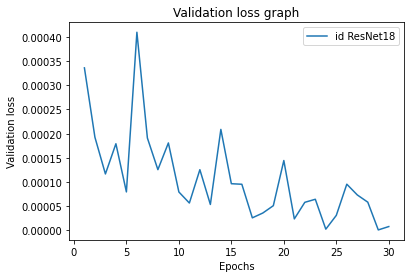

In [8]:
import matplotlib.pyplot as plt

x = [i for i in range(1,31)]
y = loss_test
Modelgraph = ['ResNet18']

plt.title("Validation loss graph")
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
#plt.figure(figsize=(10,10))

for i in range(len(y)):
    plt.plot(x,y[i],label = 'id %s'%Modelgraph[i])

plt.legend()
#plt.show()
plt.savefig('Validation loss graph')

#### Validation Accuracy Plot


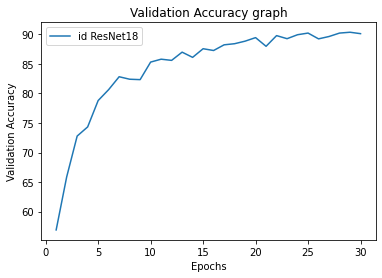

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

x = [i for i in range(1,31)]
y = accu
Modelgraph = ['ResNet18']


plt.title("Validation Accuracy graph")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")


for i in range(len(y)):
    plt.plot(x,y[i],label = 'id %s'%Modelgraph[i])

plt.legend()
plt.show()
plt.savefig('Validation Accuracy graph_')